In [98]:
import pandas as pd
import numpy as np
import scipy
import sklearn
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import time
import operator
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix,f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,fbeta_score,make_scorer
import time 
from sklearn.model_selection import LearningCurveDisplay
from sklearn.svm import SVC
import tensorflow_addons as tfa
from NNnet_class import NNnet


### BACKGROUND FUNCTIONS

In [4]:
#Global Beta
BETA=2

In [5]:
#Scorer Classes

class ld_accuracy_scorer:
    def __init__(self):
        self.__name__='accuracy'

    def __call__(self,estimator,X,y):
        return accuracy_score(estimator.predict(X),y)

from sklearn.metrics import fbeta_score
class ld_ftwo_scorer:
    def __init__(self,beta=2):
        self.beta=beta
        self.__name__='F1_B {} Score'.format(self.beta)

    def __call__(self,estimator,X,y,beta=2):
        return fbeta_score(estimator.predict(X),y,beta=self.beta)

#FBeta Scorer
ftwo_scorer=make_scorer(fbeta_score,beta=BETA)

#Accuracy_scorer
accuracy_scorer=make_scorer(accuracy_score)

In [48]:
#Loading Datasets

#Function to load and prepare the hotel dataset
def load_hotel():

    '''Load Hotel Dataset
    
    Returns:
    X (np.array): X array
    Y (np.array): Y array
    col_index (dict): Dictionary containing the pairing for the column location and it's name'''

    df=pd.read_csv('Data/Hotel_Res/Hotel Reservations.csv')
    df=df.drop('arrival_year',axis=1) #Remove Year
    df['season']=df['arrival_month'].apply(lambda x:1 if (x>=4 and x<=9) else 0) #0-Summer, 1-Winter
    df.drop('arrival_month',inplace=True,axis=1)
    df['point_in_month']=df['arrival_date'].apply(lambda x:1 if (x<=15) else 0) #0-eralier in the month,1-later

    #Removing Booking ID as it not a usefull feature
    df=df.drop('Booking_ID',axis=1)

    #Creating the labels (Y)
    Y=np.array(df['booking_status'].apply(lambda x:0 if x=='Not_Canceled' else 1)) #0 if not canceled, 1 if canceled

    df.drop('booking_status',inplace=True,axis=1)

    #Creating the feature vector, X 
    label_columns=['booking_status']
    categorical_columns=['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']
    non_categorical_variables=list(set(df.columns).difference(set(categorical_columns+label_columns)))
    X=np.array(df[non_categorical_variables])
    columns_categorized=non_categorical_variables

    #Now we need to one hot vectorize the type_of_meal_plan, room_type_reserved and market_segment_type
    label_dict={}
    for i in categorical_columns:
        label_dict[i]=OneHotEncoder()
        res=label_dict[i].fit_transform(np.array(df[i]).reshape(-1,1)).toarray()
        X=np.c_[X,res]
        columns_categorized=columns_categorized+[i+'%'+j for j in ['1','2','3','4','5','6','7'][:res.shape[-1]]]

        col_index={}
        results_corr={}
        for label,col in zip(columns_categorized,range(X.shape[-1])):
            corr=scipy.stats.pearsonr(X[:,col],Y)[0]
            results_corr[label]=corr
            col_index[label]=col
    return X,Y,col_index

#Load Fire Detection Dataset

def load_smoke_data():
    df_c=pd.read_csv('Data/Smoke/data.csv')
    X=np.array(df_c.iloc[:,:-1])
    Y=np.array(df_c.iloc[:,-1])
    return X,Y

# #Load CSR Data

# def load_csr_data():
#     df_c=pd.read_csv('Data/Satander Customer Satisfaction/data.csv')
#     X=np.array(df_c.iloc[:,:-1])
#     Y=np.array(df_c.iloc[:,-1])

#     return X,Y

def load_heart_data():

    '''Load Heart Disease Dataset
    
    Returns:
    X (np.array): X array
    Y (np.array): Y array
    col_index (dict): Dictionary containing the pairing for the column location and it's name'''

    df=pd.read_csv('Data/Heart_2/heart.csv')
    Y=np.array(df['HeartDisease'])
    df.drop('HeartDisease',axis=1,inplace=True)
    
    label_columns=['HeartDisease']
    categorical_columns=['Sex', 'ChestPainType', 'RestingECG','ExerciseAngina','ST_Slope']

    non_categorical_variables=list(set(df.columns).difference(set(categorical_columns+label_columns)))
    X=np.array(df[non_categorical_variables])
    columns_categorized=non_categorical_variables

    #Now we need to one hot vectorize the type_of_meal_plan, room_type_reserved and market_segment_type
    label_dict={}
    for i in categorical_columns:
        label_dict[i]=OneHotEncoder()
        res=label_dict[i].fit_transform(np.array(df[i]).reshape(-1,1)).toarray()
        X=np.c_[X,res]
        columns_categorized=columns_categorized+[i+'%'+j for j in ['1','2','3','4','5','6','7'][:res.shape[-1]]]

        col_index={}
        results_corr={}
        for label,col in zip(columns_categorized,range(X.shape[-1])):
            corr=scipy.stats.pearsonr(X[:,col],Y)[0]
            results_corr[label]=corr
            col_index[label]=col
    return X,Y,col_index

In [7]:
def split_data(X,Y,valid=True,standardize=False):

    '''
    Split the data between train, test and optional validation dataset

    Parameters:
    X (np.array): X features
    Y (np.rray): Labels
    valid (bool): Split into validation dataset 

    Returns:
    train (list): np.array list of train
    valid (list): optional np.array list of validation
    test (list): np.array list of test
    '''
    
    #Now let's split the data between test and train, we'll use the standard 80/20 split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

    if valid:
        #We'll also split the data between train and validation, we'll again use the standard 80/20 split
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2,random_state=42)
        
        if standardize:
            sklr=StandardScaler()
            X_train=sklr.fit_transform(X_train)
            X_valid=sklr.transform(X_valid)
            X_test=sklr.transform(X_test)
        return [X_train,y_train],[X_valid,y_valid],[X_test,y_test]

    if standardize:
        sklr=StandardScaler()
        X_train=sklr.fit_transform(X_train)
        X_test=sklr.transform(X_test)
    return [X_train,y_train],[X_test,y_test]

In [8]:
def create_param_curve(train,test,param,param_vals,ax,algorithim_name,algorithim,metric=accuracy_scorer,metric_name='Accuracy',graph=True,beta=BETA):

    '''Function to create parameter curves
    
    Parameters:
    train (np.array): Train
    test (np.array): Test
    param (str): Parameter to vary
    param_vals (list): Parameter values
    ax (matplotlib.axes): Axis for graph
    algorithim (sklearn.algorithim): Algorithim to vary parameter in
    metric (sklearn.metric): Metric to score algorotihim on
    metric_name (str): Metric Name
    graph (bool): Bool for validation graph
    
    Returns:
    None'''


    train_acc=[]
    test_acc=[]

    for i in param_vals:
        if i!='Default':
            if 'net' in algorithim_name.lower():
                kwargs={param:i,'input_dims':train[0].shape[-1]}
                clf=algorithim(**kwargs)
            else:
                clf=algorithim(**{param:i})
        else:
            clf=algorithim()
        clf.fit(train[0],train[1])

        if 'F' in metric_name.upper():
            train_acc.append(metric(y_pred=clf.predict(train[0]),y_true=train[1],beta=beta))
            test_acc.append(metric(y_pred=clf.predict(test[0]),y_true=test[1],beta=beta))
        else:
            train_acc.append(metric(y_pred=clf.predict(train[0]),y_true=train[1]))
            test_acc.append(metric(y_pred=clf.predict(test[0]),y_true=test[1]))

        # train_acc.append(metric(clf,train[0],train[1]))
        # test_acc.append(metric(clf,test[0],test[1]))

    best_val=param_vals[np.argmax(test_acc)]

    if type(param_vals[0])==str:
        ax.scatter(param_vals,train_acc,label='Training {}'.format(metric_name))
        ax.scatter(param_vals,test_acc,label='Validation {}'.format(metric_name))
    else:
        ax.plot(param_vals,train_acc,label='Training {}'.format(metric_name))
        ax.plot(param_vals,test_acc,label='Validation {}'.format(metric_name))
    #plt.xscale('log')
    ax.axvline(best_val,label='Best {} Value'.format(param),color='red',linestyle = '--')
    ax.legend()
    ax.set_ylabel('{}'.format(metric_name));
    ax.set_xlabel(param);
    ax.set_title('{} vs {}'.format(param,metric_name));
    if type(best_val)!=str:
        if best_val==max(param_vals):
            ax.text(y=(max(test_acc)+min(test_acc))/2+np.abs(np.std(test_acc)),x=best_val-np.std(param_vals)/12,s=best_val,color='green',weight='bold')
        else:
            ax.text(y=(max(test_acc)+min(test_acc))/2+np.abs(np.std(test_acc)),x=best_val+np.std(param_vals)/12,s=best_val,color='green',weight='bold')

In [9]:
def deal_algorithim(train,test,param_dicts,dataset,algorithim_name,algorithim,metric=accuracy_score,metric_name='Accuracy'):
    
    '''Function to deal with algorithim
    
    Parameters:
    train (np.array): Train
    test (np.array): Test
    param_dict (dict): Parameter dictionary to vary
    dataset (str): Dataset name
    algorithim_name (str): Algorithim name
    algorithim (sklearn.algorithim): Algorithim to vary parameter in
    metric (sklearn.metric): Metric to score algorotihim on
    metric_name (str): Metric Name
    
    Returns:
    None'''
    
    num_classes=len(param_dicts.keys())

    #Getting Fig Size
    fig,axes=plt.subplots(2,int(np.ceil(num_classes/2)))
    fig.set_size_inches(15,15)
    i=-1
    for c,ax in enumerate(fig.axes):
        i+=1
        plt.suptitle('Results for Algorithim: "{}" for "{}" Dataset'.format(algorithim_name,dataset),fontsize=18)
        param=list(param_dicts.keys())[i]
        param_vals=param_dicts[param]
        create_param_curve(train,test,param,param_vals,ax,algorithim_name,algorithim,metric,metric_name)
    plt.tight_layout()

In [10]:
def find_most_important_feature(X,Y,col_index):
    results_corr={}
    for label,col in col_index.items():
        #Removing Categorical Labels
        if '%' in label:
            continue
        corr=scipy.stats.pearsonr(X[:,col],Y)[0]
        results_corr[label]=corr

    #Sorting the dictionary by abs personr value and printing
    sorted_results_corr={k: v for k, v in sorted(results_corr.items(), key=lambda x: np.abs(x[1]))}
    return col_index[list(sorted_results_corr.keys())[-1]]


In [73]:
def fix_y(y_scores):
    max_score=np.max(y_scores)
    fixed=[100*(1+(i-max_score)/max_score) for i in y_scores]
    return fixed

In [142]:
def experiment_algorithim(train,test,X,Y,col_index,params,dataset,algorithim_name,algorithim,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy',search=True,LD_scoring=ld_accuracy_scorer()):
    
    '''Function to experiment with algorithim
    
    Parameters:
    train (np.array): Train
    test (np.array): Test
    X (np.array): All features
    Y (np.array): All labels
    params (dict): Parameter dictionary for GridSearch
    dataset (str): Dataset name
    col_index (int): Index for important column
    algorithim_name (str): Algorithim name
    algorithim (sklearn.algorithim): Algorithim being experimented on

    Returns:
    None'''

    ##NOISE IN KEY FEATURE

    fig,axes=plt.subplots(1,4)
    fig.set_size_inches(35,10)
    plt.suptitle('Experimentation on Algorithim: "{}" for the "{}" Dataset'.format(algorithim_name,dataset),fontsize=18)

    #Seeing the effect of noise on the two classifier's

    level_of_noise=[]
    clf_accuracy=[]
    clf_o_accuracy=[]
    most_important_index=find_most_important_feature(X,Y,col_index)
    
    if 'NET' in algorithim_name.upper():
        n_jobs=1
    else:
        n_jobs=-1

    if search:
        #GridSearch
        clf=GridSearchCV(algorithim,param_grid=params,verbose=0,n_jobs=n_jobs,cv=3,scoring=grid_search_metric,refit=True)
        clf.fit(train[0],train[1])
        clf_default=clf.best_estimator_
    else:
        clf_default_ld=algorithim.set_params(**params)
        clf_default=algorithim.set_params(**params)
        clf_default.fit(train[0],train[1])

    #Getting distributions for our two features with the highest predictive power, from our test set
    mp_mean,mp_std=np.mean(test[0][:,most_important_index]),np.std(test[0][:,most_important_index])

    for i in np.linspace(0,.1,10):
        #Creating Distributions to add
        dist=np.random.normal(mp_mean*i,mp_std*i,test[0].shape[0])

        #Now let's add this to our test X data
        X_test_altered=test[0].copy()
        X_test_altered[:,most_important_index]=X_test_altered[:,most_important_index]+dist

        #Appending Level of noise
        level_of_noise.append(i)

        #Scoring
        if 'F' in predictor_metric_name.upper():
            clf_o_accuracy.append(predictor_metric(y_pred=clf_default.predict(X_test_altered),y_true=test[-1],beta=BETA))
        else:
            clf_o_accuracy.append(predictor_metric(y_pred=clf_default.predict(X_test_altered),y_true=test[-1]))

    #Plotting
    axes[0].plot(level_of_noise,fix_y(clf_o_accuracy),label='Test {}'.format(predictor_metric_name),color='orange')
    axes[0].legend()
    axes[0].set_ylabel('{} % of Max'.format(predictor_metric_name));
    axes[0].set_xlabel('Level of Noise in Key Feature');
    axes[0].set_title('Noise in Key Feature and {} {}'.format(algorithim_name,predictor_metric_name));

    ##UNBALANCED DATASETS

    #Converting the balanced dataset into an unbalanced dataset
    ind_1=np.argwhere(train[-1]==1)
    ind_0=np.argwhere(train[-1]==0)
    train_acc=[]
    test_acc=[]
    class_1_size=[]
    #Now let's perform the experiment and create a graph at the end

    for percentage_of_ones_factor in np.linspace(0.1,1,10):
        #Sampling
        selected_ind=np.random.choice(ind_1.ravel(),size=int(len(ind_1)*percentage_of_ones_factor))
        X_train_unbalanced=np.r_[train[0][ind_0.ravel(),:],train[0][selected_ind,:]]
        y_train_unbalanced=np.r_[train[-1][ind_0.ravel()],train[-1][selected_ind]]
        class_1_size.append(len(selected_ind)/(len(selected_ind)+len(ind_0)))

        #Let's now trian and test the dataset
        if search:
            #GridSearch
            clf=GridSearchCV(algorithim,param_grid=params,verbose=0,n_jobs=n_jobs,cv=3,scoring=grid_search_metric)
            clf.fit(X_train_unbalanced,y_train_unbalanced)
        else:
            clf=algorithim.set_params(**params)
            clf.fit(X_train_unbalanced,y_train_unbalanced)
        
        #Testing with validation data not having been 'unbalanced'
        if 'F' in predictor_metric_name.upper():
            train_acc.append(predictor_metric(y_pred=clf.predict(X_train_unbalanced),y_true=y_train_unbalanced,beta=BETA))
            test_acc.append(predictor_metric(y_pred=clf.predict(test[0]),y_true=test[-1],beta=BETA))
        else:
            train_acc.append(f1_score(y_pred=clf.predict(X_train_unbalanced),y_true=y_train_unbalanced))
            test_acc.append(f1_score(y_pred=clf.predict(test[0]),y_true=test[-1]))

    #Plotting
    axes[1].plot(class_1_size,fix_y(train_acc),label='Training {}'.format(predictor_metric_name))
    axes[1].plot(class_1_size,fix_y(test_acc),label='Test {}'.format(predictor_metric_name))
    #plt.xscale('log')
    axes[1].legend()
    #axes[1].set_ylabel('{} % of Max'.format(predictor_metric_name));
    axes[1].set_ylabel('F1_score % of Max')
    axes[1].set_xlabel('Percentage of Data as Class 1');
    axes[1].set_title('The effect of unbalanced Datasets on {}'.format(algorithim_name));

    ##NOISY FEATURES
    #We'll add features to our training data, that are just noise, and observe the effect on the classifier. This time, we'll let optimize the parameters again, instead of relying with what we calculated earlier, we won't prune the tree though, as finding the ideal pruning value takes some time, and, given the number of rows, coupled with the objective of this exercise, it is not too important. 

    clf_o_accuracy_noisy_train=[]
    clf_o_accuracy_noisy_test=[]
    useless_features=np.linspace(0,15,3)
    standardize=False

    for uf in useless_features:
        X_noisy=X.copy()

        if uf==0:
            pass
        else:
            X_noisy=np.c_[X_noisy,np.random.normal(size=(X.shape[0],int(uf)))]
        
        if 'KNN' in algorithim_name.upper() or 'SVM' in algorithim_name.upper() or 'NET' in algorithim_name.upper():
            standardize=True

        #Same as before splitting the data into train,test & validation data
        train,test=split_data(X_noisy,Y,valid=False,standardize=standardize)

        #If statement to change input shape
        if 'NET' in algorithim_name.upper():
            params_send=params.copy()

            if search:
                params_send['input_dims']=[train[0].shape[-1]]
            else:
                params_send['input_dims']=train[0].shape[-1]
        else:
            params_send=params

        #Let's now trian and test the dataset
        if search:
            clf=GridSearchCV(algorithim,param_grid=params_send,verbose=0,n_jobs=n_jobs,cv=3,scoring=grid_search_metric)
            clf.fit(train[0],train[1])
        else:
            clf=algorithim.set_params(**params_send)
            clf.fit(train[0],train[1])

        if 'F' in predictor_metric_name.upper():
            clf_o_accuracy_noisy_train.append(predictor_metric(y_pred=clf.predict(train[0]),y_true=train[1],beta=BETA))
            clf_o_accuracy_noisy_test.append(predictor_metric(y_pred=clf.predict(test[0]),y_true=test[1],beta=BETA))
        else:
            clf_o_accuracy_noisy_train.append(predictor_metric(y_pred=clf.predict(train[0]),y_true=train[1]))
            clf_o_accuracy_noisy_test.append(predictor_metric(y_pred=clf.predict(test[0]),y_true=test[1]))

    #Plotting
    axes[2].plot(useless_features,fix_y(clf_o_accuracy_noisy_train),label='Train {}'.format(predictor_metric_name))
    axes[2].plot(useless_features,fix_y(clf_o_accuracy_noisy_test),label='Test {}'.format(predictor_metric_name))
    #plt.xscale('log')
    axes[2].legend()
    axes[2].set_ylabel('{} % of Max'.format(predictor_metric_name));
    axes[2].set_xlabel('Number of noisy features');
    axes[2].set_title('The effect of noisy features on {}'.format(algorithim_name));


    ##Training Datasize and Score
    axes[3].set_title('The effect of training size on {}'.format(algorithim_name));

    if 'KNN' in algorithim_name.upper() or 'SVM' in algorithim_name.upper() or 'NET' in algorithim_name.upper():
        sklr=StandardScaler()
        X_std=sklr.fit_transform(X)
    else:
        X_std=X      
        
    
    if 'NET' in algorithim_name.upper():
        LearningCurveDisplay.from_estimator(clf_default_ld,X_std,Y,cv=3,scoring=LD_scoring,ax=axes[3])
    else:
        LearningCurveDisplay.from_estimator(clf_default,X_std,Y,train_sizes=[0.05,0.1,0.25,0.5,0.75,1],ax=axes[3],scoring=LD_scoring)
    axes[3].set_ylabel('{}'.format(predictor_metric_name))

In [145]:
def experiment_algorithim(train,test,X,Y,col_index,params,dataset,algorithim_name,algorithim,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy',search=True,LD_scoring=ld_accuracy_scorer()):
    
    '''Function to experiment with algorithim
    
    Parameters:
    train (np.array): Train
    test (np.array): Test
    X (np.array): All features
    Y (np.array): All labels
    params (dict): Parameter dictionary for GridSearch
    dataset (str): Dataset name
    col_index (int): Index for important column
    algorithim_name (str): Algorithim name
    algorithim (sklearn.algorithim): Algorithim being experimented on

    Returns:
    None'''

    ##NOISE IN KEY FEATURE

    fig,axes=plt.subplots(1,4)
    fig.set_size_inches(35,10)
    plt.suptitle('Experimentation on Algorithim: "{}" for the "{}" Dataset'.format(algorithim_name,dataset),fontsize=18)

    #Seeing the effect of noise on the two classifier's

    level_of_noise=[]
    clf_accuracy=[]
    clf_o_accuracy=[]
    most_important_index=find_most_important_feature(X,Y,col_index)
    
    if 'NET' in algorithim_name.upper():
        n_jobs=1
    else:
        n_jobs=-1

    if search:
        #GridSearch
        clf=GridSearchCV(algorithim,param_grid=params,verbose=0,n_jobs=n_jobs,cv=3,scoring=grid_search_metric,refit=True)
        clf.fit(train[0],train[1])
        clf_default=clf.best_estimator_
    else:
        clf_default_ld=algorithim.set_params(**params)
        clf_default=algorithim.set_params(**params)
        clf_default.fit(train[0],train[1])

    # #Getting distributions for our two features with the highest predictive power, from our test set
    # mp_mean,mp_std=np.mean(test[0][:,most_important_index]),np.std(test[0][:,most_important_index])

    # for i in np.linspace(0,.1,10):
    #     #Creating Distributions to add
    #     dist=np.random.normal(mp_mean*i,mp_std*i,test[0].shape[0])

    #     #Now let's add this to our test X data
    #     X_test_altered=test[0].copy()
    #     X_test_altered[:,most_important_index]=X_test_altered[:,most_important_index]+dist

    #     #Appending Level of noise
    #     level_of_noise.append(i)

    #     #Scoring
    #     if 'F' in predictor_metric_name.upper():
    #         clf_o_accuracy.append(predictor_metric(y_pred=clf_default.predict(X_test_altered),y_true=test[-1],beta=BETA))
    #     else:
    #         clf_o_accuracy.append(predictor_metric(y_pred=clf_default.predict(X_test_altered),y_true=test[-1]))

    # #Plotting
    # axes[0].plot(level_of_noise,fix_y(clf_o_accuracy),label='Test {}'.format(predictor_metric_name),color='orange')
    # axes[0].legend()
    # axes[0].set_ylabel('{} % of Max'.format(predictor_metric_name));
    # axes[0].set_xlabel('Level of Noise in Key Feature');
    # axes[0].set_title('Noise in Key Feature and {} {}'.format(algorithim_name,predictor_metric_name));

    # ##UNBALANCED DATASETS

    # #Converting the balanced dataset into an unbalanced dataset
    # ind_1=np.argwhere(train[-1]==1)
    # ind_0=np.argwhere(train[-1]==0)
    # train_acc=[]
    # test_acc=[]
    # class_1_size=[]
    # #Now let's perform the experiment and create a graph at the end

    # for percentage_of_ones_factor in np.linspace(0.1,1,10):
    #     #Sampling
    #     selected_ind=np.random.choice(ind_1.ravel(),size=int(len(ind_1)*percentage_of_ones_factor))
    #     X_train_unbalanced=np.r_[train[0][ind_0.ravel(),:],train[0][selected_ind,:]]
    #     y_train_unbalanced=np.r_[train[-1][ind_0.ravel()],train[-1][selected_ind]]
    #     class_1_size.append(len(selected_ind)/(len(selected_ind)+len(ind_0)))

    #     #Let's now trian and test the dataset
    #     if search:
    #         #GridSearch
    #         clf=GridSearchCV(algorithim,param_grid=params,verbose=0,n_jobs=n_jobs,cv=3,scoring=grid_search_metric)
    #         clf.fit(X_train_unbalanced,y_train_unbalanced)
    #     else:
    #         clf=algorithim.set_params(**params)
    #         clf.fit(X_train_unbalanced,y_train_unbalanced)
        
    #     #Testing with validation data not having been 'unbalanced'
    #     if 'F' in predictor_metric_name.upper():
    #         train_acc.append(predictor_metric(y_pred=clf.predict(X_train_unbalanced),y_true=y_train_unbalanced,beta=BETA))
    #         test_acc.append(predictor_metric(y_pred=clf.predict(test[0]),y_true=test[-1],beta=BETA))
    #     else:
    #         train_acc.append(f1_score(y_pred=clf.predict(X_train_unbalanced),y_true=y_train_unbalanced))
    #         test_acc.append(f1_score(y_pred=clf.predict(test[0]),y_true=test[-1]))

    # #Plotting
    # axes[1].plot(class_1_size,fix_y(train_acc),label='Training {}'.format(predictor_metric_name))
    # axes[1].plot(class_1_size,fix_y(test_acc),label='Test {}'.format(predictor_metric_name))
    # #plt.xscale('log')
    # axes[1].legend()
    # #axes[1].set_ylabel('{} % of Max'.format(predictor_metric_name));
    # axes[1].set_ylabel('F1_score % of Max')
    # axes[1].set_xlabel('Percentage of Data as Class 1');
    # axes[1].set_title('The effect of unbalanced Datasets on {}'.format(algorithim_name));

    # ##NOISY FEATURES
    # #We'll add features to our training data, that are just noise, and observe the effect on the classifier. This time, we'll let optimize the parameters again, instead of relying with what we calculated earlier, we won't prune the tree though, as finding the ideal pruning value takes some time, and, given the number of rows, coupled with the objective of this exercise, it is not too important. 

    # clf_o_accuracy_noisy_train=[]
    # clf_o_accuracy_noisy_test=[]
    # useless_features=np.linspace(0,15,3)
    # standardize=False

    # for uf in useless_features:
    #     X_noisy=X.copy()

    #     if uf==0:
    #         pass
    #     else:
    #         X_noisy=np.c_[X_noisy,np.random.normal(size=(X.shape[0],int(uf)))]
        
    #     if 'KNN' in algorithim_name.upper() or 'SVM' in algorithim_name.upper() or 'NET' in algorithim_name.upper():
    #         standardize=True

    #     #Same as before splitting the data into train,test & validation data
    #     train,test=split_data(X_noisy,Y,valid=False,standardize=standardize)

    #     #If statement to change input shape
    #     if 'NET' in algorithim_name.upper():
    #         params_send=params.copy()

    #         if search:
    #             params_send['input_dims']=[train[0].shape[-1]]
    #         else:
    #             params_send['input_dims']=train[0].shape[-1]
    #     else:
    #         params_send=params

    #     #Let's now trian and test the dataset
    #     if search:
    #         clf=GridSearchCV(algorithim,param_grid=params_send,verbose=0,n_jobs=n_jobs,cv=3,scoring=grid_search_metric)
    #         clf.fit(train[0],train[1])
    #     else:
    #         clf=algorithim.set_params(**params_send)
    #         clf.fit(train[0],train[1])

    #     if 'F' in predictor_metric_name.upper():
    #         clf_o_accuracy_noisy_train.append(predictor_metric(y_pred=clf.predict(train[0]),y_true=train[1],beta=BETA))
    #         clf_o_accuracy_noisy_test.append(predictor_metric(y_pred=clf.predict(test[0]),y_true=test[1],beta=BETA))
    #     else:
    #         clf_o_accuracy_noisy_train.append(predictor_metric(y_pred=clf.predict(train[0]),y_true=train[1]))
    #         clf_o_accuracy_noisy_test.append(predictor_metric(y_pred=clf.predict(test[0]),y_true=test[1]))

    # #Plotting
    # axes[2].plot(useless_features,fix_y(clf_o_accuracy_noisy_train),label='Train {}'.format(predictor_metric_name))
    # axes[2].plot(useless_features,fix_y(clf_o_accuracy_noisy_test),label='Test {}'.format(predictor_metric_name))
    # #plt.xscale('log')
    # axes[2].legend()
    # axes[2].set_ylabel('{} % of Max'.format(predictor_metric_name));
    # axes[2].set_xlabel('Number of noisy features');
    # axes[2].set_title('The effect of noisy features on {}'.format(algorithim_name));


    ##Training Datasize and Score
    axes[3].set_title('The effect of training size on {}'.format(algorithim_name));

    if 'KNN' in algorithim_name.upper() or 'SVM' in algorithim_name.upper() or 'NET' in algorithim_name.upper():
        sklr=StandardScaler()
        X_std=sklr.fit_transform(X)
    else:
        X_std=X      
        
    
    if 'NET' in algorithim_name.upper():
        LearningCurveDisplay.from_estimator(clf_default_ld,X_std,Y,cv=3,scoring=LD_scoring,ax=axes[3])
    else:
        LearningCurveDisplay.from_estimator(clf_default,X_std,Y,train_sizes=[0.05,0.1,0.25,0.5,0.75,1],ax=axes[3],scoring=LD_scoring)
    axes[3].set_ylabel('{}'.format(predictor_metric_name))

In [12]:
def score_algorithim(X,Y,dataset_name,algorithim_name,algorithim,params,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy',return_needed=False):

    '''Function to score algorithim
    
    Parameters:
    X (np.array): All features
    Y (np.array): All labels
    dataset_name (str): Dataset name
    algorithim_name (str): Algorithim name
    algorithim (sklearn.algorithim): Algorithim being experimented on
    params (dict): Parameter dictionary for GridSearch
    metric (sklearn.metric): Metric to score algorotihim on
    metric_name (str): Metric Name
    return_needed (bool): Bool if fit model needed to be returned    

    Returns:
    glf (sklearn.model): Fit model'''

    standardize=False
    if 'KNN' in algorithim_name.upper() or 'SVM' in algorithim_name.upper() or 'NET' in algorithim_name.upper():
        standardize=True
    
    if 'NET' in algorithim_name.upper():
        n_jobs=1
    else:
        n_jobs=-1


    train,test=split_data(X,Y,valid=False,standardize=standardize)

    glf_cv=GridSearchCV(algorithim,param_grid=params,verbose=0,n_jobs=n_jobs,cv=3,scoring=grid_search_metric,refit=True)

    rep=10
    start_time=time.time()
    glf_cv.fit(train[0],train[1])

    glf=glf_cv.best_estimator_
    
    for i in range(rep):
        glf.fit(train[0],train[1])
    time_delay_train=(time.time()-start_time)/rep

    y_train_pred=glf.predict(train[0])
    
    if 'F' in predictor_metric_name.upper():
        train_score = predictor_metric(y_pred=glf.predict(train[0]),y_true=train[1],beta=BETA)
        test_score = predictor_metric(y_pred=glf.predict(test[0]),y_true=test[1],beta=BETA)
    else:
        train_score = predictor_metric(y_pred=glf.predict(train[0]),y_true=train[1])
        test_score = predictor_metric(y_pred=glf.predict(test[0]),y_true=test[1])

    start_time=time.time()
    for i in range(rep):
        y_test_pred=glf.predict(test[0])
    time_delay_infer=(time.time()-start_time)/rep

    print('{} Final Results'.format(dataset_name))
    print('\n')
    print(glf_cv.best_params_)
    print('\n')
    print('Average time to train the ideal {} was {:.3f} seconds'.format(algorithim_name,time_delay_train))
    print('Average time to infer the ideal {} was {:.3f} seconds'.format(algorithim_name,time_delay_infer))
    print('\n')
    print('The result on the training data for the ideal {} algorithim is a {} {} score'.format(algorithim_name,train_score,predictor_metric_name))
    print('The result on the test data for the ideal {} algorithim is a {} {} score'.format(algorithim_name,test_score,predictor_metric_name))
    
    if return_needed:
        return glf

### DECISION TREES

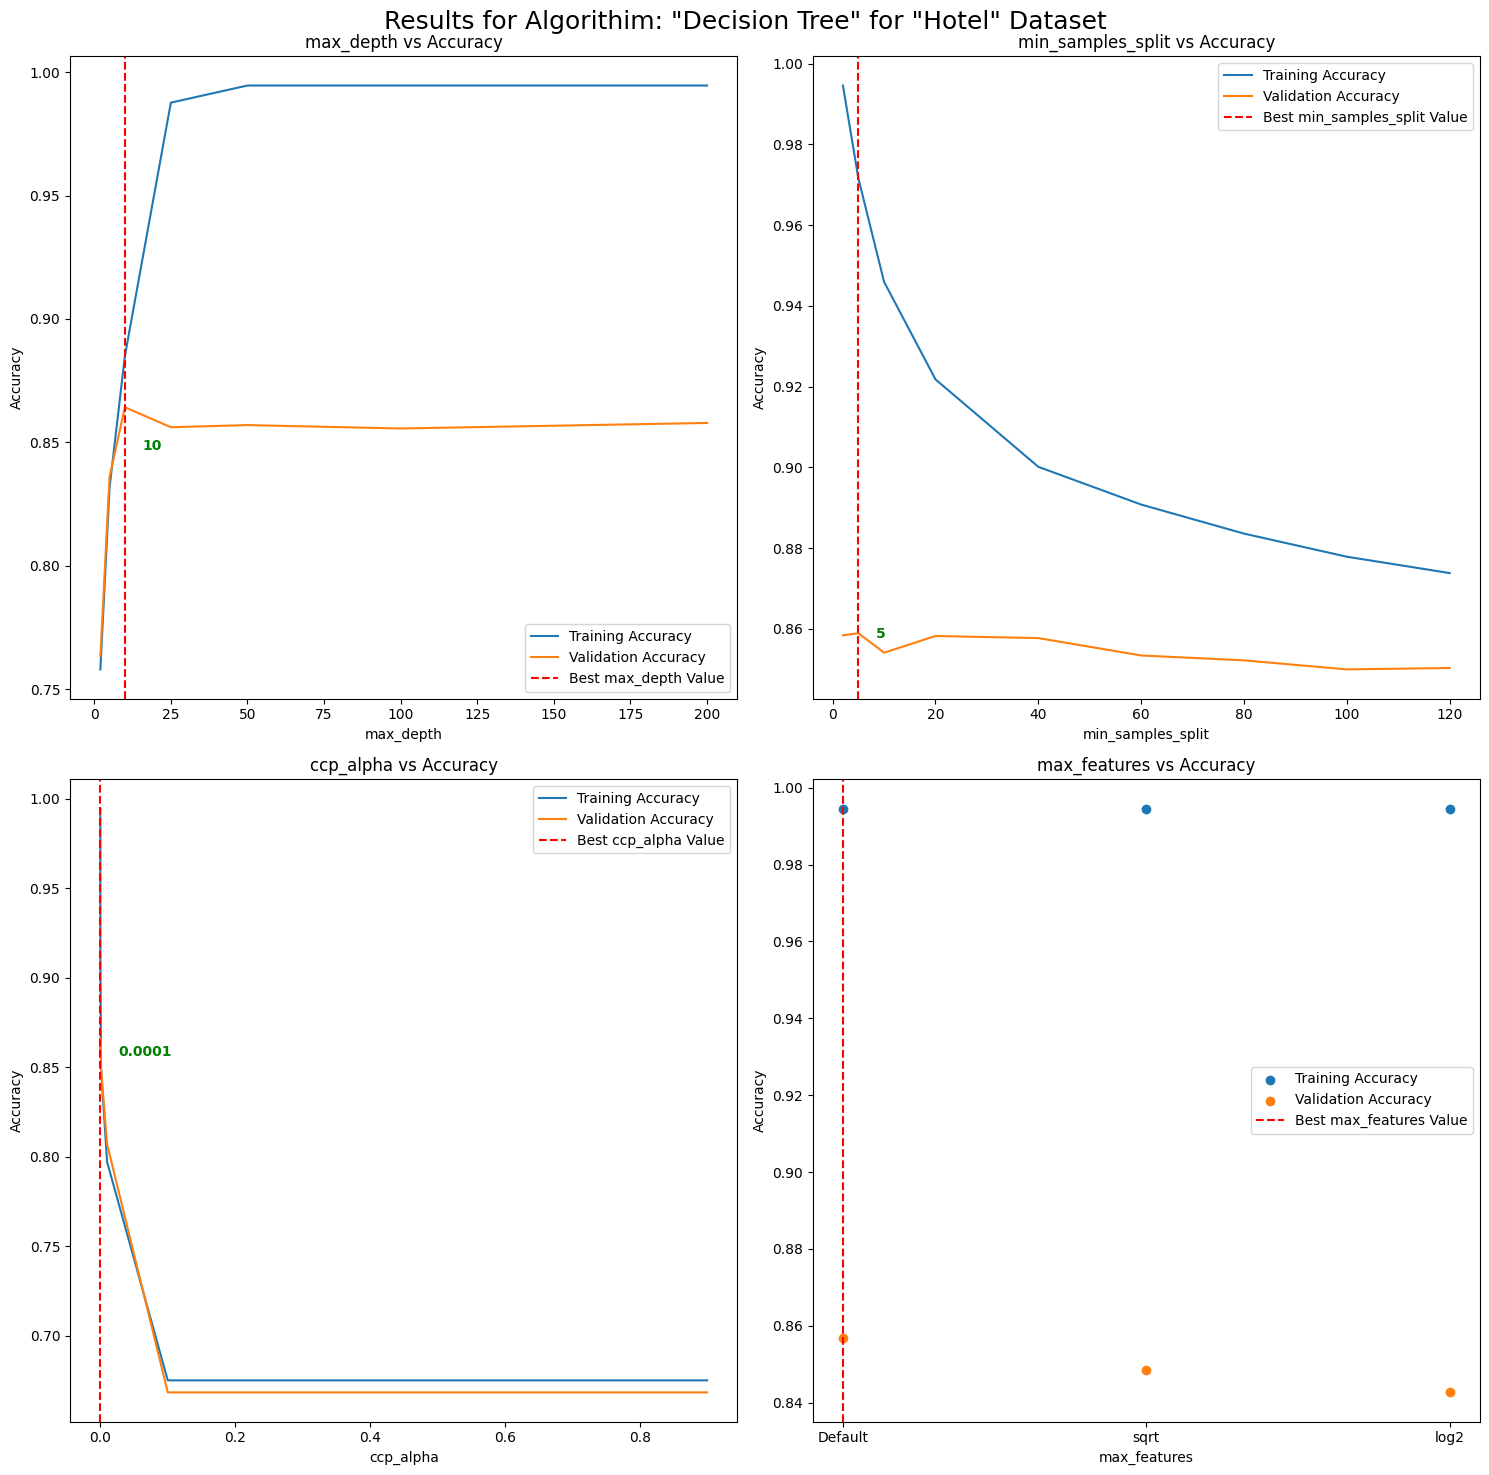

In [69]:
#Hotel Data

X_hotel,Y_hotel,col_index_hotel=load_hotel()
train_hotel,valid_hotel,test_hotel=split_data(X_hotel,Y_hotel)

param_dicts={'max_depth':[2,5,10,25,50,100,200],'min_samples_split':[2,5,10,20,40,60,80,100,120],'ccp_alpha':[0,0.0001,0.001,0.01,0.1,0.5,0.9],'max_features':['Default','sqrt','log2']}
deal_algorithim(train_hotel,valid_hotel,param_dicts,'Hotel','Decision Tree',DecisionTreeClassifier)


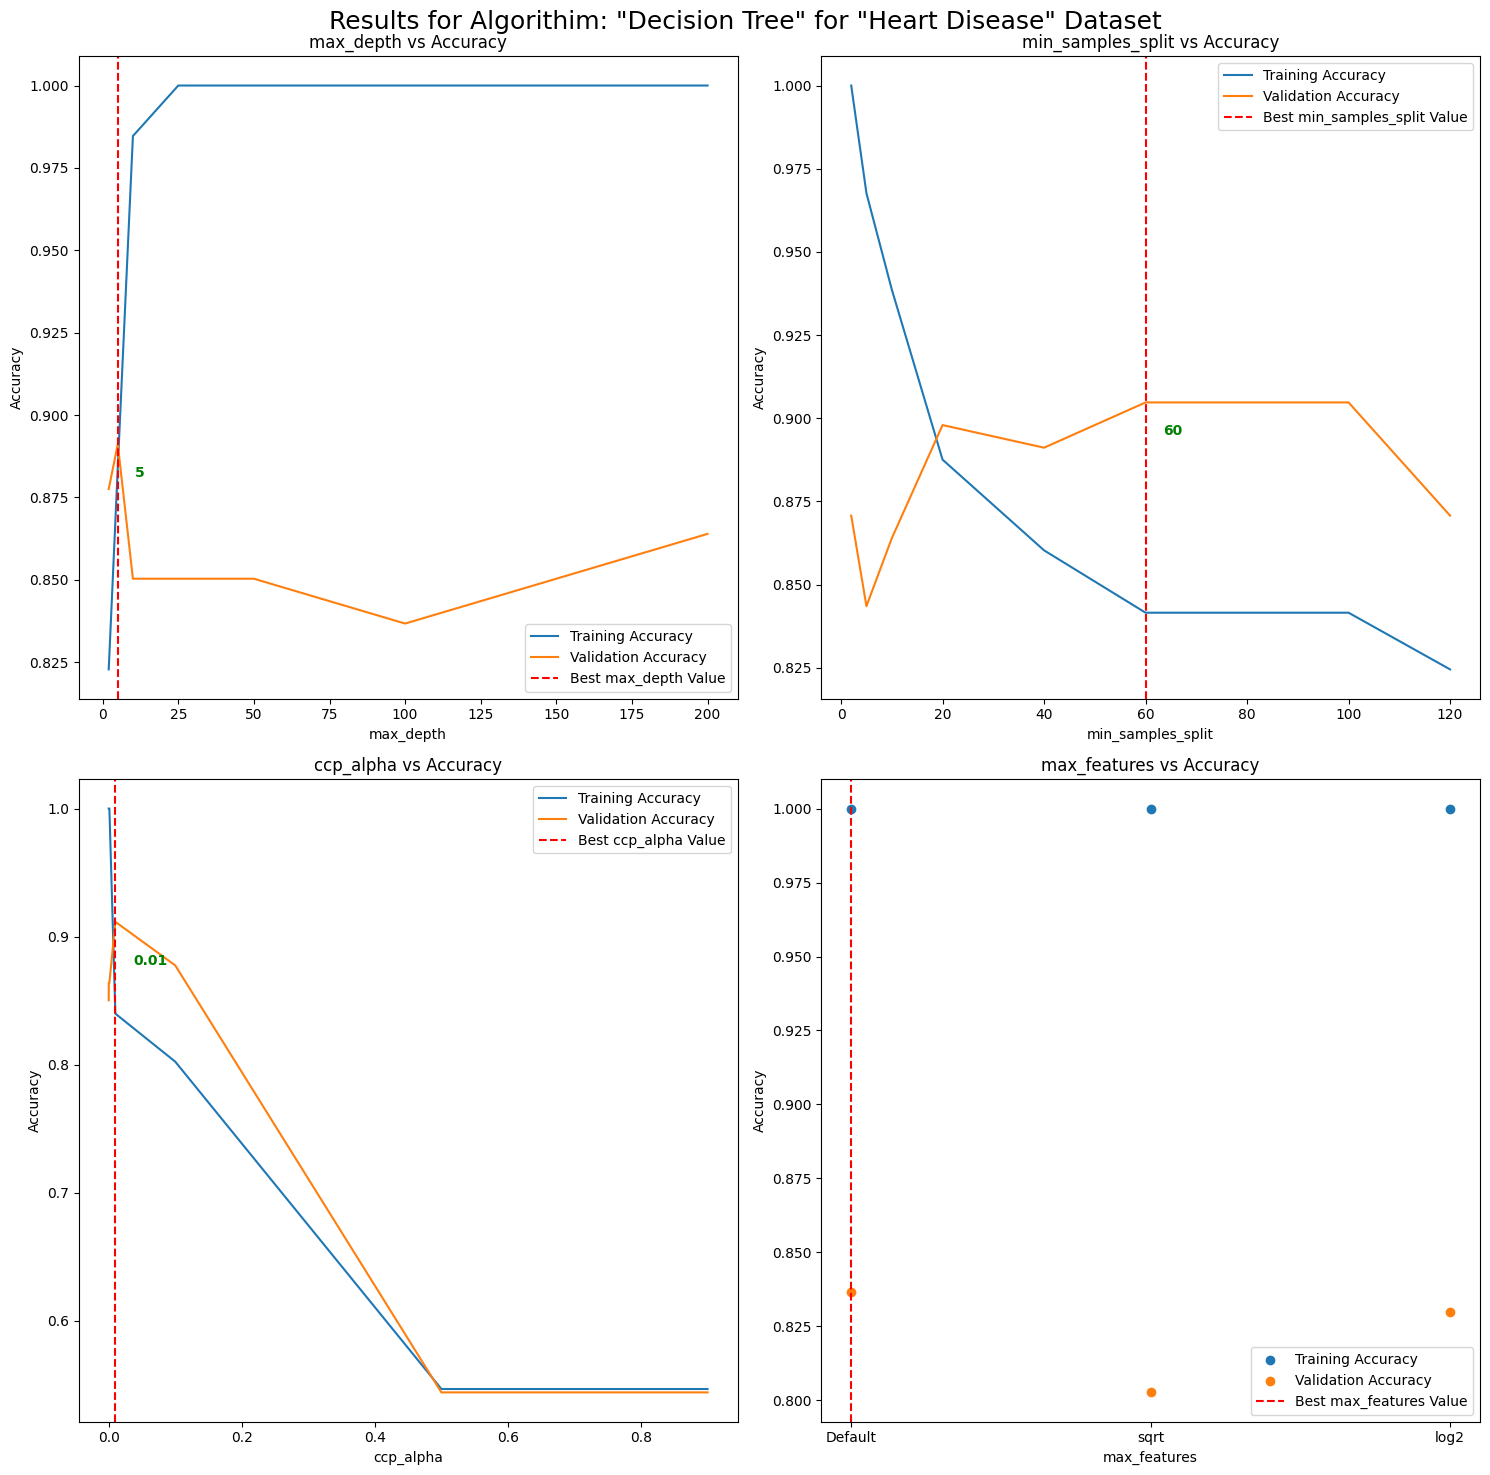

In [79]:
#Heart Data
X_heart,Y_heart,col_index_heart=load_heart_data()
train_heart,valid_heart,test_heart=split_data(X_heart,Y_heart)

param_dicts={'max_depth':[2,5,10,25,50,100,200],'min_samples_split':[2,5,10,20,40,60,80,100,120],'ccp_alpha':[0,0.0001,0.001,0.01,0.1,0.5,0.9],'max_features':['Default','sqrt','log2']}
#deal_algorithim(train_heart,valid_heart,param_dicts,'Heart Disease','Decision Tree',DecisionTreeClassifier,fbeta_score,'F_Beta_2 score')
deal_algorithim(train_heart,valid_heart,param_dicts,'Heart Disease','Decision Tree',DecisionTreeClassifier)

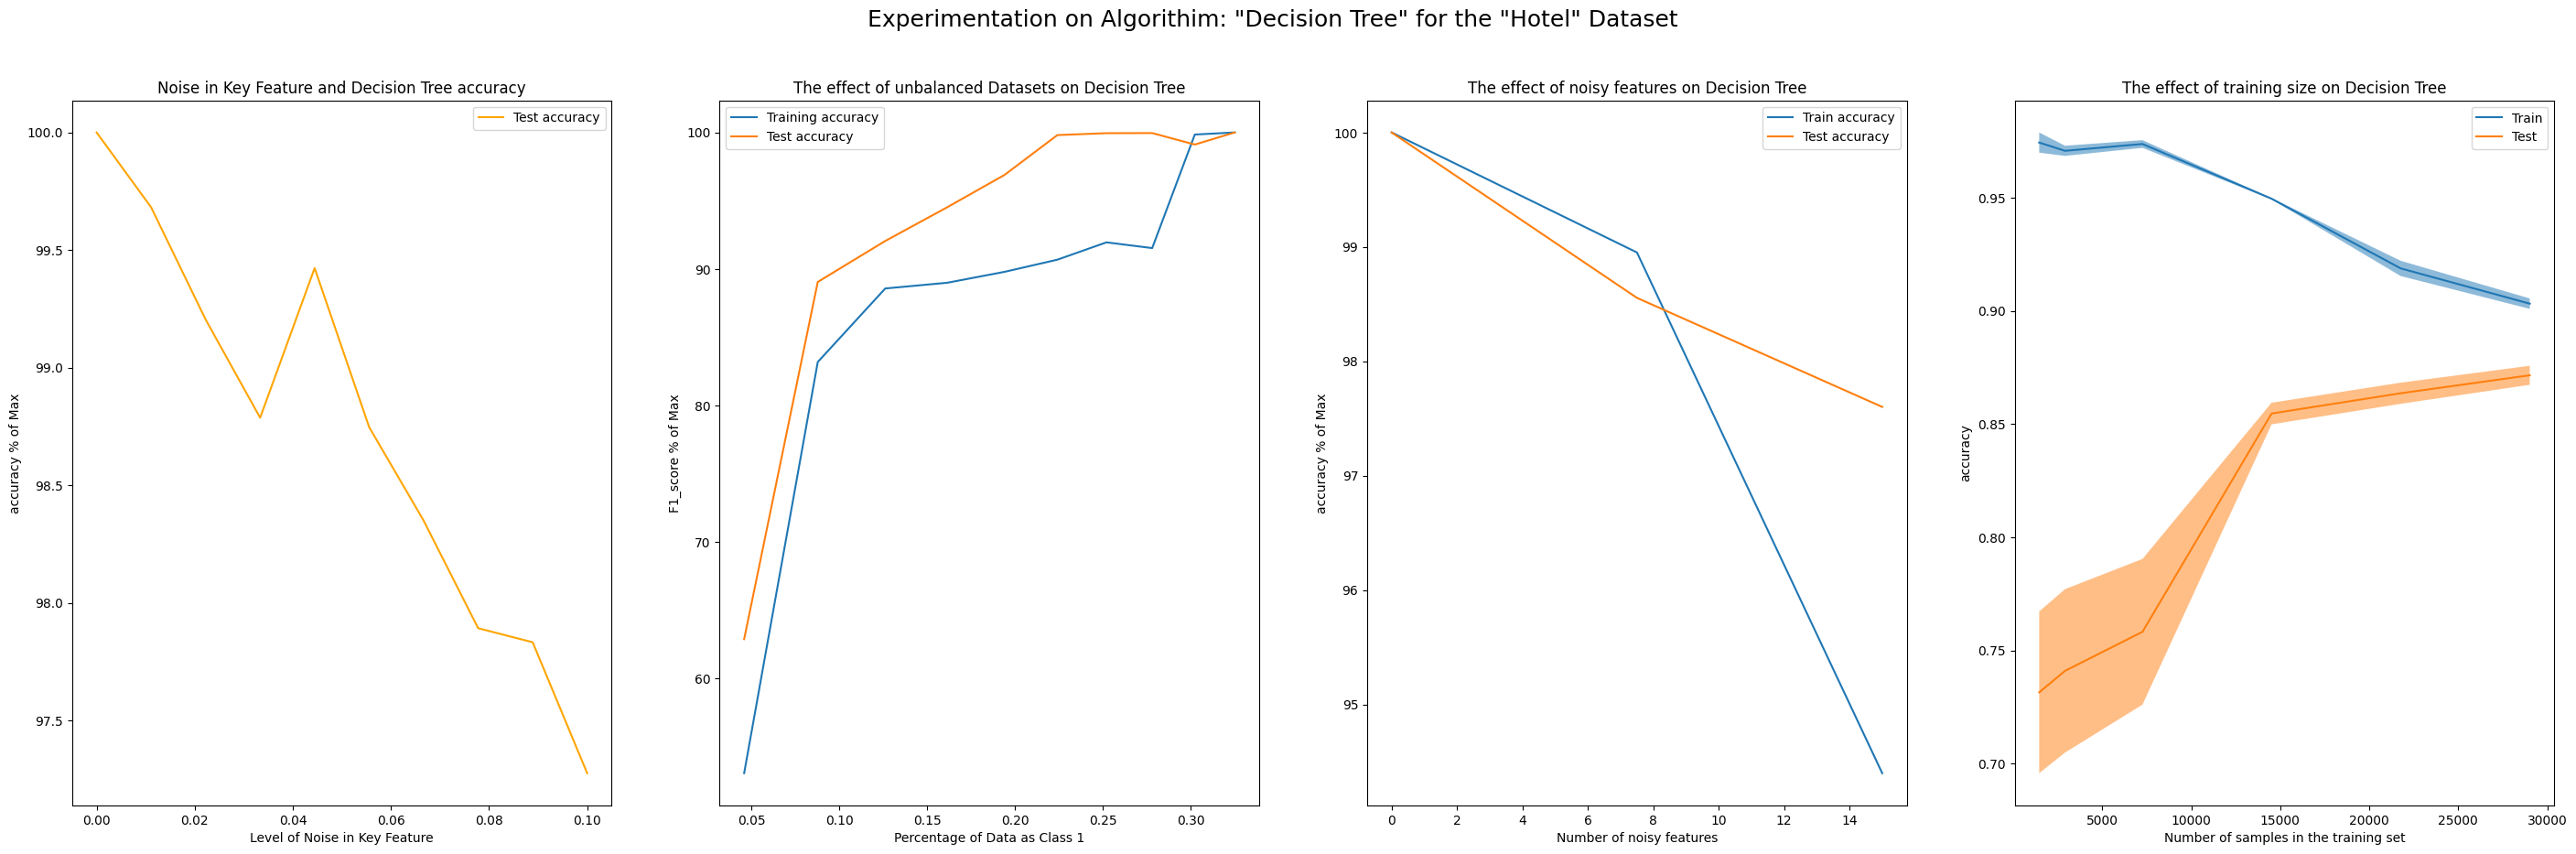

In [99]:
#Experimenting on Hotel Dataset
param_dicts={'max_depth':[5,25,50,150],'min_samples_split':[5,20,40,60],'ccp_alpha':[0,0.0001,0.001,0.01]}
experiment_algorithim(train=train_hotel,test=valid_hotel,X=X_hotel,Y=Y_hotel,params=param_dicts,dataset='Hotel',col_index=col_index_hotel,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,algorithim_name='Decision Tree',algorithim=DecisionTreeClassifier(),predictor_metric_name='accuracy',search=True,LD_scoring=ld_accuracy_scorer())

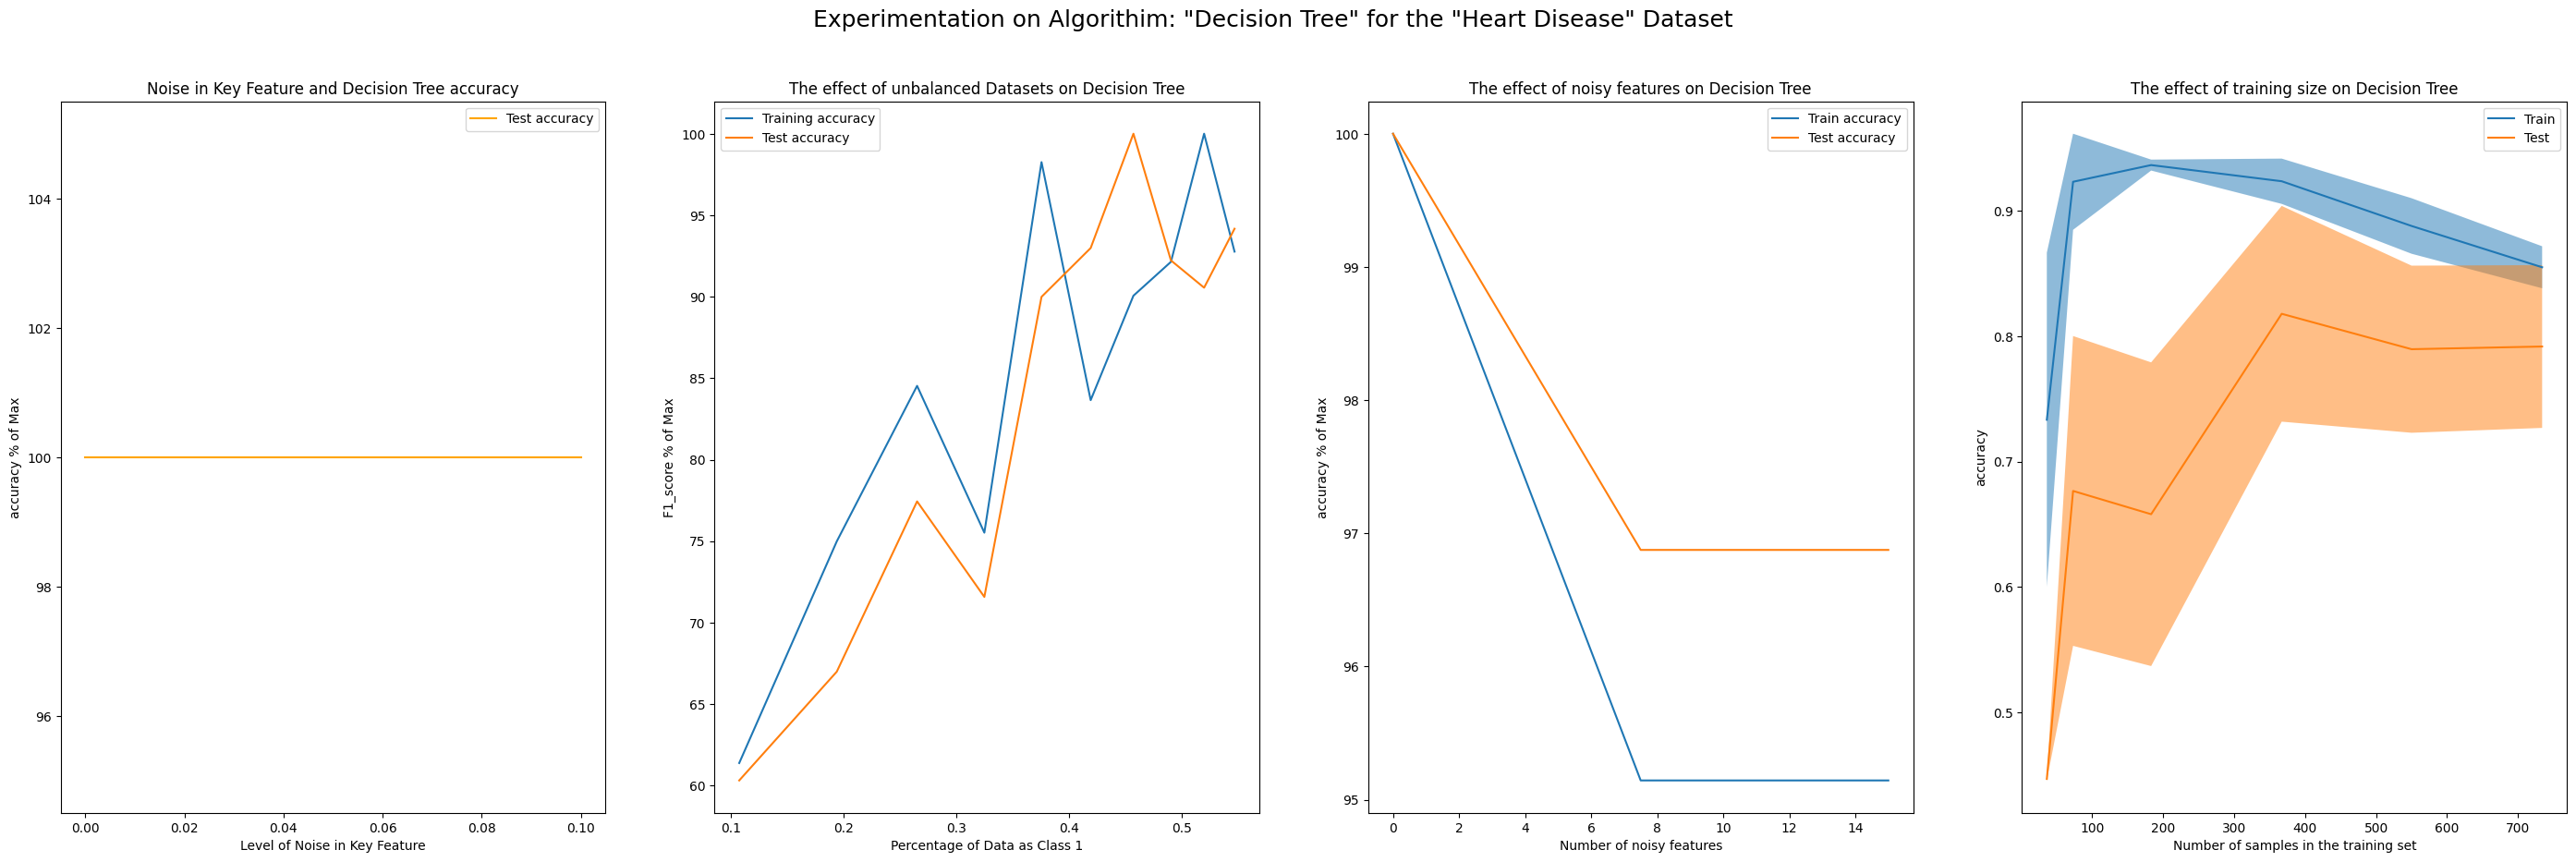

In [100]:
#Experimenting on Heart Dataset Accuracy Score
param_dicts={'max_depth':[5,25,50,150],'min_samples_split':[5,20,40,60],'ccp_alpha':[0,0.0001,0.001,0.01]}
experiment_algorithim(train=train_heart,test=test_heart,X=X_heart,Y=Y_heart,params=param_dicts,dataset='Heart Disease',col_index=col_index_heart,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,algorithim_name='Decision Tree',algorithim=DecisionTreeClassifier(),predictor_metric_name='accuracy',search=True,LD_scoring=ld_accuracy_scorer())

c:\Users\Admin\anaconda3\envs\ML_2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\Admin\anaconda3\envs\ML_2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


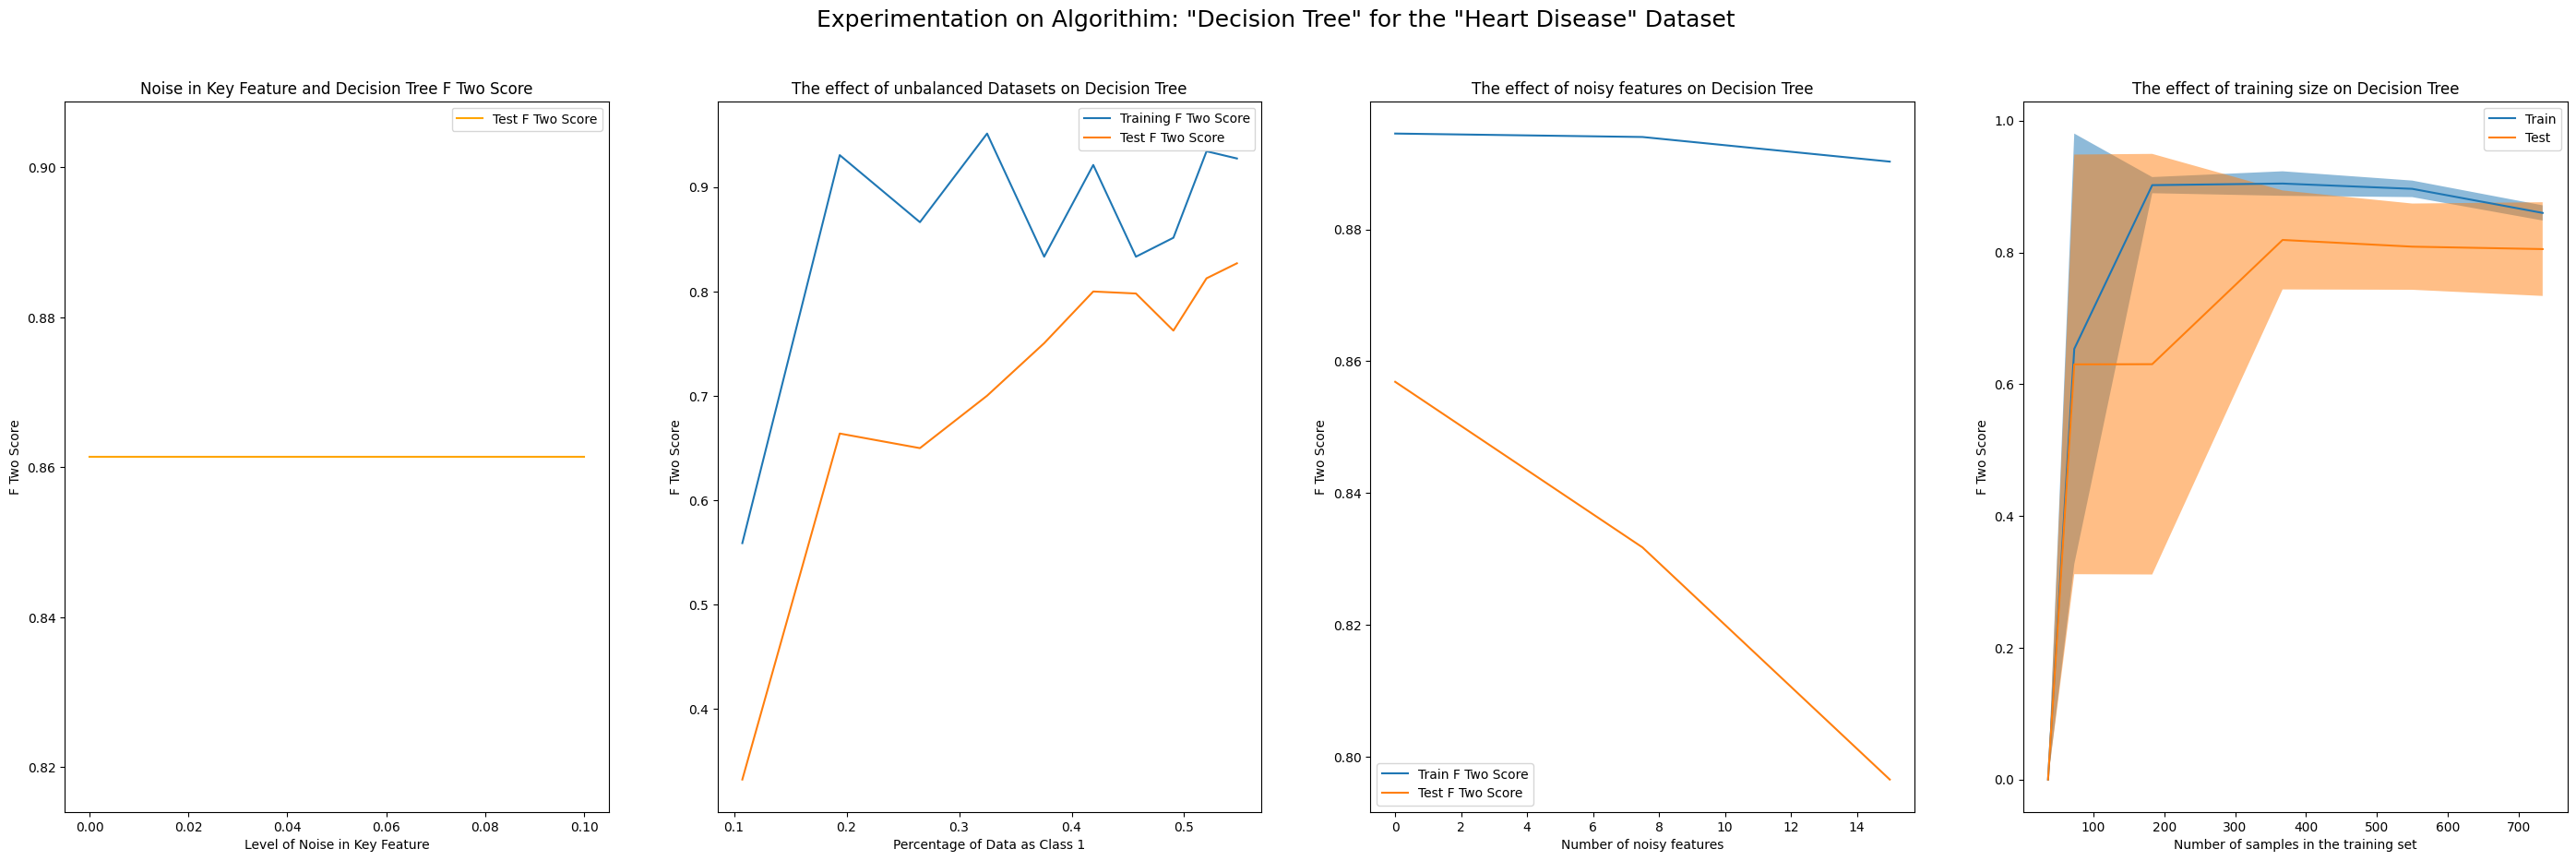

In [55]:
#Experimenting on Heart Dataset
param_dicts={'max_depth':[5,25,50,150],'min_samples_split':[5,20,40,60],'ccp_alpha':[0,0.0001,0.001,0.01]}
experiment_algorithim(train=train_heart,test=test_heart,X=X_heart,Y=Y_heart,params=param_dicts,dataset='Heart Disease',col_index=col_index_heart,predictor_metric=fbeta_score,grid_search_metric=ftwo_scorer,algorithim_name='Decision Tree',algorithim=DecisionTreeClassifier(),predictor_metric_name='F Two Score',search=True,LD_scoring=ld_ftwo_scorer())

In [29]:
#Hotel Scoring
param_dicts={'max_depth':[2,5,10,25,50,100,200],'min_samples_split':[2,5,10,20,40,60,80,100,120],'ccp_alpha':[0,0.0001,0.001,0.01,0.1,0.5,0.9],'max_features':[None,'sqrt','log2']}
score_algorithim(X=X_hotel,Y=Y_hotel,dataset_name='Hotel Dataset',algorithim_name='Decision Tree Classifier',algorithim=DecisionTreeClassifier(),params=param_dicts,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy')

Hotel Dataset Final Results


{'ccp_alpha': 0.0001, 'max_depth': 10, 'max_features': None, 'min_samples_split': 5}


Average time to train the ideal Decision Tree Classifier was 1.199 seconds
Average time to infer the ideal Decision Tree Classifier was 0.001 seconds


The result on the training data for the ideal Decision Tree Classifier algorithim is a 0.877394900068918 accuracy score
The result on the test data for the ideal Decision Tree Classifier algorithim is a 0.8667126119917299 accuracy score


In [80]:
#Heart Disease Dataset Accuracy
param_dicts={'max_depth':[2,5,10],'min_samples_split':[40,60,800],'ccp_alpha':[0.001,0.01,0.1],'max_features':[None,'log2']}
score_algorithim(X=X_heart,Y=Y_heart,dataset_name='Heart Disease Dataset',algorithim_name='Decision Tree Classifier',algorithim=DecisionTreeClassifier(),params=param_dicts,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy')

Heart Disease Dataset Final Results


{'ccp_alpha': 0.001, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 40}


Average time to train the ideal Decision Tree Classifier was 0.023 seconds
Average time to infer the ideal Decision Tree Classifier was 0.000 seconds


The result on the training data for the ideal Decision Tree Classifier algorithim is a 0.8569482288828338 accuracy score
The result on the test data for the ideal Decision Tree Classifier algorithim is a 0.7934782608695652 accuracy score


In [30]:
#Heart Disease Dataset FTwo
param_dicts={'max_depth':[2,5,10,25,50,100,200],'min_samples_split':[2,5,10,20,40,60,80,100,120],'ccp_alpha':[0,0.0001,0.001,0.01,0.1,0.5,0.9],'max_features':[None,'sqrt','log2']}
score_algorithim(X=X_heart,Y=Y_heart,dataset_name='Heart Disease Dataset',algorithim_name='Decision Tree Classifier',algorithim=DecisionTreeClassifier(),params=param_dicts,predictor_metric=fbeta_score,grid_search_metric=accuracy_scorer,predictor_metric_name='F Two Score')

Heart Disease Dataset Final Results


{'ccp_alpha': 0, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 5}


Average time to train the ideal Decision Tree Classifier was 0.109 seconds
Average time to infer the ideal Decision Tree Classifier was 0.000 seconds


The result on the training data for the ideal Decision Tree Classifier algorithim is a 0.905940594059406 F Two Score score
The result on the test data for the ideal Decision Tree Classifier algorithim is a 0.8061420345489443 F Two Score score


### GRADIENT BOOSTED CLASSIFIER

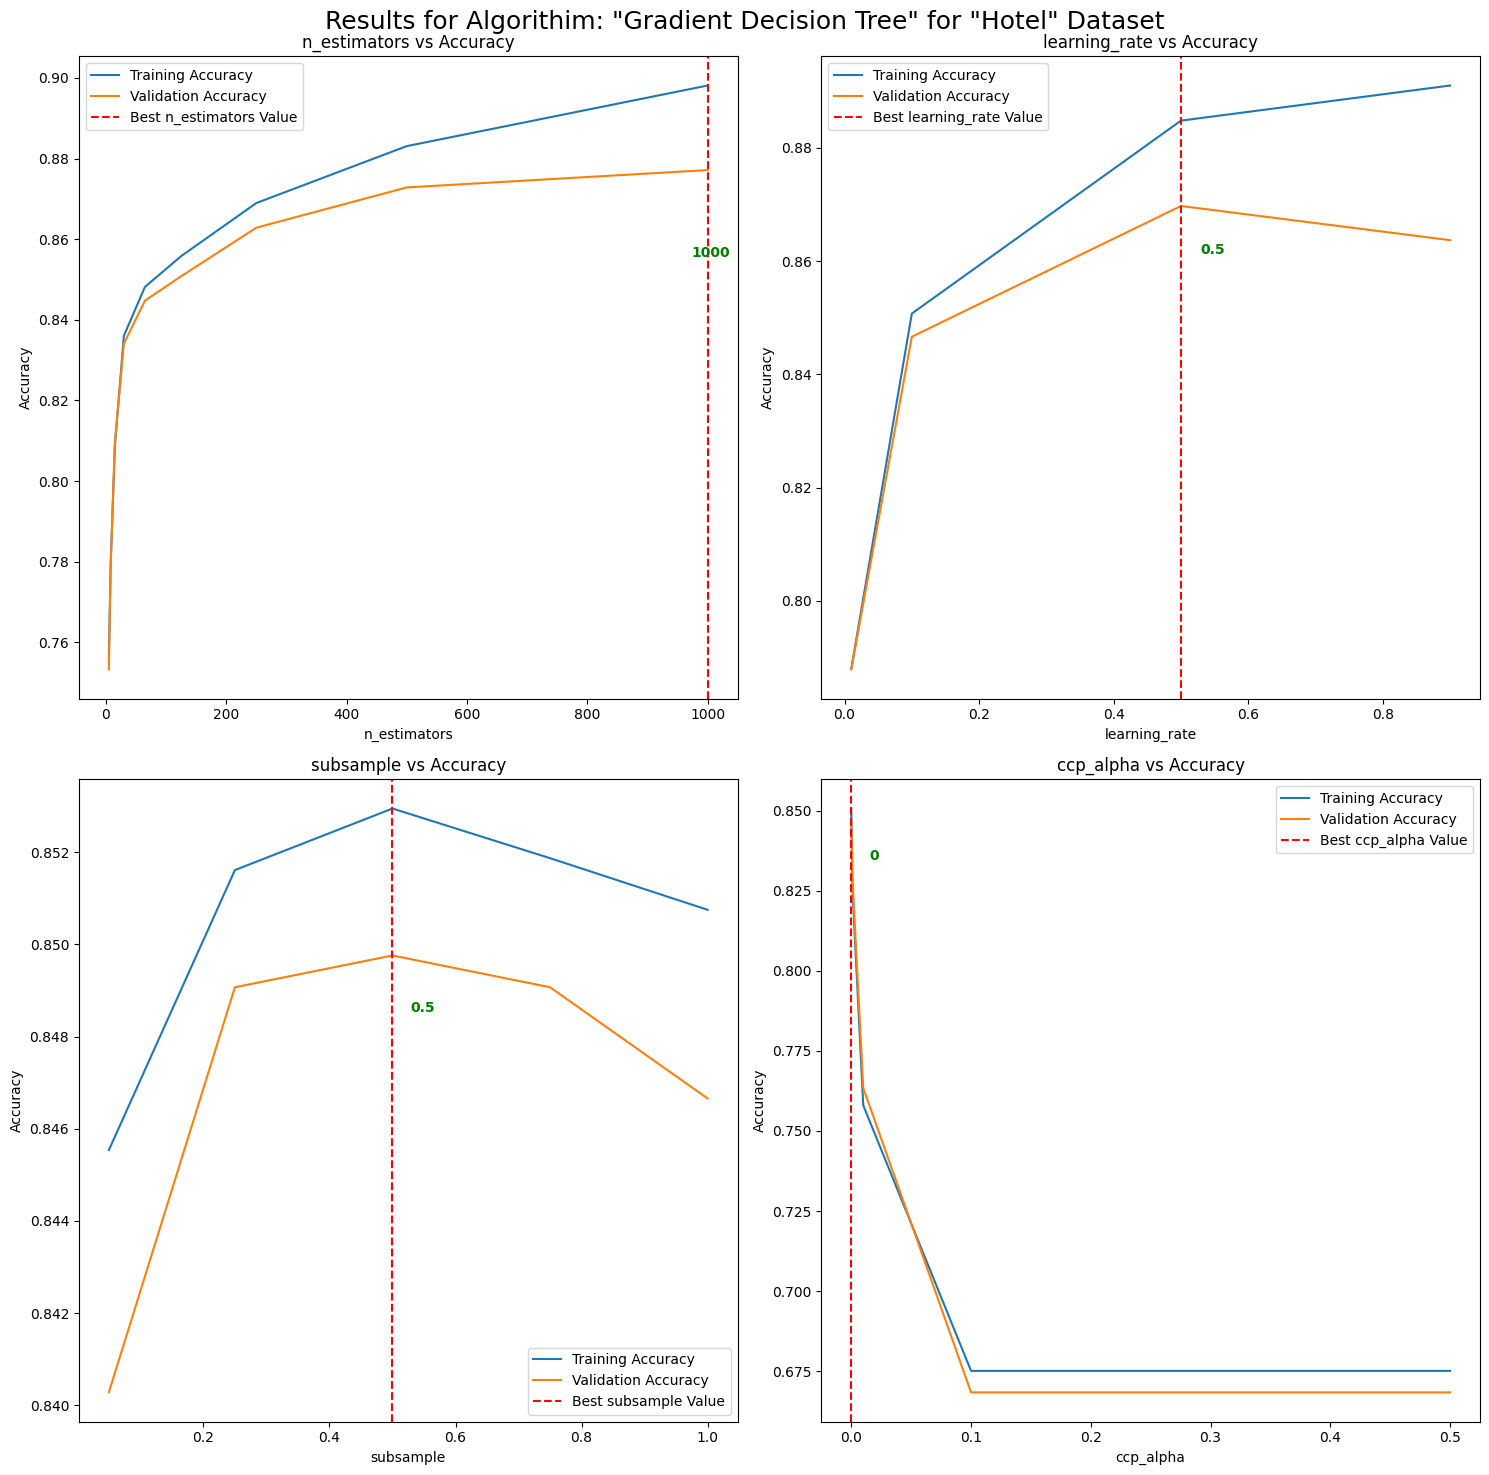

In [86]:
n_estimators_log=[1000,500,250,125,65,30,15,8,5]
learning_rates=[0.9,0.5,0.1,0.01]
subsample_vals=[0.05,0.25,0.5,0.75,1.0]
ccp_alphas=[0,0.0001,0.001,0.01,0.1,0.5]

param_dicts={'n_estimators':n_estimators_log,'learning_rate':learning_rates,'subsample':subsample_vals,'ccp_alpha':ccp_alphas}
deal_algorithim(train_hotel,valid_hotel,param_dicts,'Hotel','Gradient Decision Tree',GradientBoostingClassifier)

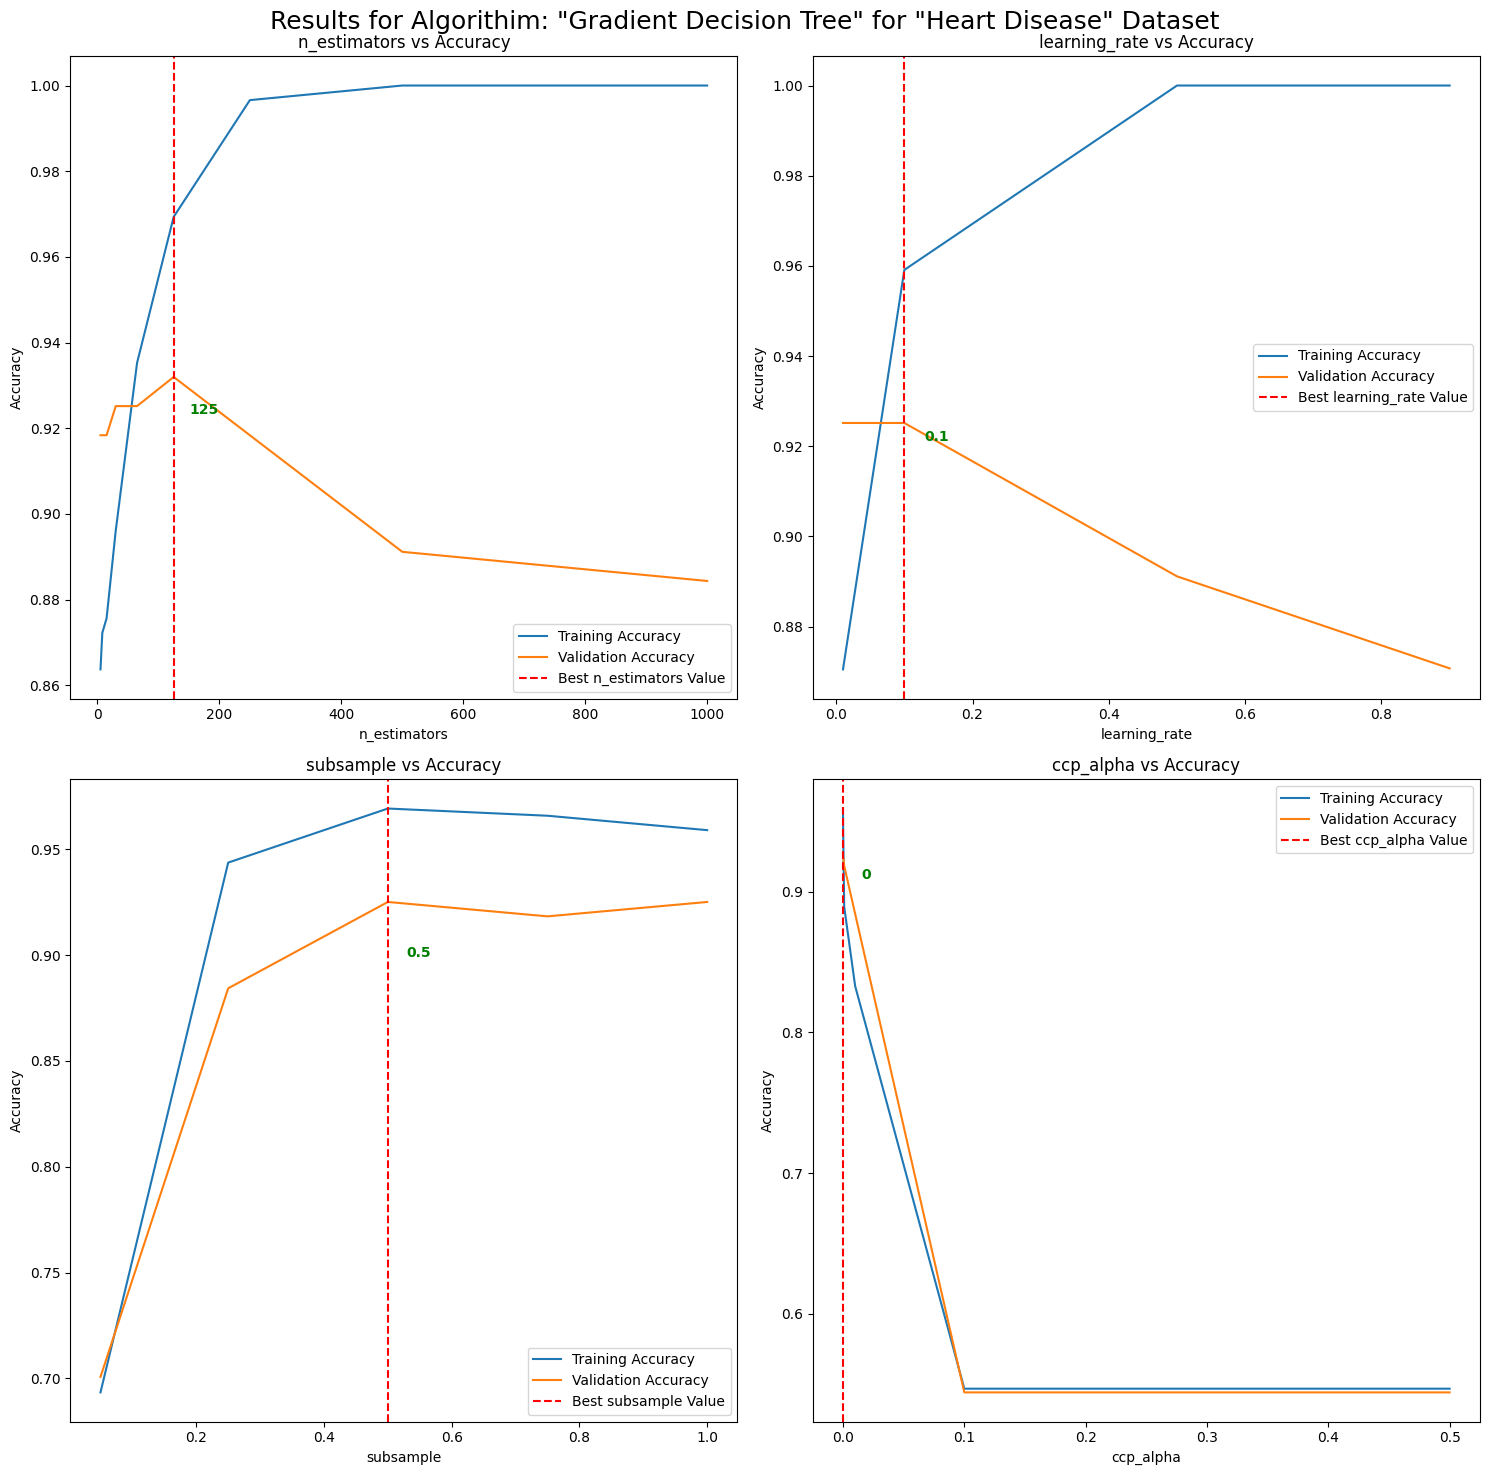

In [87]:
#Gradient Boosted Heart Accuracy
n_estimators_log=[1000,500,250,125,65,30,15,8,5]
learning_rates=[0.9,0.5,0.1,0.01]
subsample_vals=[0.05,0.25,0.5,0.75,1.0]
ccp_alphas=[0,0.0001,0.001,0.01,0.1,0.5]


param_dicts={'n_estimators':n_estimators_log,'learning_rate':learning_rates,'subsample':subsample_vals,'ccp_alpha':ccp_alphas}
deal_algorithim(train_heart,valid_heart,param_dicts,'Heart Disease','Gradient Decision Tree',GradientBoostingClassifier)

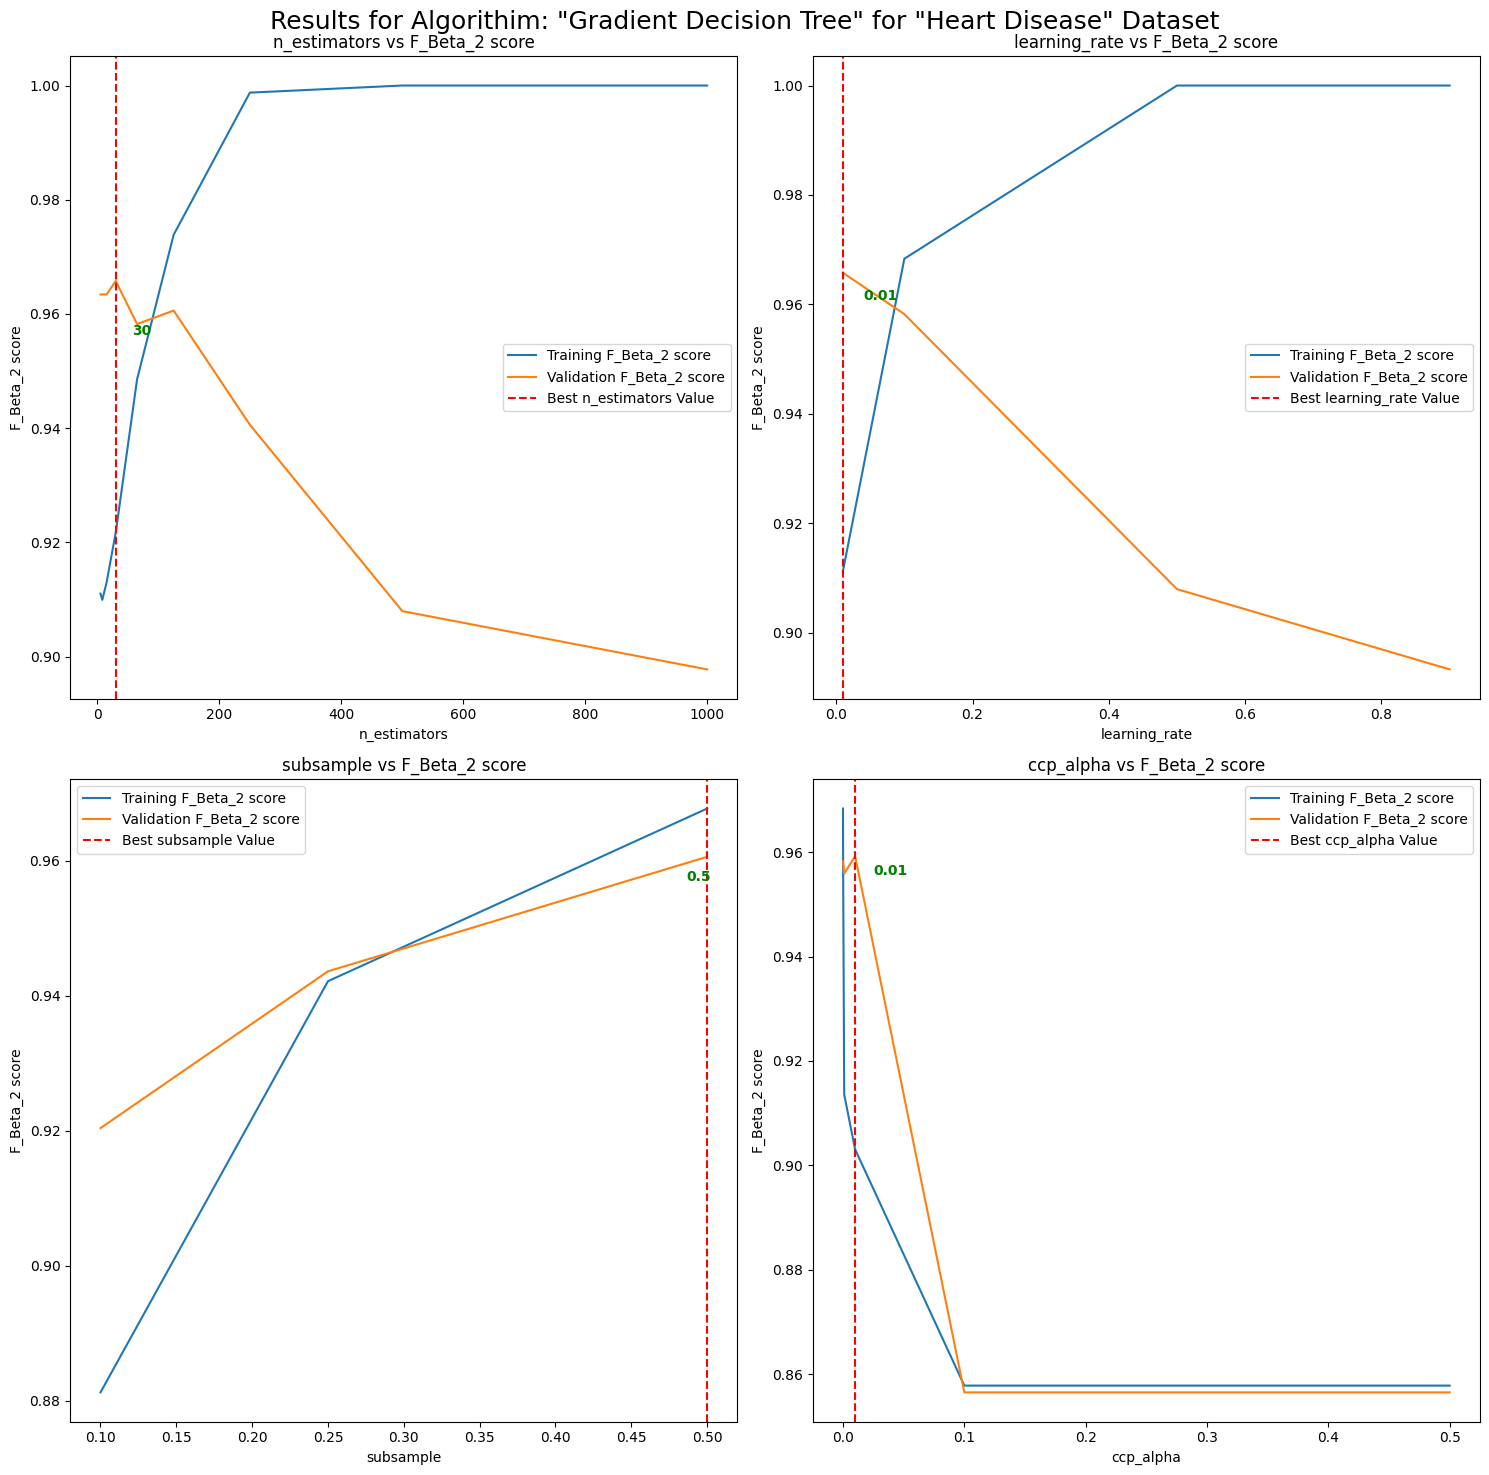

In [33]:
#Gradient Boosted Heart FTwo
param_dicts={'n_estimators':n_estimators_log,'learning_rate':learning_rates,'subsample':subsample_vals,'ccp_alpha':ccp_alphas}
deal_algorithim(train_heart,valid_heart,param_dicts,'Heart Disease','Gradient Decision Tree',GradientBoostingClassifier,fbeta_score,'F_Beta_2 score')

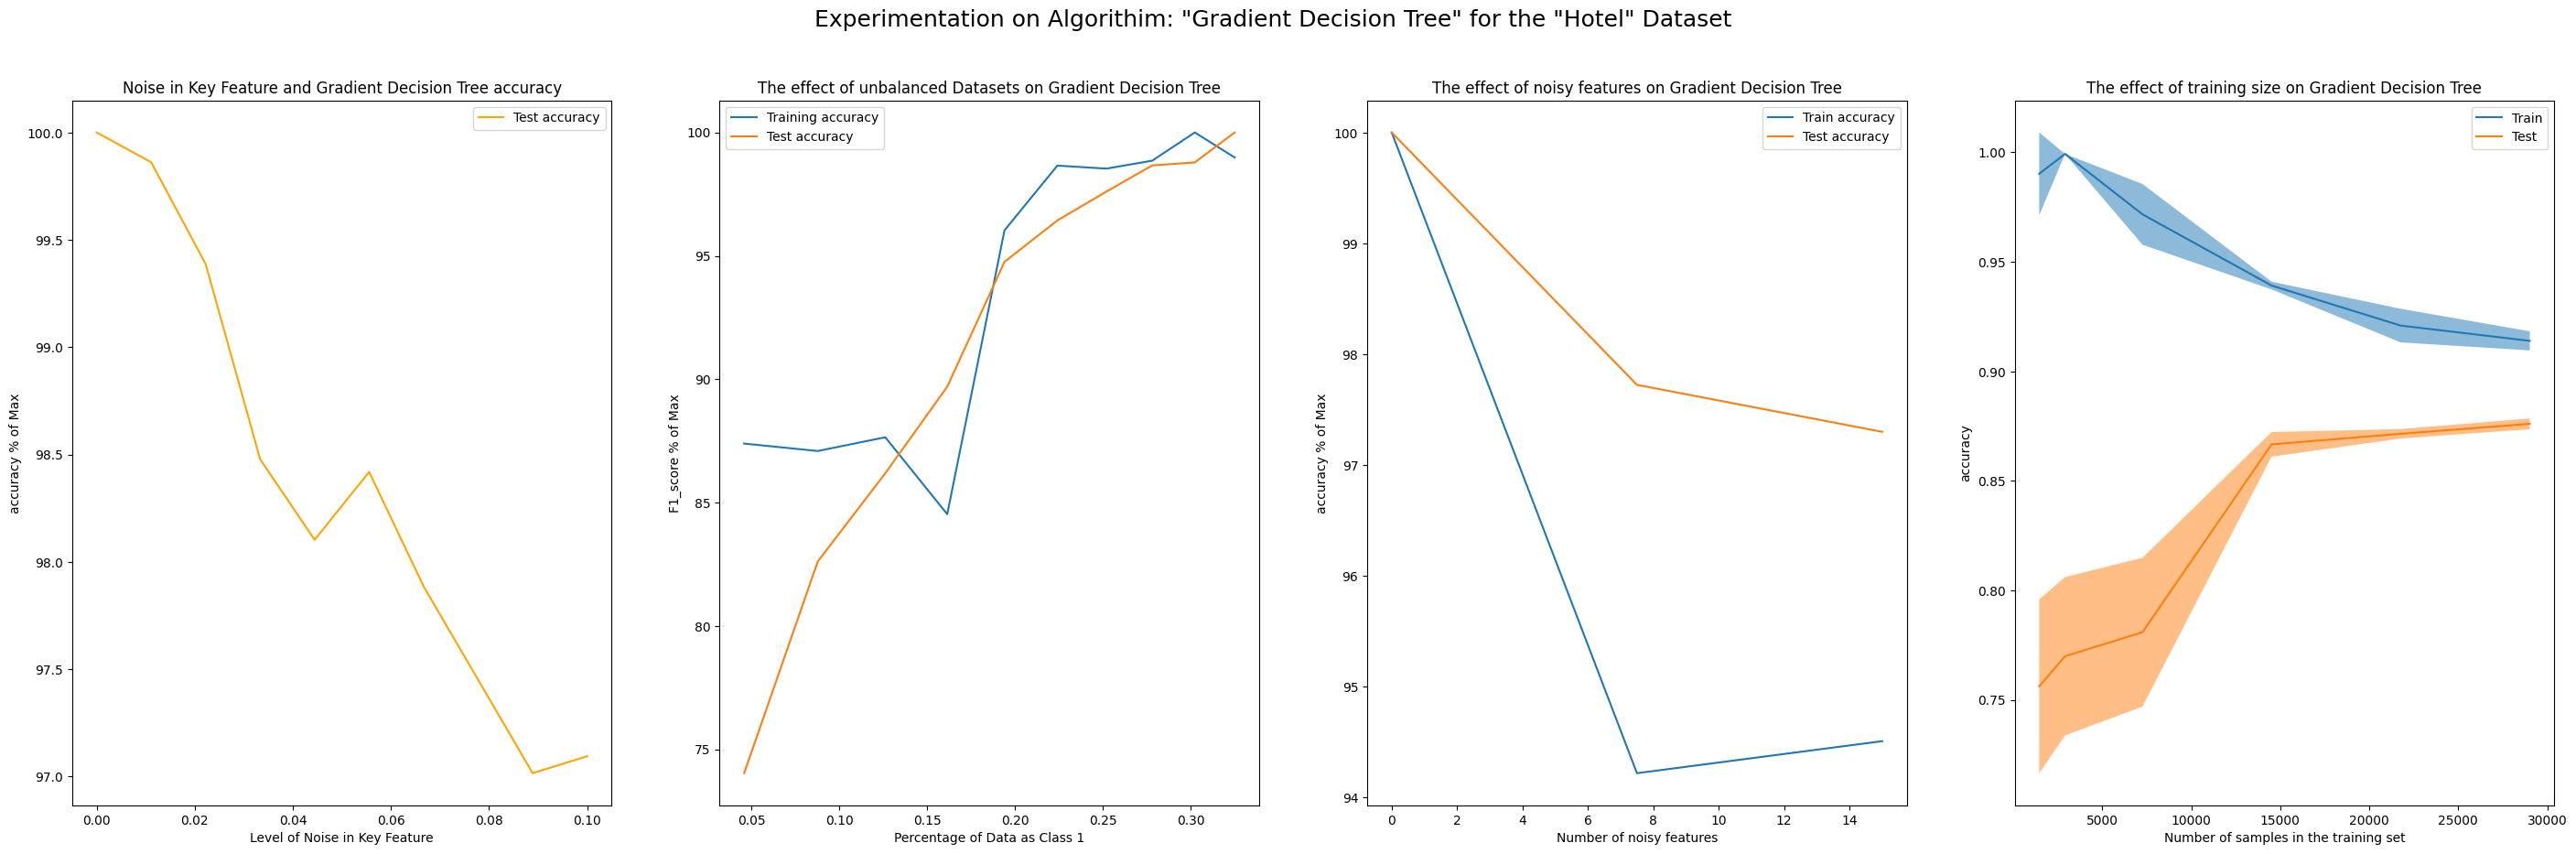

In [101]:
#Gradient Boosted Hotel Experimentation
n_estimators_log=[1000,500]
learning_rates=[0.5,0.25]
subsample_vals=[0.25,0.5]
ccp_alphas=[0,0.0001,0.001]

param_dicts={'n_estimators':n_estimators_log,'learning_rate':learning_rates,'subsample':subsample_vals,'ccp_alpha':ccp_alphas}
experiment_algorithim(train=train_hotel,test=valid_hotel,X=X_hotel,Y=Y_hotel,params=param_dicts,dataset='Hotel',col_index=col_index_hotel,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,algorithim_name='Gradient Decision Tree',algorithim=GradientBoostingClassifier(),predictor_metric_name='accuracy',search=True,LD_scoring=ld_accuracy_scorer())

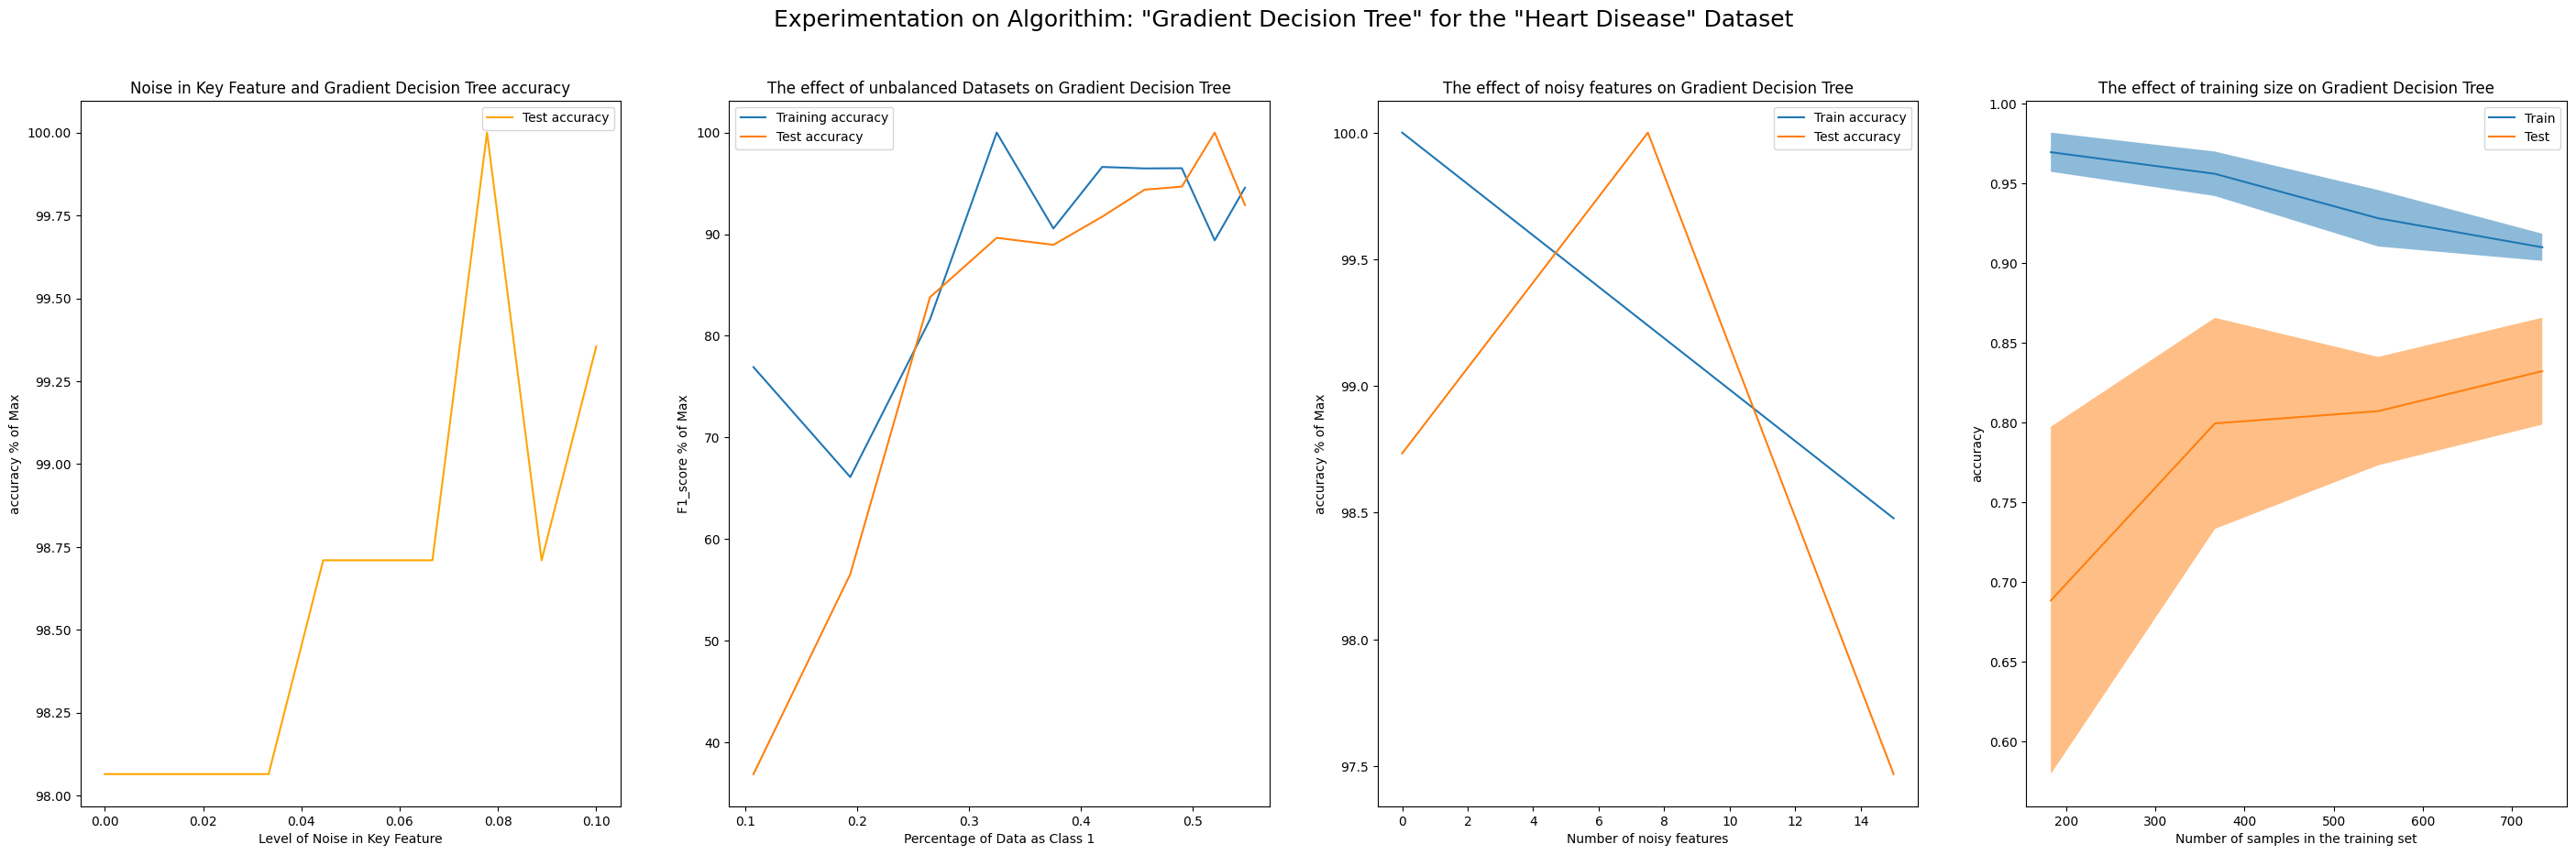

In [102]:
#Heart Accuracy Score Experimentation
n_estimators_log=[25,50,100]
learning_rates=[0.01,0.1,0.25]
subsample_vals=[0.25,0.5]
ccp_alphas=[0,0.0001,0.001]

param_dicts={'n_estimators':n_estimators_log,'learning_rate':learning_rates,'subsample':subsample_vals,'ccp_alpha':ccp_alphas}
experiment_algorithim(train=train_heart,test=test_heart,X=X_heart,Y=Y_heart,params=param_dicts,dataset='Heart Disease',col_index=col_index_heart,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,algorithim_name='Gradient Decision Tree',algorithim=GradientBoostingClassifier(),predictor_metric_name='accuracy',search=True,LD_scoring=ld_accuracy_scorer())

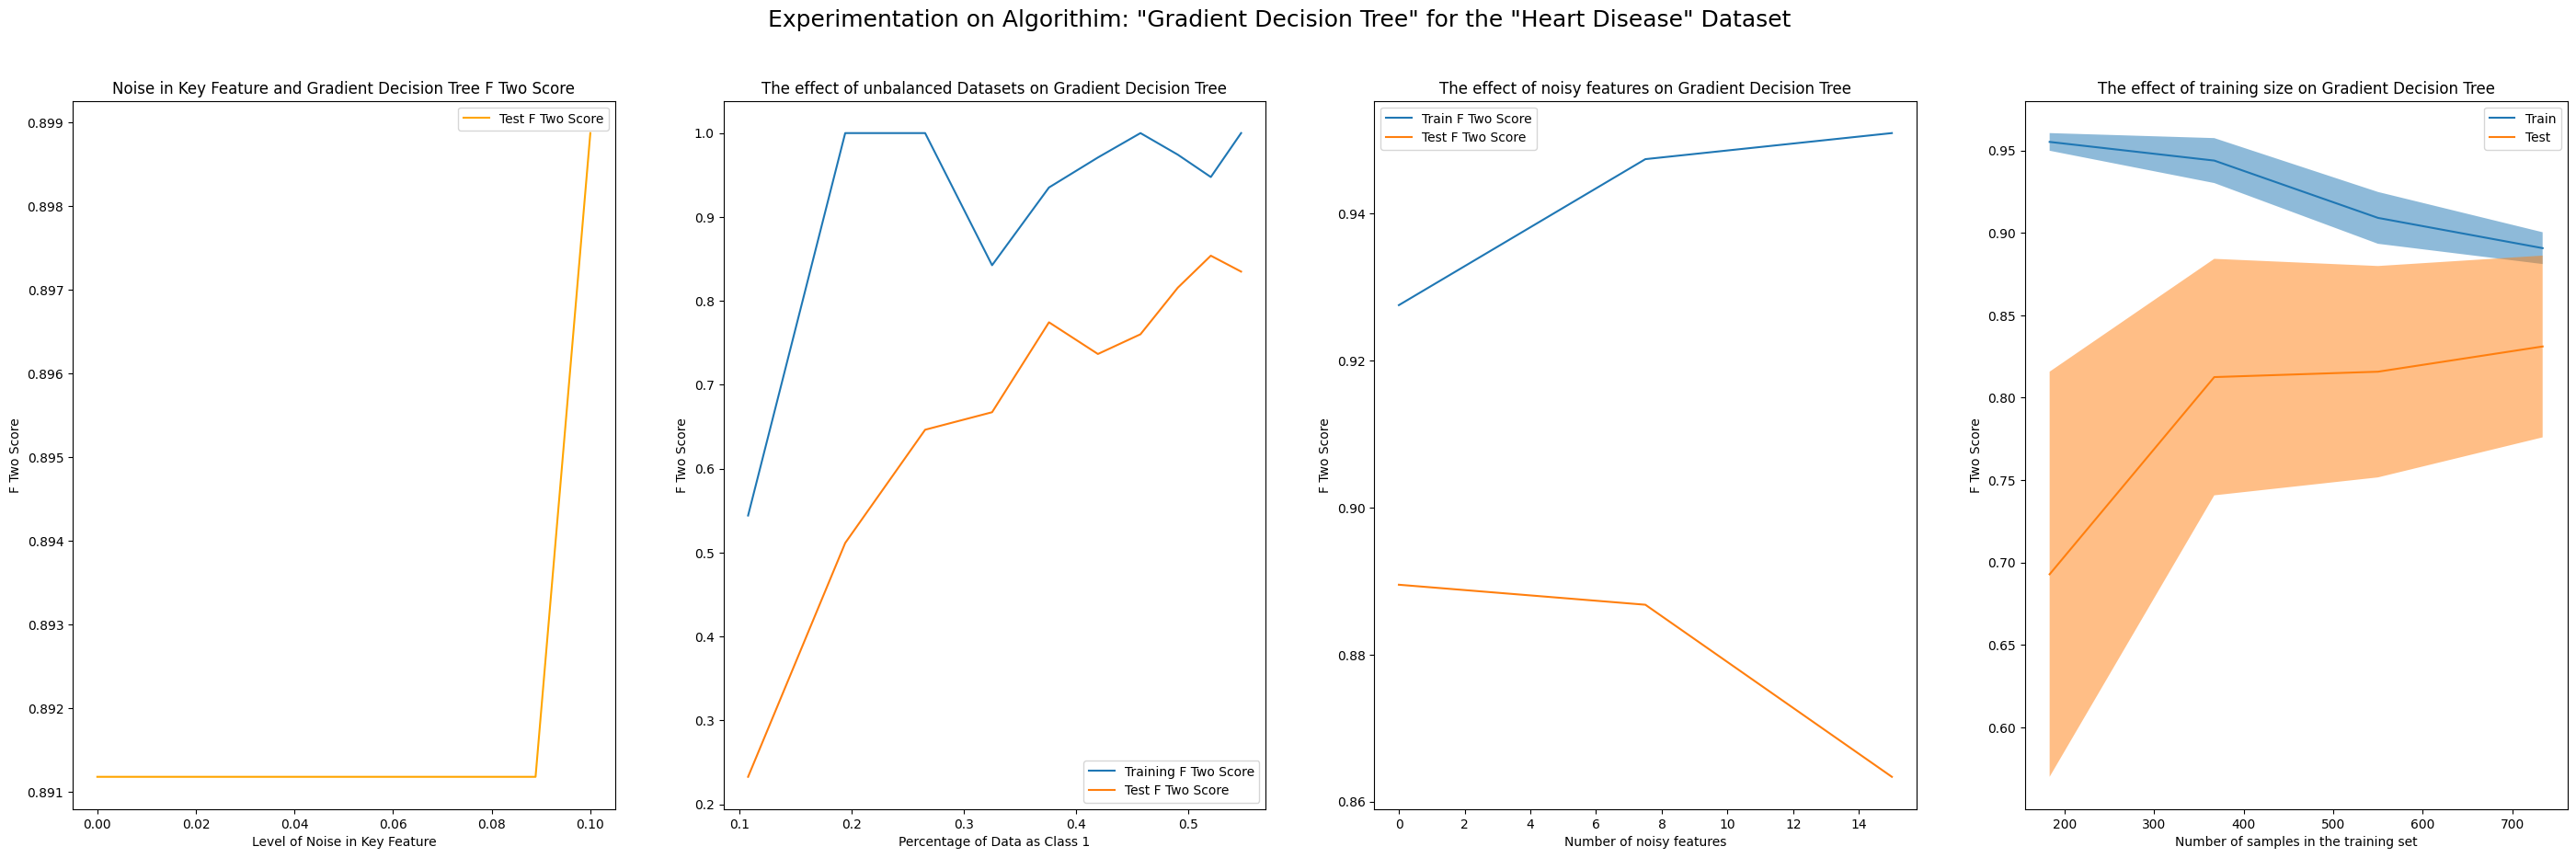

In [ ]:
#Heart Ftwo score
n_estimators_log=[500,250,125]
learning_rates=[0.9,0.5,0.1,0.01]
subsample_vals=[0.5,0.25,0.1]
#ccp_alphas=[0,0.00001,0.0001,0.001,0.01,0.1,0.5]

param_dicts={'n_estimators':n_estimators_log,'learning_rate':learning_rates,'subsample':subsample_vals}
experiment_algorithim(train=train_heart,test=test_heart,X=X_heart,Y=Y_heart,params=param_dicts,dataset='Heart Disease',col_index=col_index_heart,predictor_metric=fbeta_score,grid_search_metric=ftwo_scorer,algorithim_name='Gradient Decision Tree',algorithim=GradientBoostingClassifier(),predictor_metric_name='F Two Score',search=True,LD_scoring=ld_ftwo_scorer())

In [92]:
#Hotel Scoring
n_estimators_log=[1000,500]
learning_rates=[0.5,0.25]
subsample_vals=[0.25,0.5]
ccp_alphas=[0,0.0001,0.001]

param_dicts={'n_estimators':n_estimators_log,'learning_rate':learning_rates,'subsample':subsample_vals,'ccp_alpha':ccp_alphas}
score_algorithim(X=X_hotel,Y=Y_hotel,dataset_name='Hotel Dataset',algorithim_name='Gradient Decision Tree Classifier',algorithim=GradientBoostingClassifier(),params=param_dicts,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy')

Hotel Dataset Final Results


{'ccp_alpha': 0, 'learning_rate': 0.25, 'n_estimators': 500, 'subsample': 0.5}


Average time to train the ideal Gradient Decision Tree Classifier was 12.645 seconds
Average time to infer the ideal Gradient Decision Tree Classifier was 0.033 seconds


The result on the training data for the ideal Gradient Decision Tree Classifier algorithim is a 0.899724328049621 accuracy score
The result on the test data for the ideal Gradient Decision Tree Classifier algorithim is a 0.8727773949000689 accuracy score


In [93]:
#Heart Disease Scoring Accuracy
n_estimators_log=[25,50,100]
learning_rates=[0.01,0.1,0.25]
subsample_vals=[0.25,0.5]
ccp_alphas=[0,0.0001,0.001]

param_dicts={'n_estimators':n_estimators_log,'learning_rate':learning_rates,'subsample':subsample_vals,'ccp_alpha':ccp_alphas}
score_algorithim(X=X_heart,Y=Y_heart,dataset_name='Heart Disease Dataset',algorithim_name='Gradient Decision Tree',algorithim=GradientBoostingClassifier(),params=param_dicts,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy')

Heart Disease Dataset Final Results


{'ccp_alpha': 0.0001, 'learning_rate': 0.1, 'n_estimators': 50, 'subsample': 0.5}


Average time to train the ideal Gradient Decision Tree was 0.139 seconds
Average time to infer the ideal Gradient Decision Tree was 0.000 seconds


The result on the training data for the ideal Gradient Decision Tree algorithim is a 0.9196185286103542 accuracy score
The result on the test data for the ideal Gradient Decision Tree algorithim is a 0.8967391304347826 accuracy score


In [37]:
#Heart Disease Scoring FTwo
param_dicts={'n_estimators':n_estimators_log,'learning_rate':learning_rates,'subsample':subsample_vals}
score_algorithim(X=X_heart,Y=Y_heart,dataset_name='Heart Disease Dataset',algorithim_name='Gradient Decision Tree',algorithim=GradientBoostingClassifier(),params=param_dicts,predictor_metric=fbeta_score,grid_search_metric=accuracy_scorer,predictor_metric_name='F Two Score')

Heart Disease Dataset Final Results


{'learning_rate': 0.01, 'n_estimators': 250, 'subsample': 0.5}


Average time to train the ideal Gradient Decision Tree was 0.528 seconds
Average time to infer the ideal Gradient Decision Tree was 0.001 seconds


The result on the training data for the ideal Gradient Decision Tree algorithim is a 0.9305760709010341 F Two Score score
The result on the test data for the ideal Gradient Decision Tree algorithim is a 0.8945386064030131 F Two Score score


### KNN Classifier

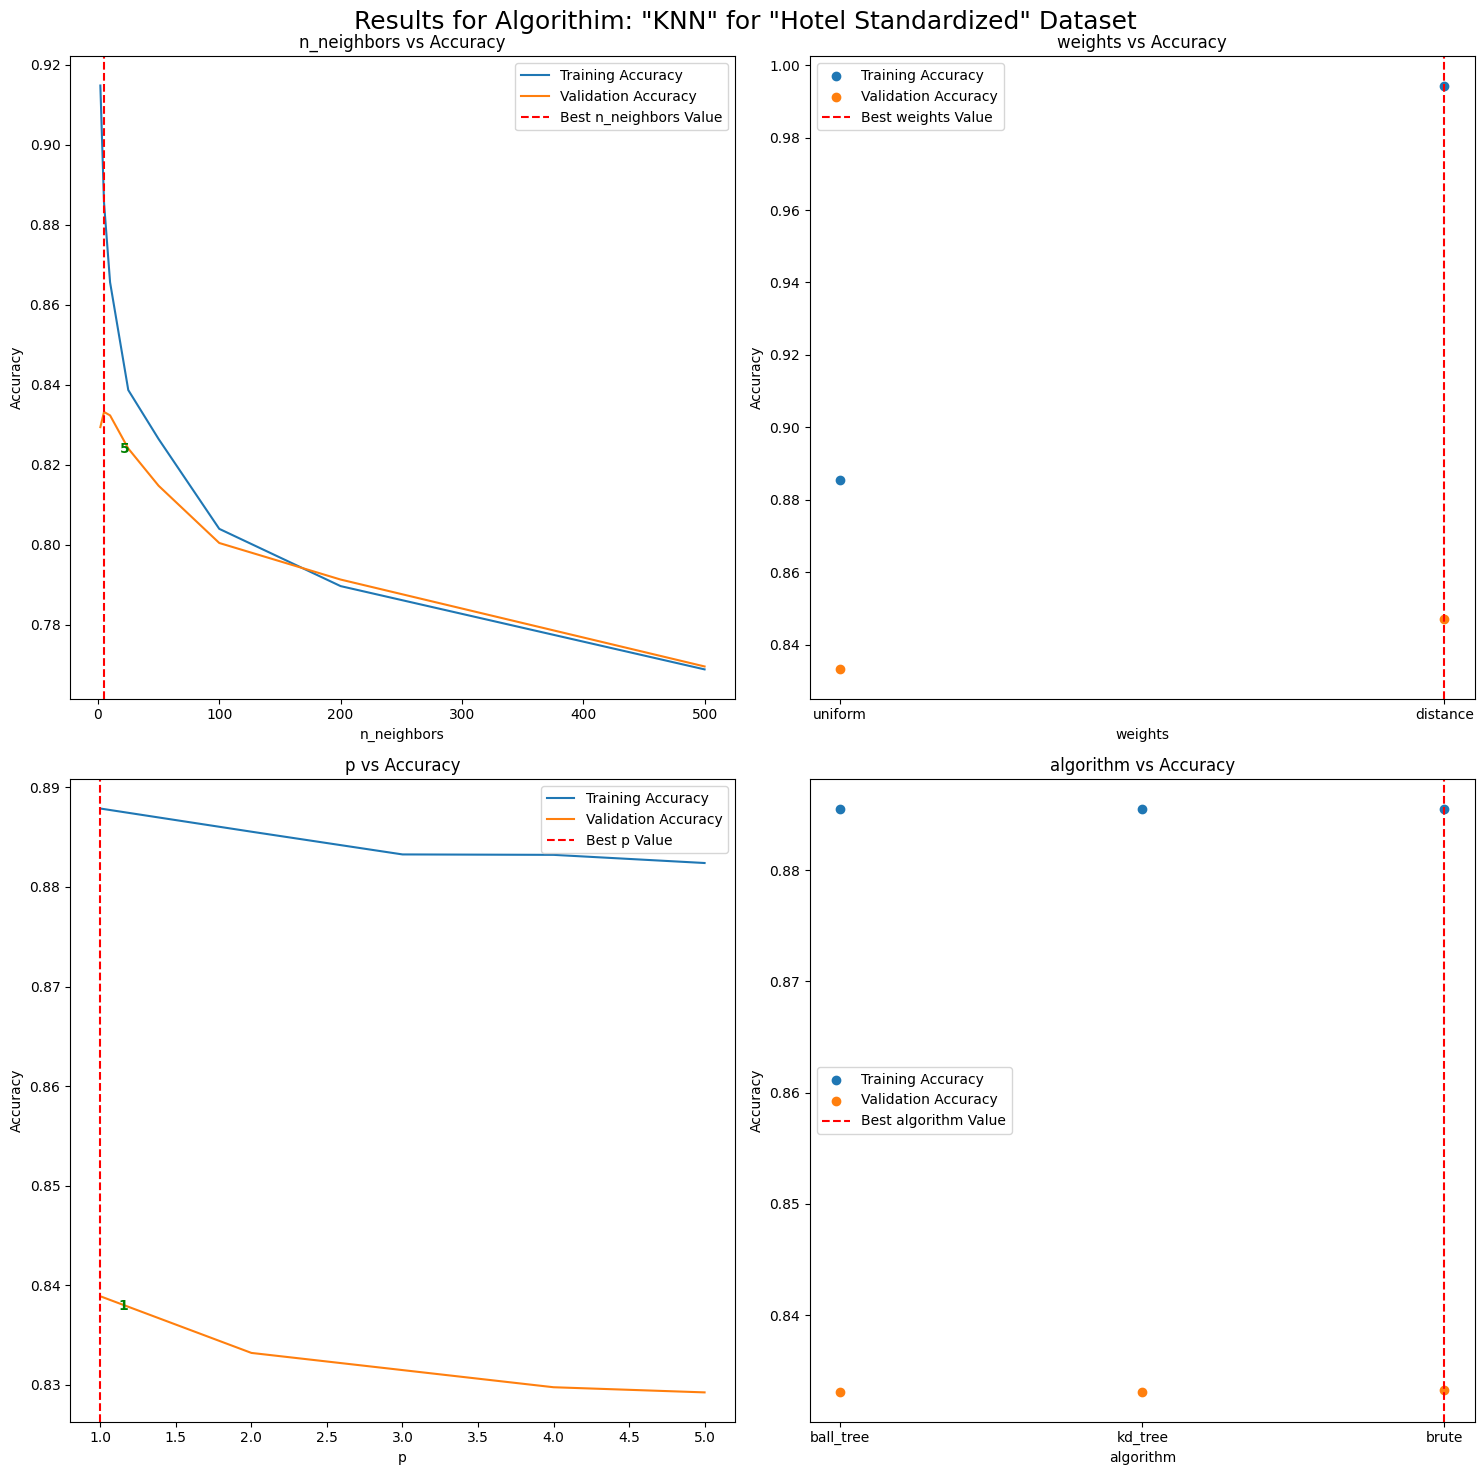

In [38]:
#Hotel Data Standardized

X_hotel,Y_hotel,col_index_hotel=load_hotel()
train_hotel_standardized,valid_hotel_standardized,test_hotel_standardized=split_data(X_hotel,Y_hotel,standardize=True)
train_hotel_unstandardized,valid_hotel_unstandardized,test_hotel_unstandardized=split_data(X_hotel,Y_hotel,standardize=False)

param_dicts={'n_neighbors':[2,5,10,25,50,100,200,500],'weights':['uniform','distance'],'p':[1,2,3,4,5],'algorithm':['ball_tree','kd_tree','brute']}
deal_algorithim(train_hotel_standardized,valid_hotel_standardized,param_dicts,'Hotel Standardized','KNN',KNeighborsClassifier)

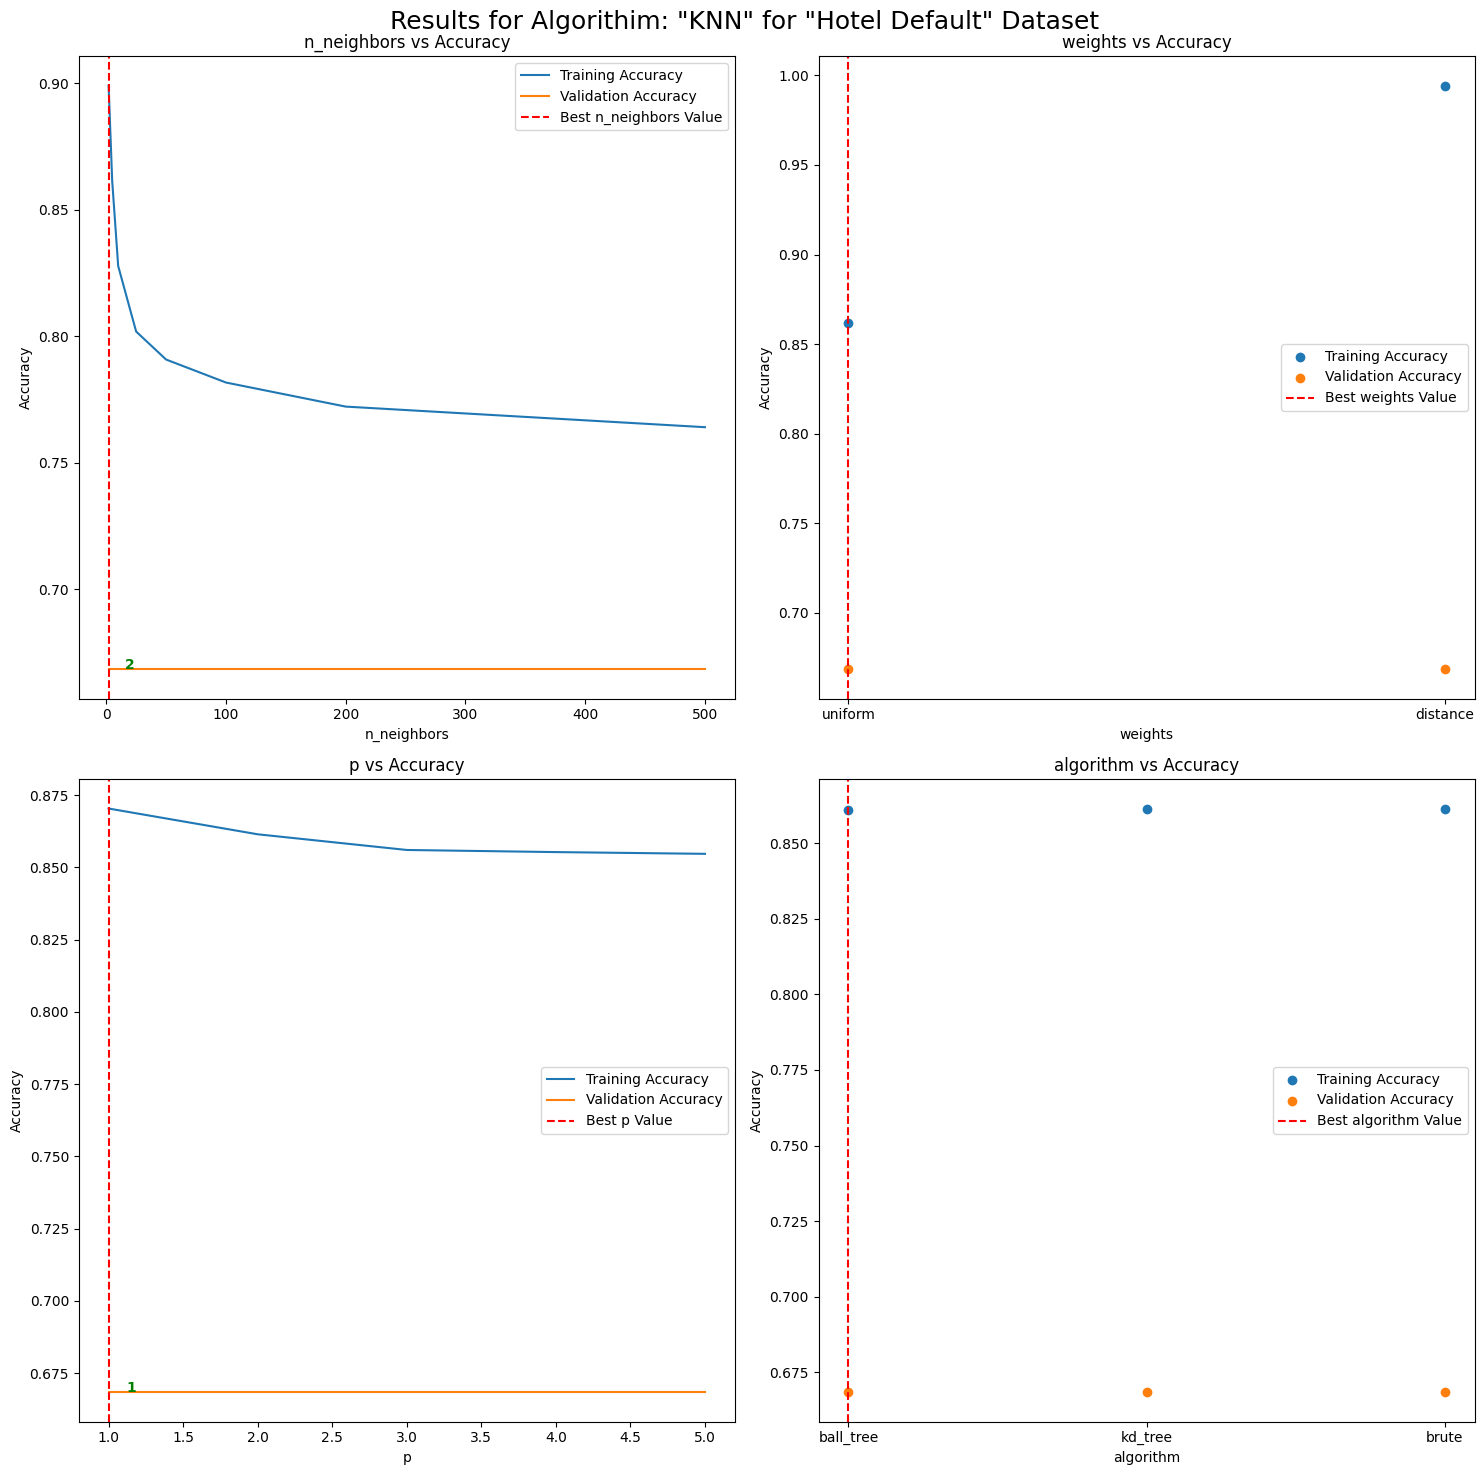

In [39]:
#Unstandarized
param_dicts={'n_neighbors':[2,5,10,25,50,100,200,500],'weights':['uniform','distance'],'p':[1,2,3,4,5],'algorithm':['ball_tree','kd_tree','brute']}
deal_algorithim(train_hotel_unstandardized,valid_hotel_standardized,param_dicts,'Hotel Default','KNN',KNeighborsClassifier)

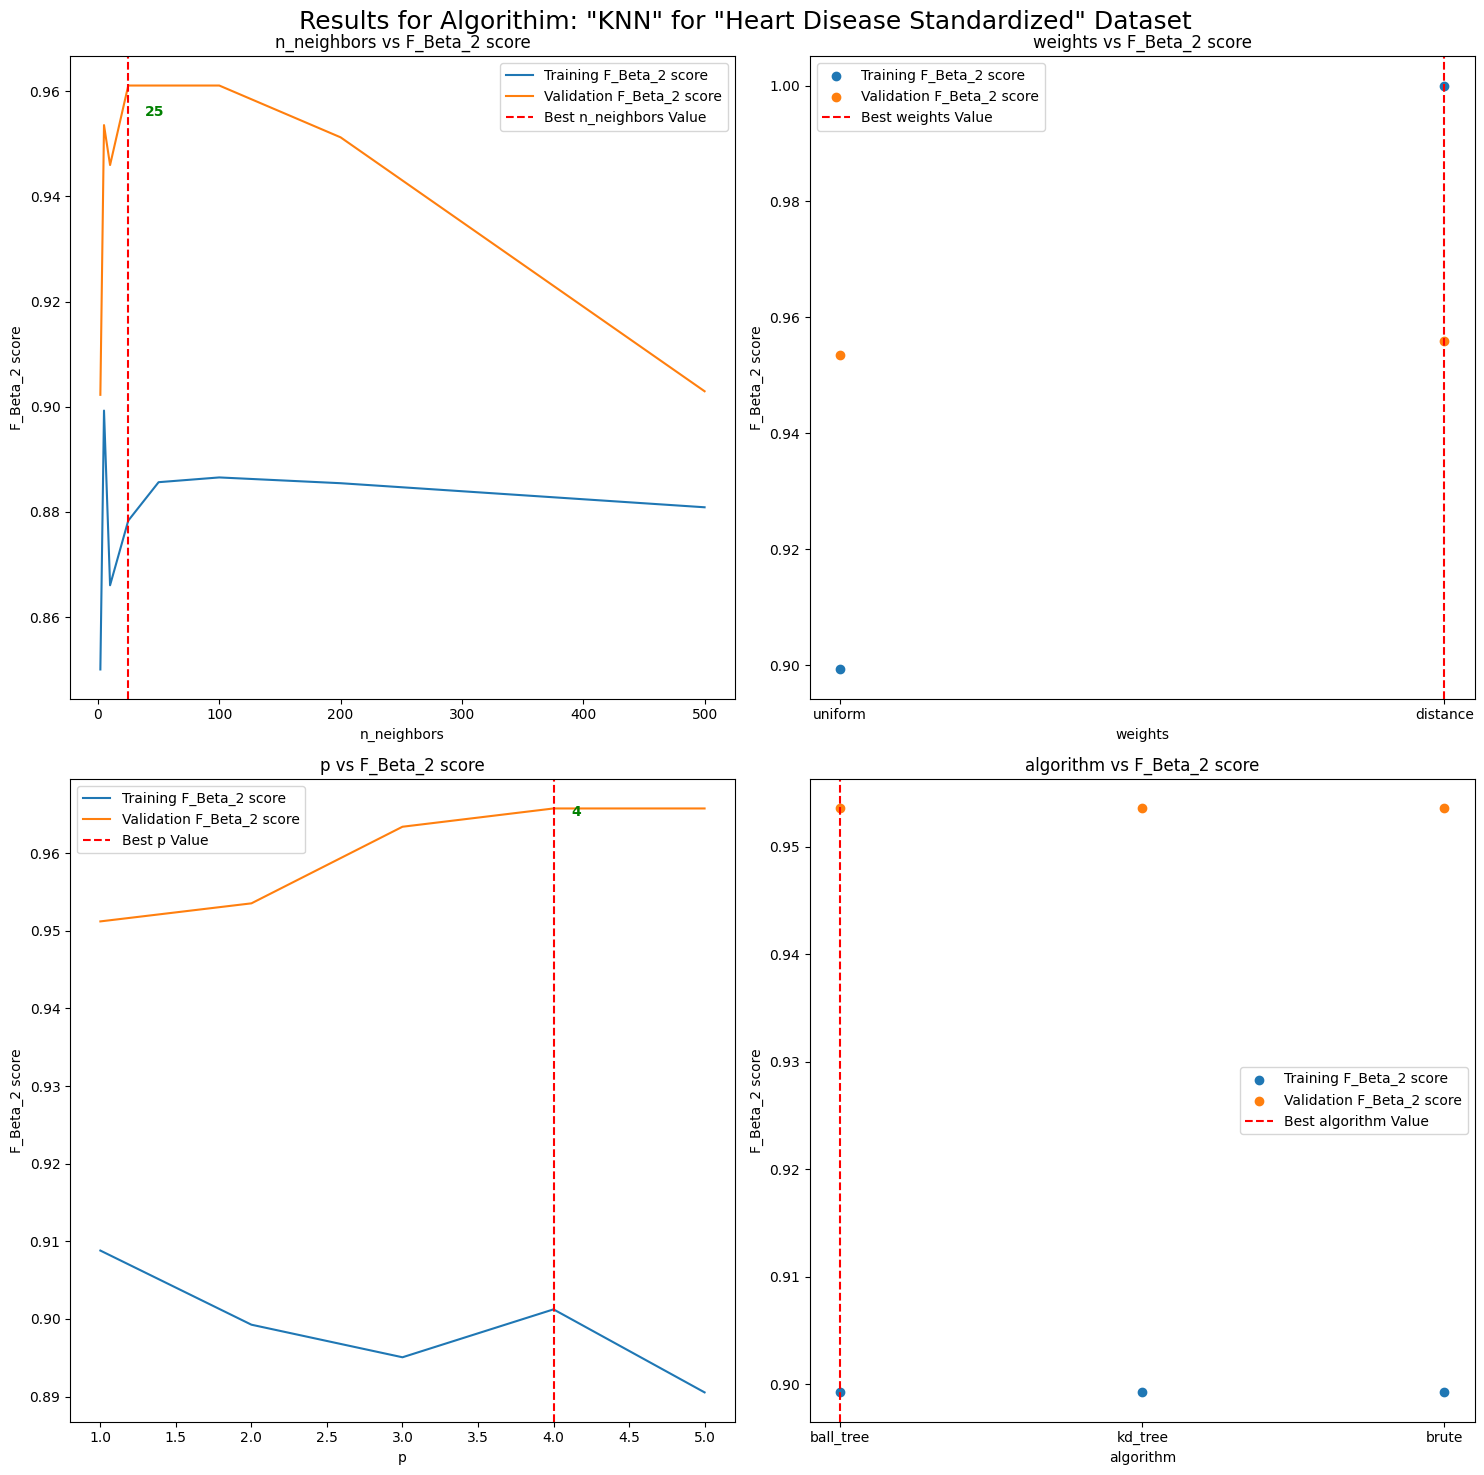

In [40]:
#Heart Data
X_heart,Y_heart,col_index_heart=load_heart_data()
train_heart_standardized,valid_heart_standardized,test_heart_standardized=split_data(X_heart,Y_heart,standardize=True)
train_heart_unstandardized,valid_heart_unstandardized,test_heart_unstandardized=split_data(X_heart,Y_heart,standardize=True)

param_dicts={'n_neighbors':[2,5,10,25,50,100,200,500],'weights':['uniform','distance'],'p':[1,2,3,4,5],'algorithm':['ball_tree','kd_tree','brute']}
deal_algorithim(train_heart_standardized,valid_heart_standardized,param_dicts,'Heart Disease Standardized','KNN',KNeighborsClassifier,fbeta_score,'F_Beta_2 score')

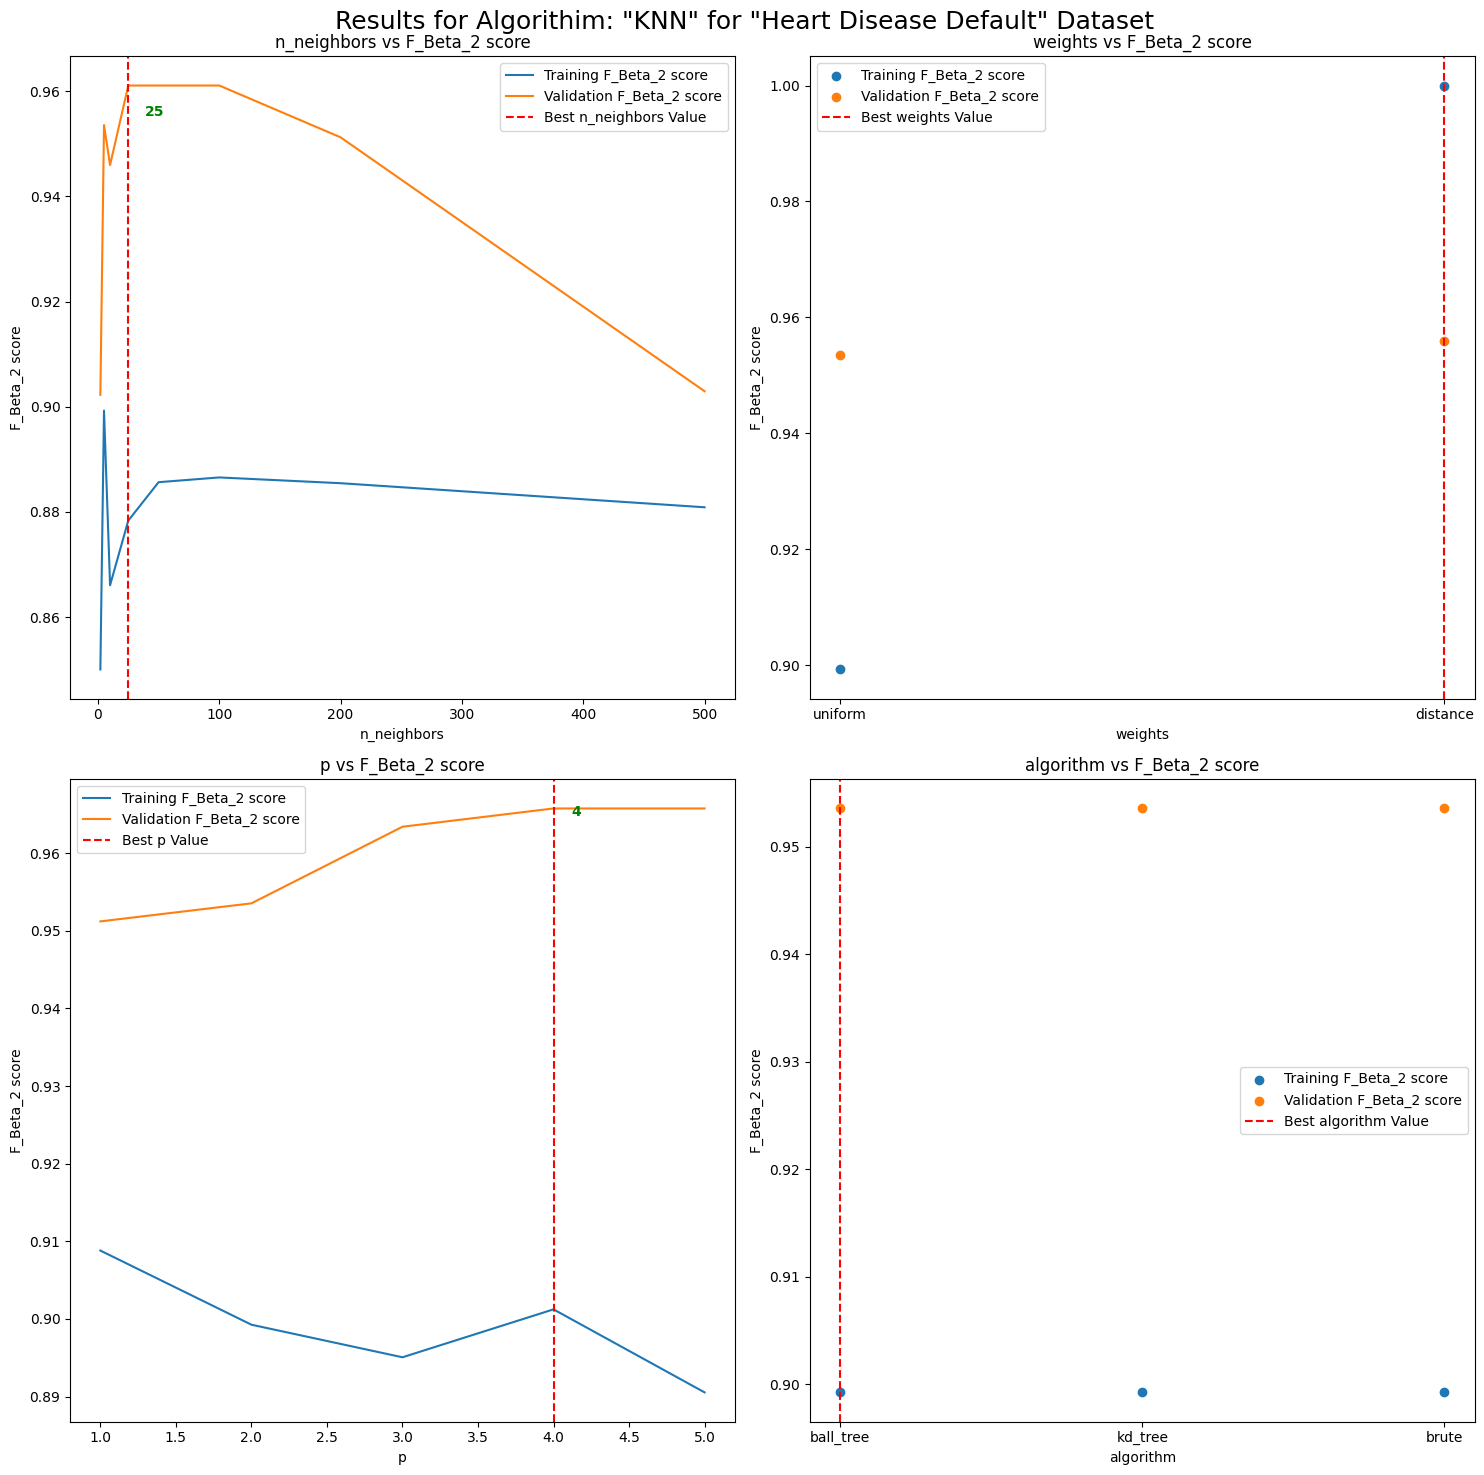

In [41]:
#Unstandardized
param_dicts={'n_neighbors':[2,5,10,25,50,100,200,500],'weights':['uniform','distance'],'p':[1,2,3,4,5],'algorithm':['ball_tree','kd_tree','brute']}
deal_algorithim(train_heart_unstandardized,valid_heart_unstandardized,param_dicts,'Heart Disease Default','KNN',KNeighborsClassifier,fbeta_score,'F_Beta_2 score')

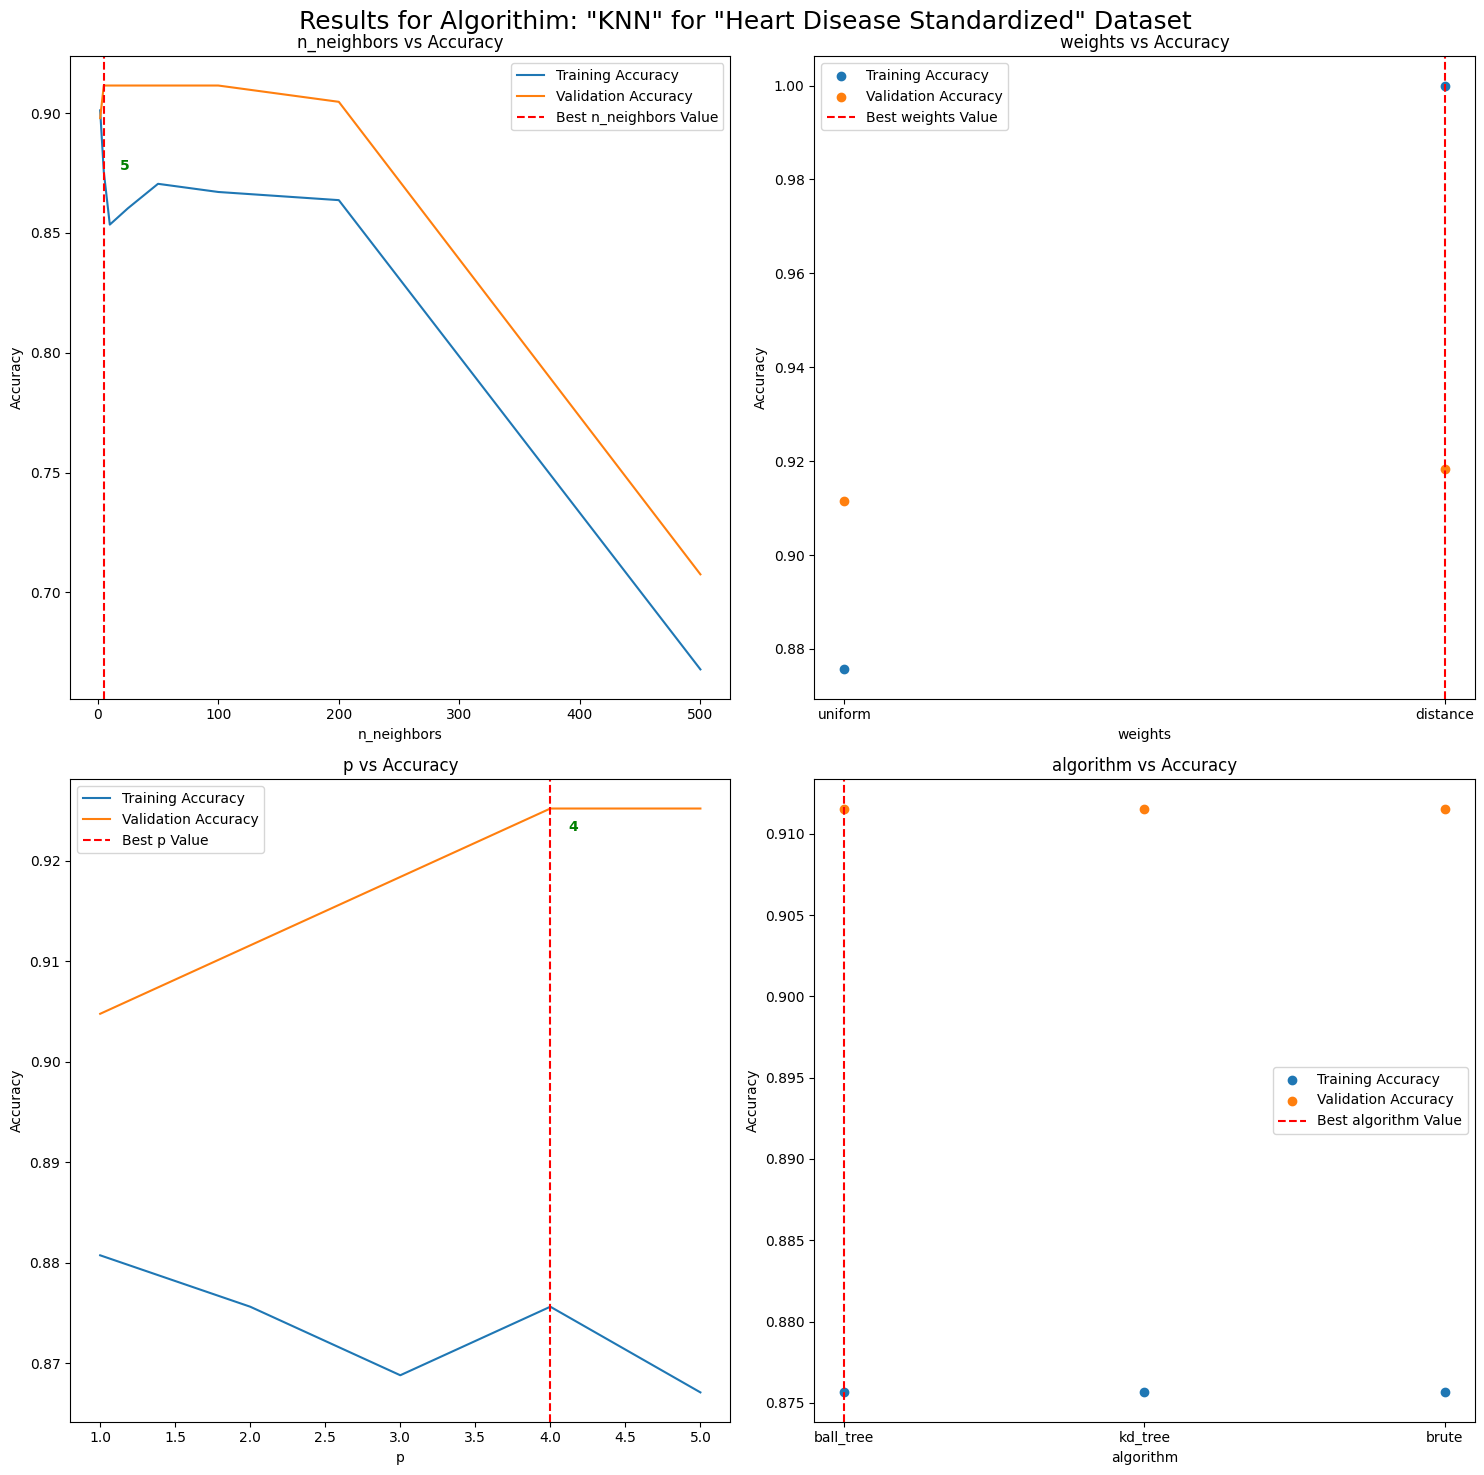

In [94]:
#Heart Data Accuracy Score Standardized

X_heart,Y_heart,col_index_heart=load_heart_data()
train_heart_standardized,valid_heart_standardized,test_heart_standardized=split_data(X_heart,Y_heart,standardize=True)
train_heart_unstandardized,valid_heart_unstandardized,test_heart_unstandardized=split_data(X_heart,Y_heart,standardize=True)

param_dicts={'n_neighbors':[2,5,10,25,50,100,200,500],'weights':['uniform','distance'],'p':[1,2,3,4,5],'algorithm':['ball_tree','kd_tree','brute']}
deal_algorithim(train_heart_standardized,valid_heart_standardized,param_dicts,'Heart Disease Standardized','KNN',KNeighborsClassifier)

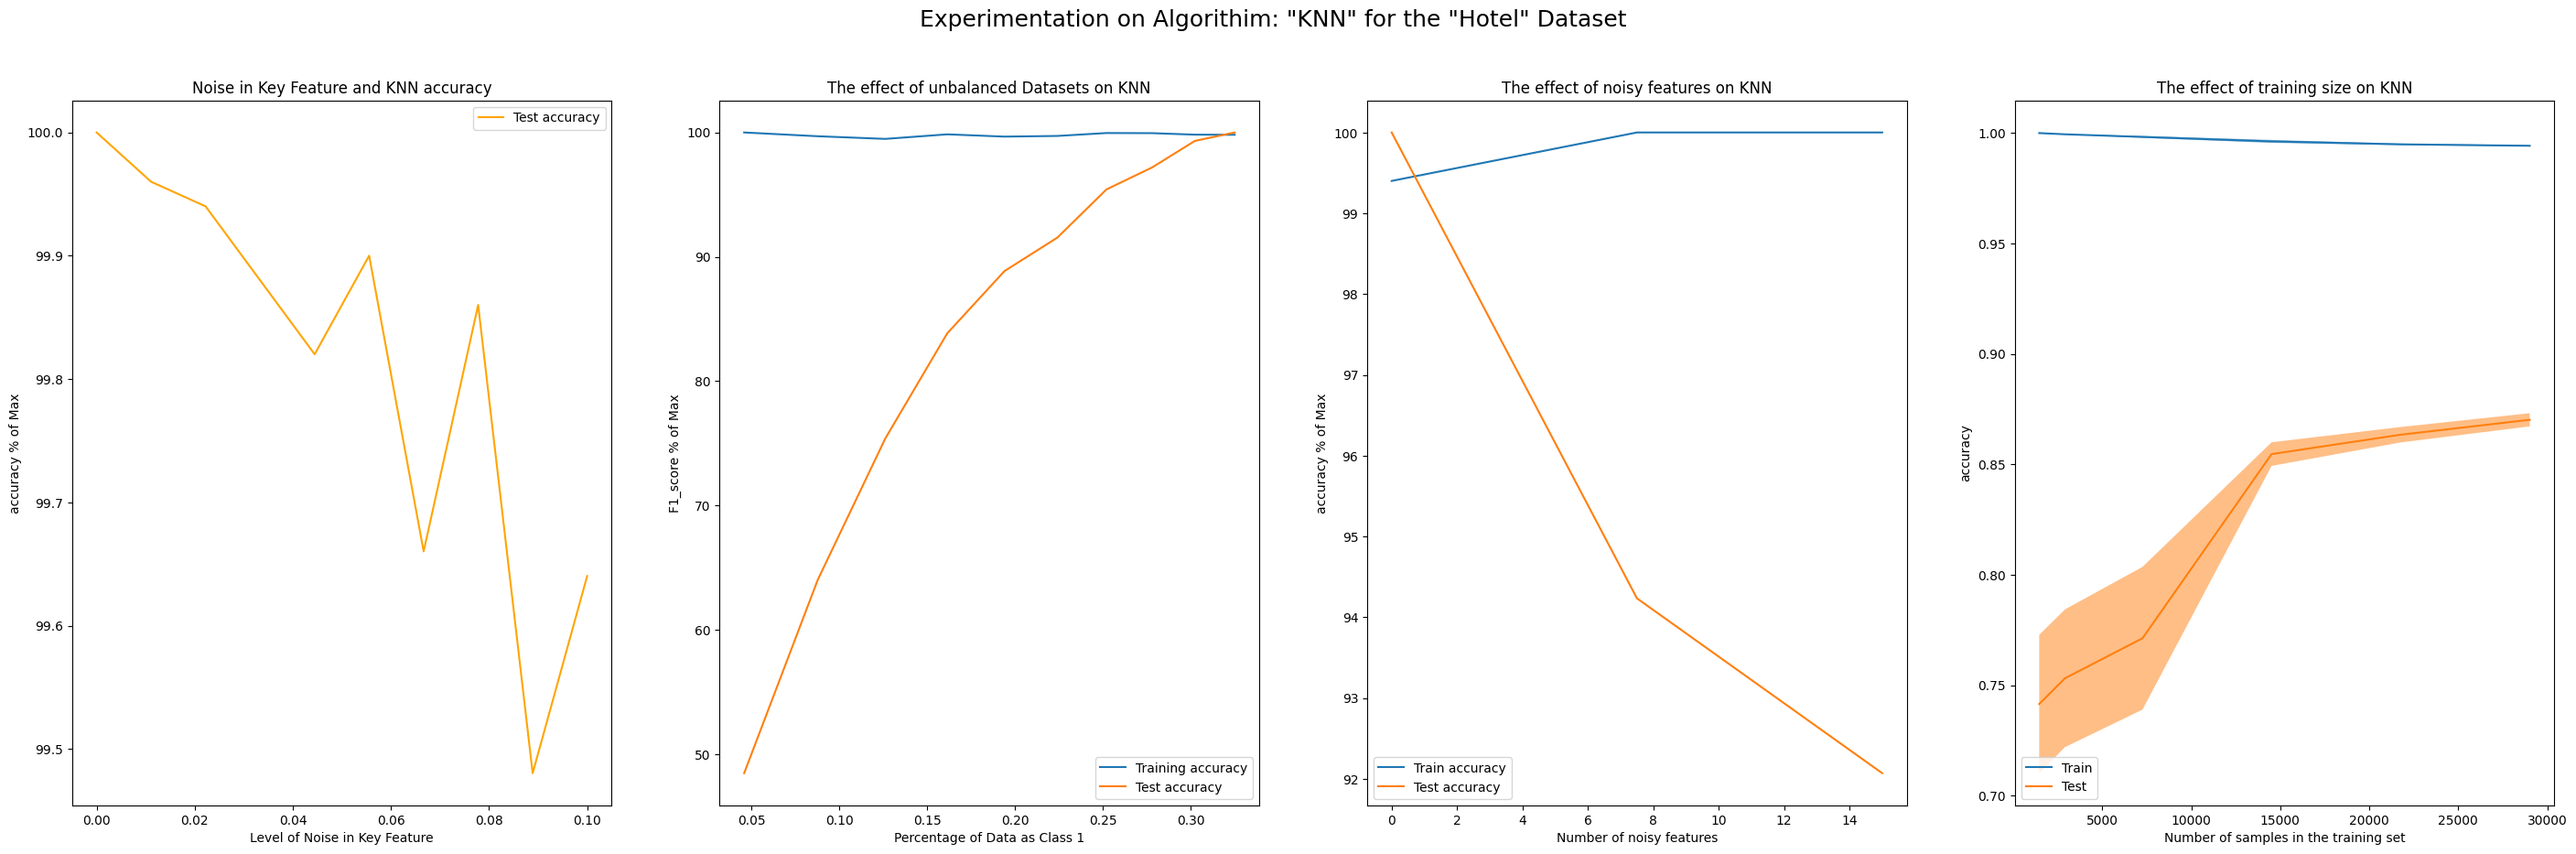

In [103]:
#Experimenting Hotel Dataset 
param_dicts={'n_neighbors':[5,10,25],'weights':['distance'],'p':[1]}

experiment_algorithim(train=train_hotel_standardized,test=valid_hotel_standardized,X=X_hotel,Y=Y_hotel,params=param_dicts,dataset='Hotel',col_index=col_index_hotel,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,algorithim_name='KNN',algorithim=KNeighborsClassifier(),predictor_metric_name='accuracy',search=True,LD_scoring=ld_accuracy_scorer())

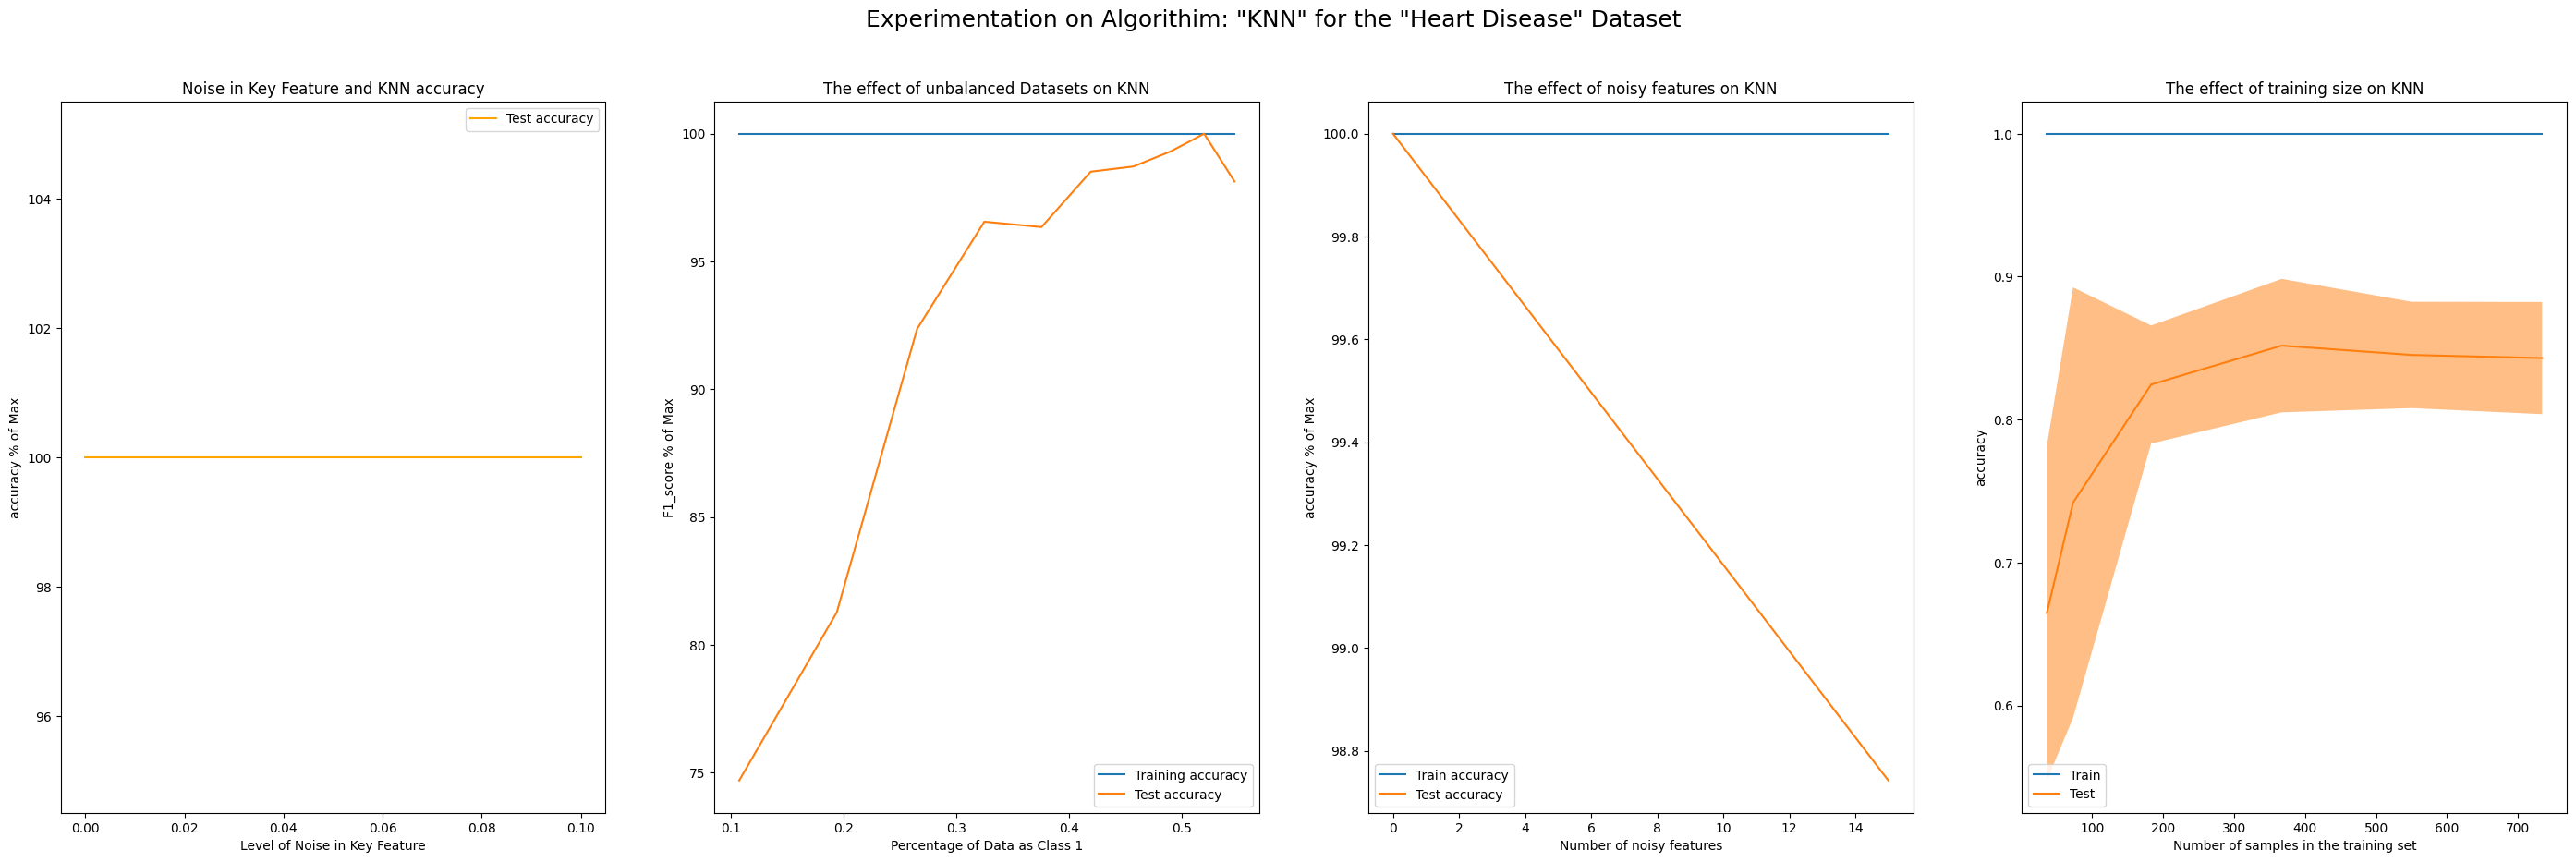

In [104]:
#Experimenting Heart Disease Dataset Accuracy
param_dicts={'n_neighbors':[5,10,25],'weights':['distance'],'p':[1,2,4]}

experiment_algorithim(train=train_heart_standardized,test=valid_heart_unstandardized,X=X_heart,Y=Y_heart,params=param_dicts,dataset='Heart Disease',col_index=col_index_heart,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,algorithim_name='KNN',algorithim=KNeighborsClassifier(),predictor_metric_name='accuracy',search=True,LD_scoring=ld_accuracy_scorer())

c:\Users\Admin\anaconda3\envs\ML_2\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Admin\anaconda3\envs\ML_2\lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_50164\3092630745.py", line 17, in __call__
    return fbeta_score(estimator.predict(X),y,beta=self.beta)
  File "c:\Users\Admin\anaconda3\envs\ML_2\lib\site-packages\sklearn\neighbors\_classification.py", line 254, in predict
    probabilities = self.predict_proba(X)
  File "c:\Users\Admin\anaconda3\envs\ML_2\lib\site-packages\sklearn\neighbors\_classification.py", line 355, in predict_proba
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "c:\Users\Admin\anaconda3\envs\ML_2\lib\site-packages\sklearn\neighb

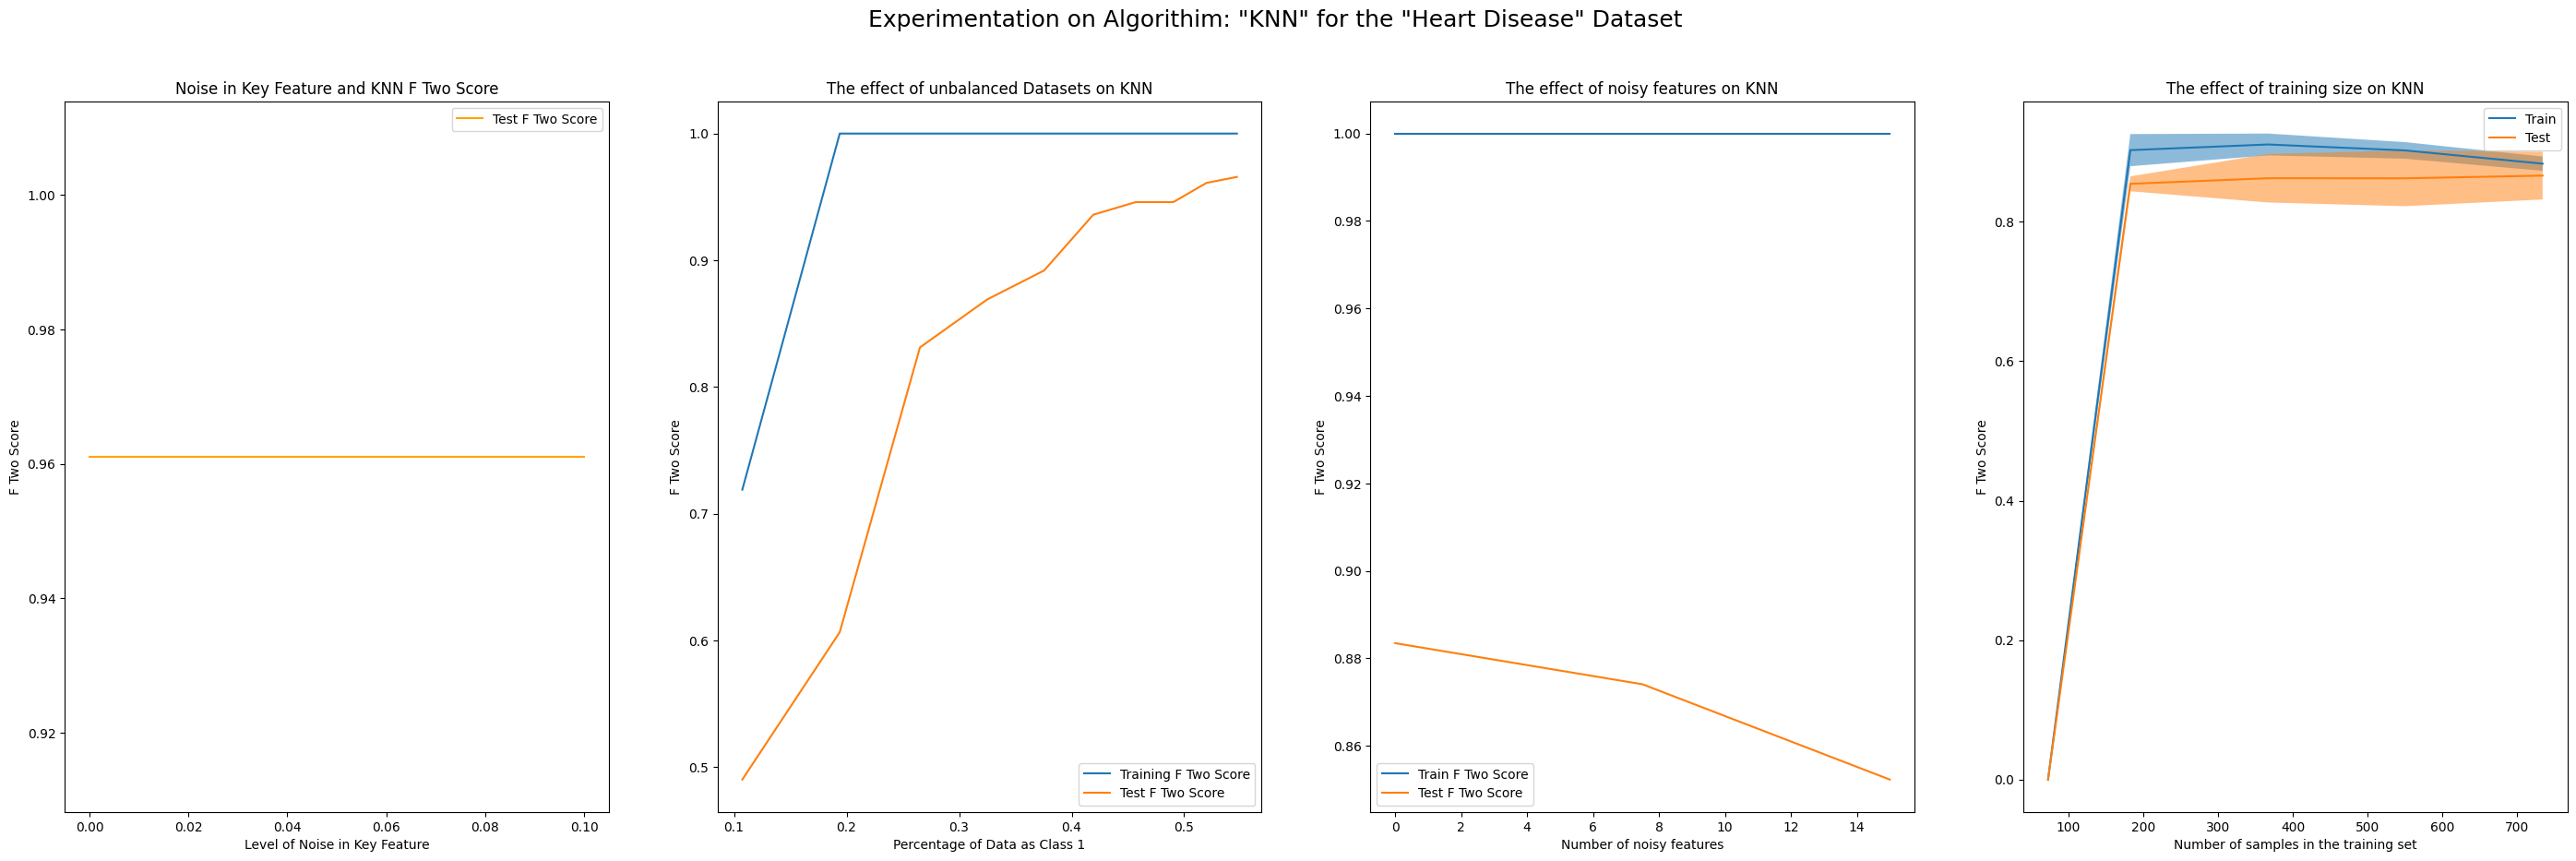

In [58]:
#Experimenting Heart Disease Dataset 
param_dicts={'n_neighbors':[5,10,25,50],'weights':['uniform','distance']}

experiment_algorithim(train=train_heart_standardized,test=valid_heart_unstandardized,X=X_heart,Y=Y_heart,params=param_dicts,dataset='Heart Disease',col_index=col_index_heart,predictor_metric=fbeta_score,grid_search_metric=ftwo_scorer,algorithim_name='KNN',algorithim=KNeighborsClassifier(),predictor_metric_name='F Two Score',search=True,LD_scoring=ld_ftwo_scorer())

In [105]:
#Final Hotel Dataset Results
param_dicts={'n_neighbors':[5,10,25],'weights':['distance'],'p':[1]}
score_algorithim(X=X_hotel,Y=Y_hotel,dataset_name='Hotel Dataset',algorithim_name='KNN',algorithim=KNeighborsClassifier(),params=param_dicts,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy')

Hotel Dataset Final Results


{'n_neighbors': 25, 'p': 1, 'weights': 'distance'}


Average time to train the ideal KNN was 0.402 seconds
Average time to infer the ideal KNN was 0.629 seconds


The result on the training data for the ideal KNN algorithim is a 0.9940041350792557 accuracy score
The result on the test data for the ideal KNN algorithim is a 0.8726395589248794 accuracy score


In [106]:
#Final Heart Dise Dataset Results Accuracy

param_dicts={'n_neighbors':[5,10,25],'weights':['distance'],'p':[1,2,4]}
score_algorithim(X=X_heart,Y=Y_heart,dataset_name='Heart Disease Dataset',algorithim_name='KNN',algorithim=KNeighborsClassifier(),params=param_dicts,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy')

Heart Disease Dataset Final Results


{'n_neighbors': 25, 'p': 1, 'weights': 'distance'}


Average time to train the ideal KNN was 0.009 seconds
Average time to infer the ideal KNN was 0.005 seconds


The result on the training data for the ideal KNN algorithim is a 1.0 accuracy score
The result on the test data for the ideal KNN algorithim is a 0.8641304347826086 accuracy score


In [45]:
#Final Heart Dise Dataset Results
param_dicts={'n_neighbors':[5,10,25,50],'weights':['uniform','distance']}
score_algorithim(X=X_heart,Y=Y_heart,dataset_name='Heart Disease Dataset',algorithim_name='KNN',algorithim=KNeighborsClassifier(),params=param_dicts,predictor_metric=fbeta_score,grid_search_metric=accuracy_scorer,predictor_metric_name='F Two Score')

Heart Disease Dataset Final Results


{'n_neighbors': 25, 'weights': 'distance'}


Average time to train the ideal KNN was 0.006 seconds
Average time to infer the ideal KNN was 0.004 seconds


The result on the training data for the ideal KNN algorithim is a 1.0 F Two Score score
The result on the test data for the ideal KNN algorithim is a 0.8834586466165413 F Two Score score


### SVC

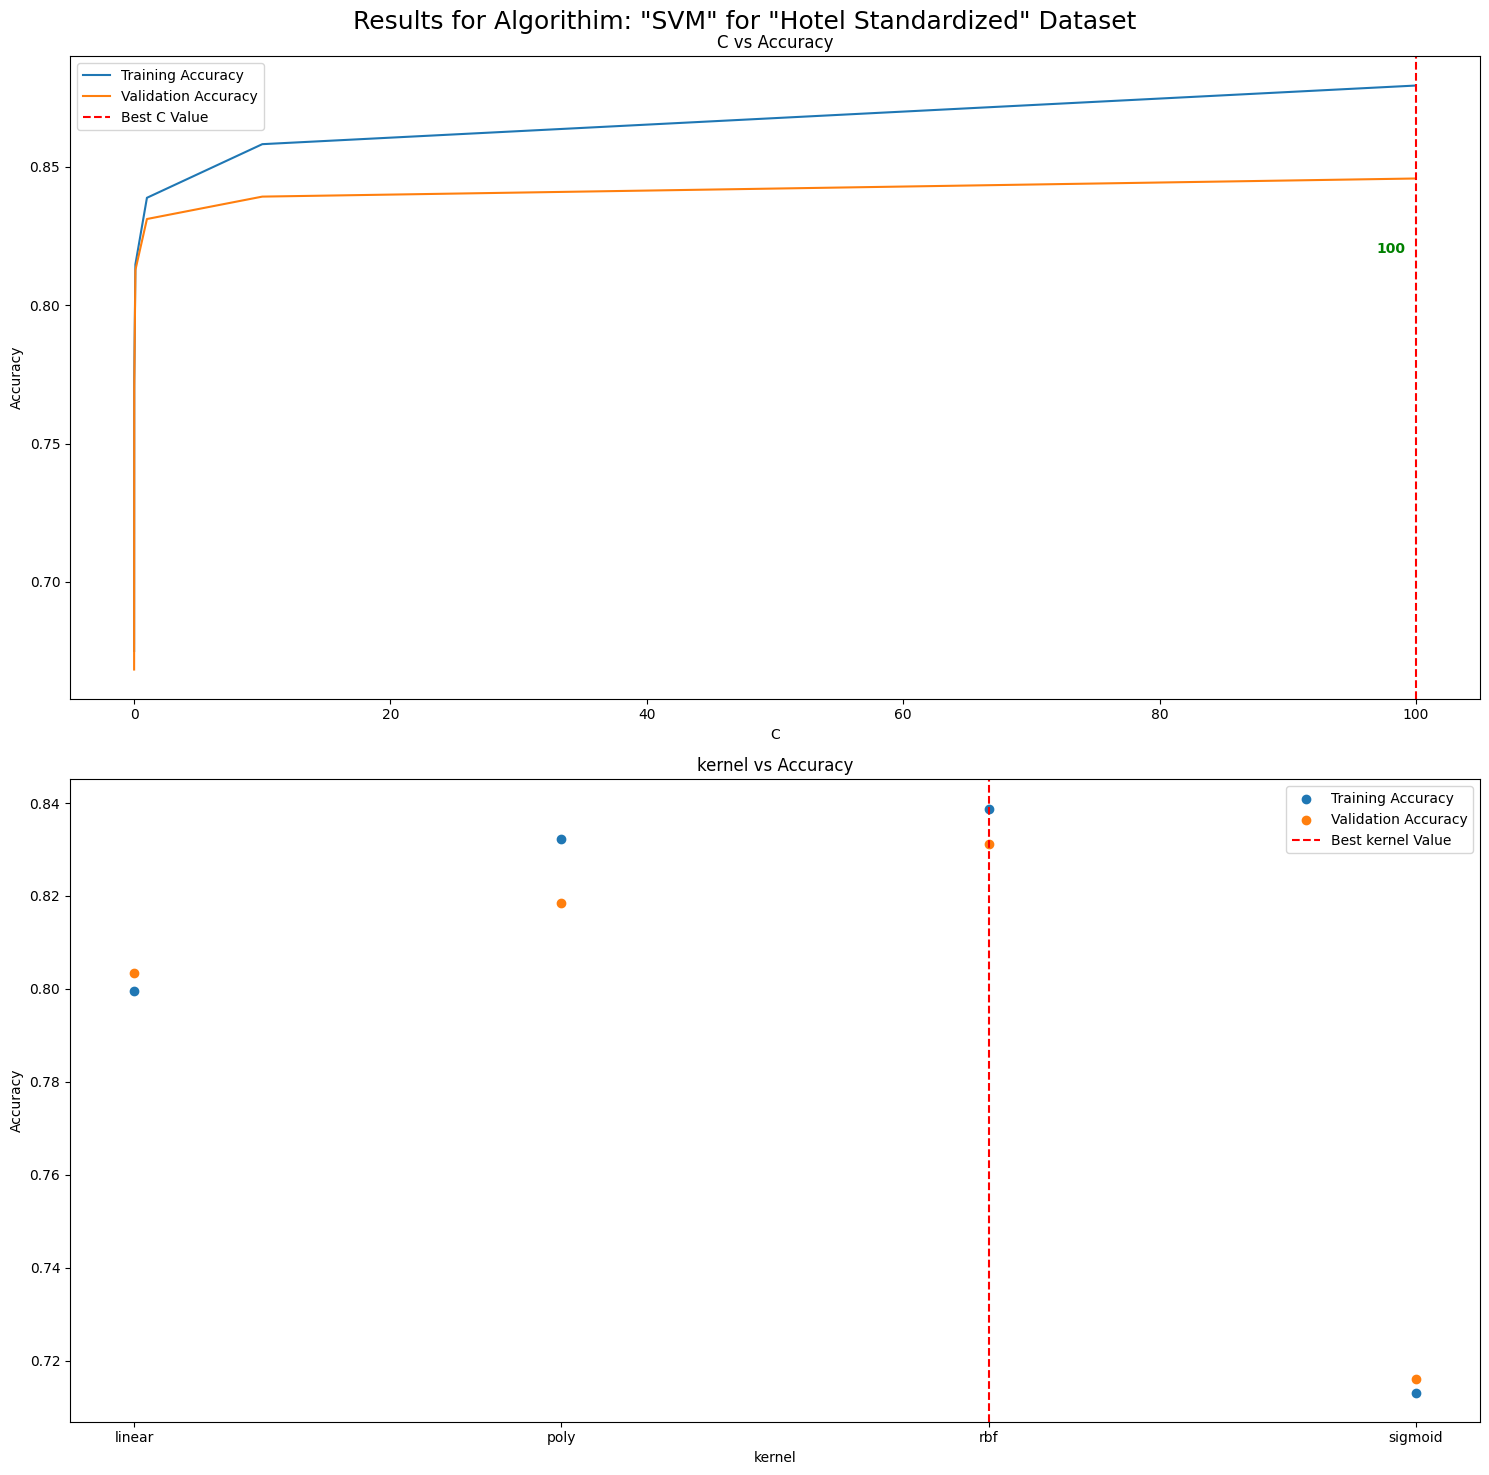

In [13]:
X_hotel,Y_hotel,col_index_hotel=load_hotel()
train_hotel_standardized,valid_hotel_standardized,test_hotel_standardized=split_data(X_hotel,Y_hotel,standardize=True)
train_hotel_unstandardized,valid_hotel_unstandardized,test_hotel_unstandardized=split_data(X_hotel,Y_hotel,standardize=False)

param_dicts={'C':[0.0001,0.01,0.1,1,10,100],'kernel':['linear','poly','rbf','sigmoid'],}
deal_algorithim(train_hotel_standardized,valid_hotel_standardized,param_dicts,'Hotel Standardized','SVM',SVC)

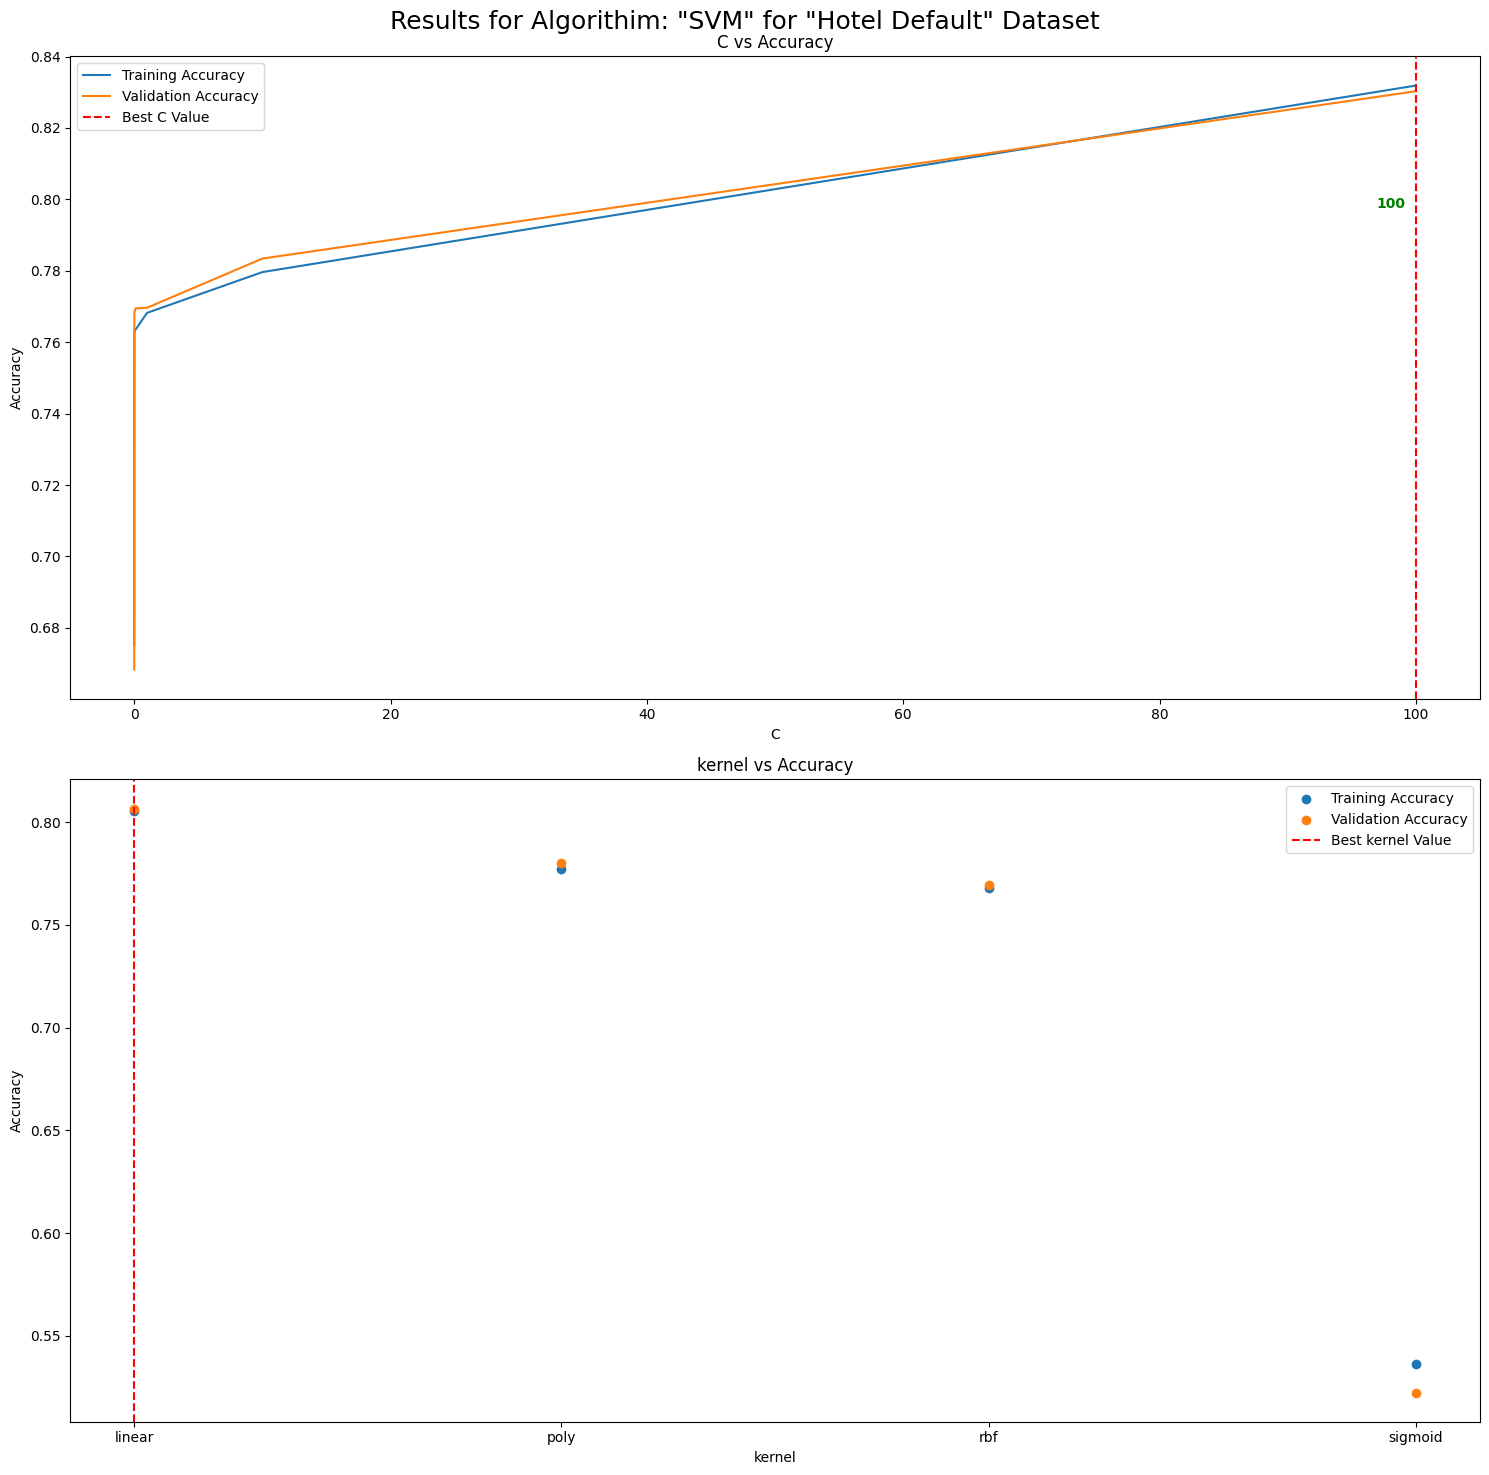

In [113]:
#Hotel Unstandardized
param_dicts={'C':[0.0001,0.01,0.1,1,10,100],'kernel':['linear','poly','rbf','sigmoid'],}
deal_algorithim(train_hotel_unstandardized,valid_hotel_unstandardized,param_dicts,'Hotel Default','SVM',SVC)

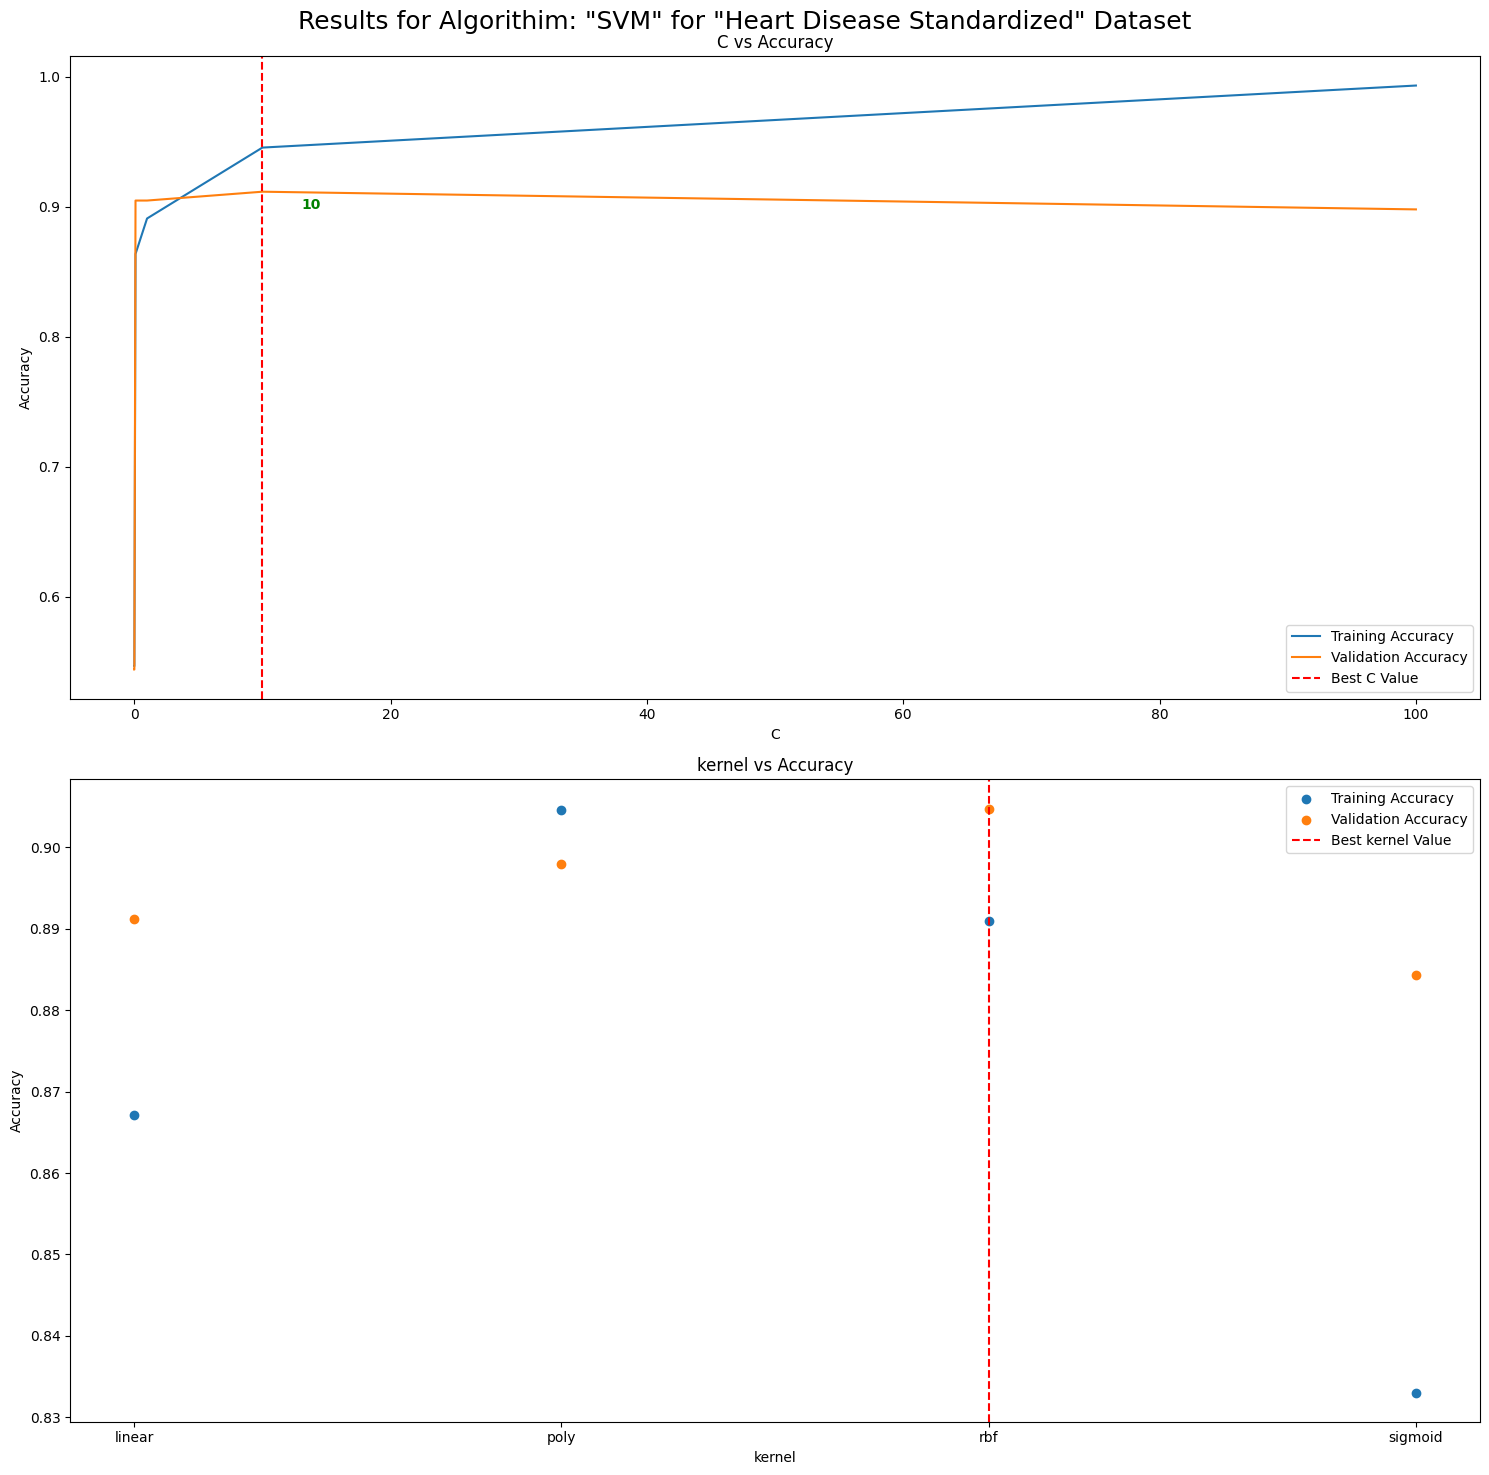

In [112]:
#Heart Data Accuracy
X_heart,Y_heart,col_index_heart=load_heart_data()
train_heart_standardized,valid_heart_standardized,test_heart_standardized=split_data(X_heart,Y_heart,standardize=True)
train_heart_unstandardized,valid_heart_unstandardized,test_heart_unstandardized=split_data(X_heart,Y_heart,standardize=False)

param_dicts={'C':[0.0001,0.01,0.1,1,10,100],'kernel':['linear','poly','rbf','sigmoid'],}
deal_algorithim(train_heart_standardized,valid_heart_standardized,param_dicts,'Heart Disease Standardized','SVM',SVC)

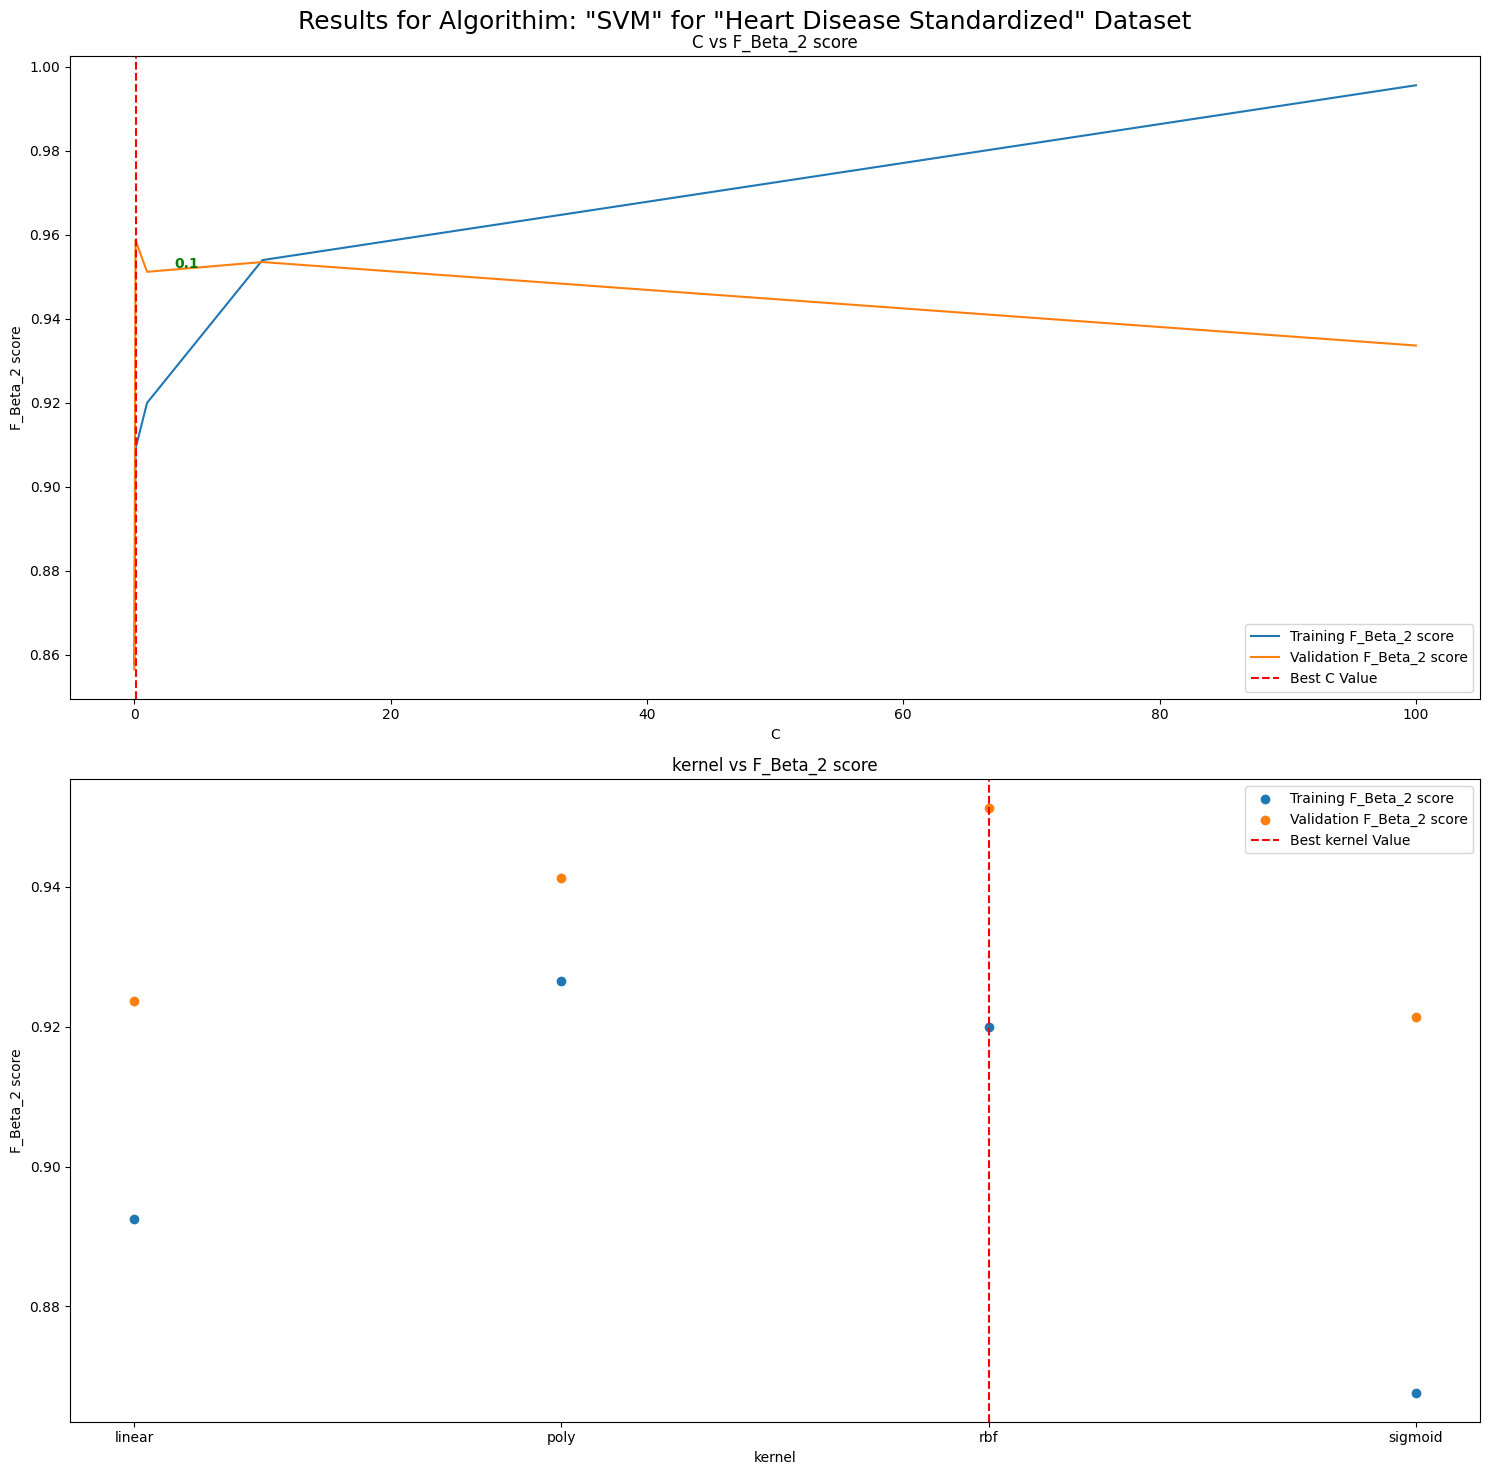

In [14]:
#Heart Data
X_heart,Y_heart,col_index_heart=load_heart_data()
train_heart_standardized,valid_heart_standardized,test_heart_standardized=split_data(X_heart,Y_heart,standardize=True)
train_heart_unstandardized,valid_heart_unstandardized,test_heart_unstandardized=split_data(X_heart,Y_heart,standardize=False)

param_dicts={'C':[0.0001,0.01,0.1,1,10,100],'kernel':['linear','poly','rbf','sigmoid'],}
deal_algorithim(train_heart_standardized,valid_heart_standardized,param_dicts,'Heart Disease Standardized','SVM',SVC,fbeta_score,'F_Beta_2 score')

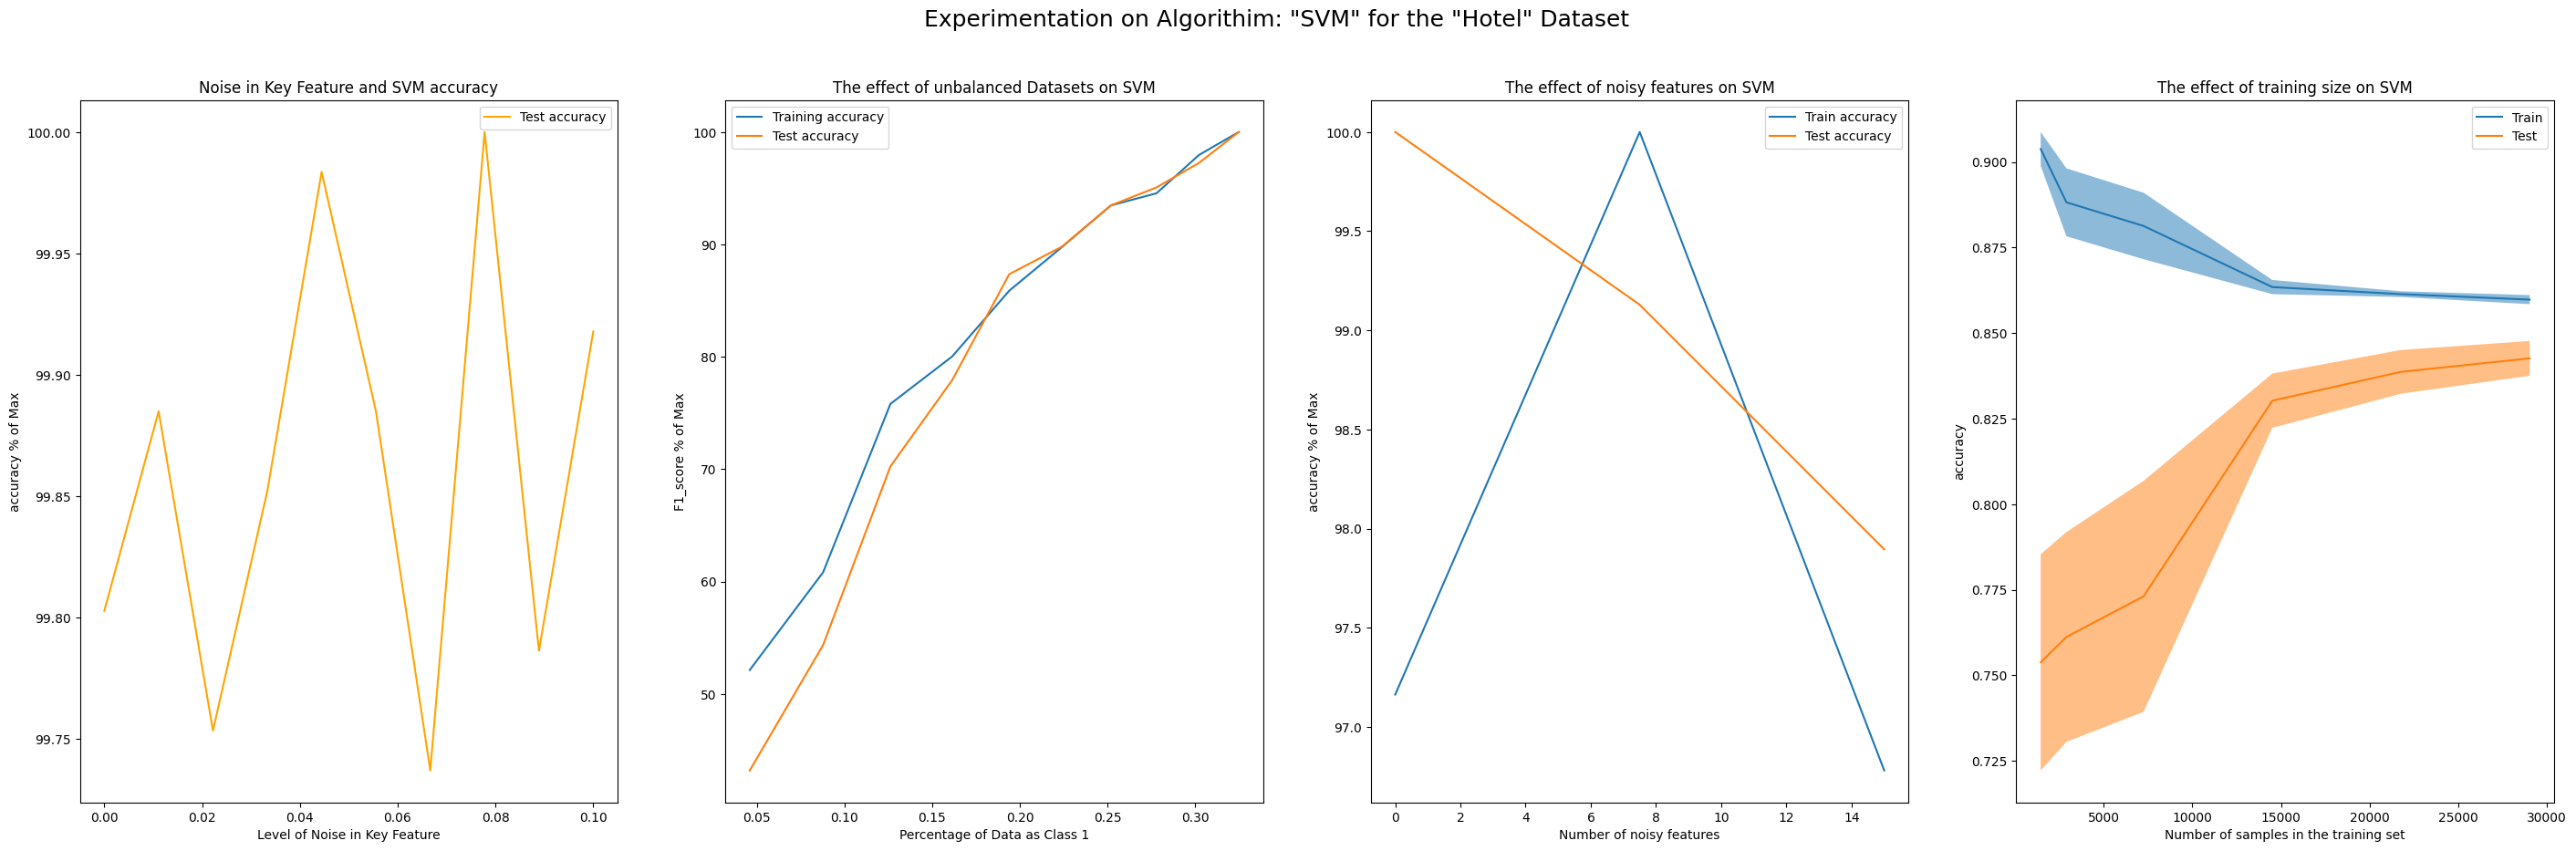

In [114]:
#Experiment Hotel Data
param_dicts={'C':[0.1,1,10],'gamma':['scale','auto'],'kernel':['rbf']}
experiment_algorithim(train=train_hotel_standardized,test=test_hotel_standardized,X=X_hotel,Y=Y_hotel,params=param_dicts,dataset='Hotel',col_index=col_index_hotel,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,algorithim_name='SVM',algorithim=SVC(),predictor_metric_name='accuracy',search=True,LD_scoring=ld_accuracy_scorer())

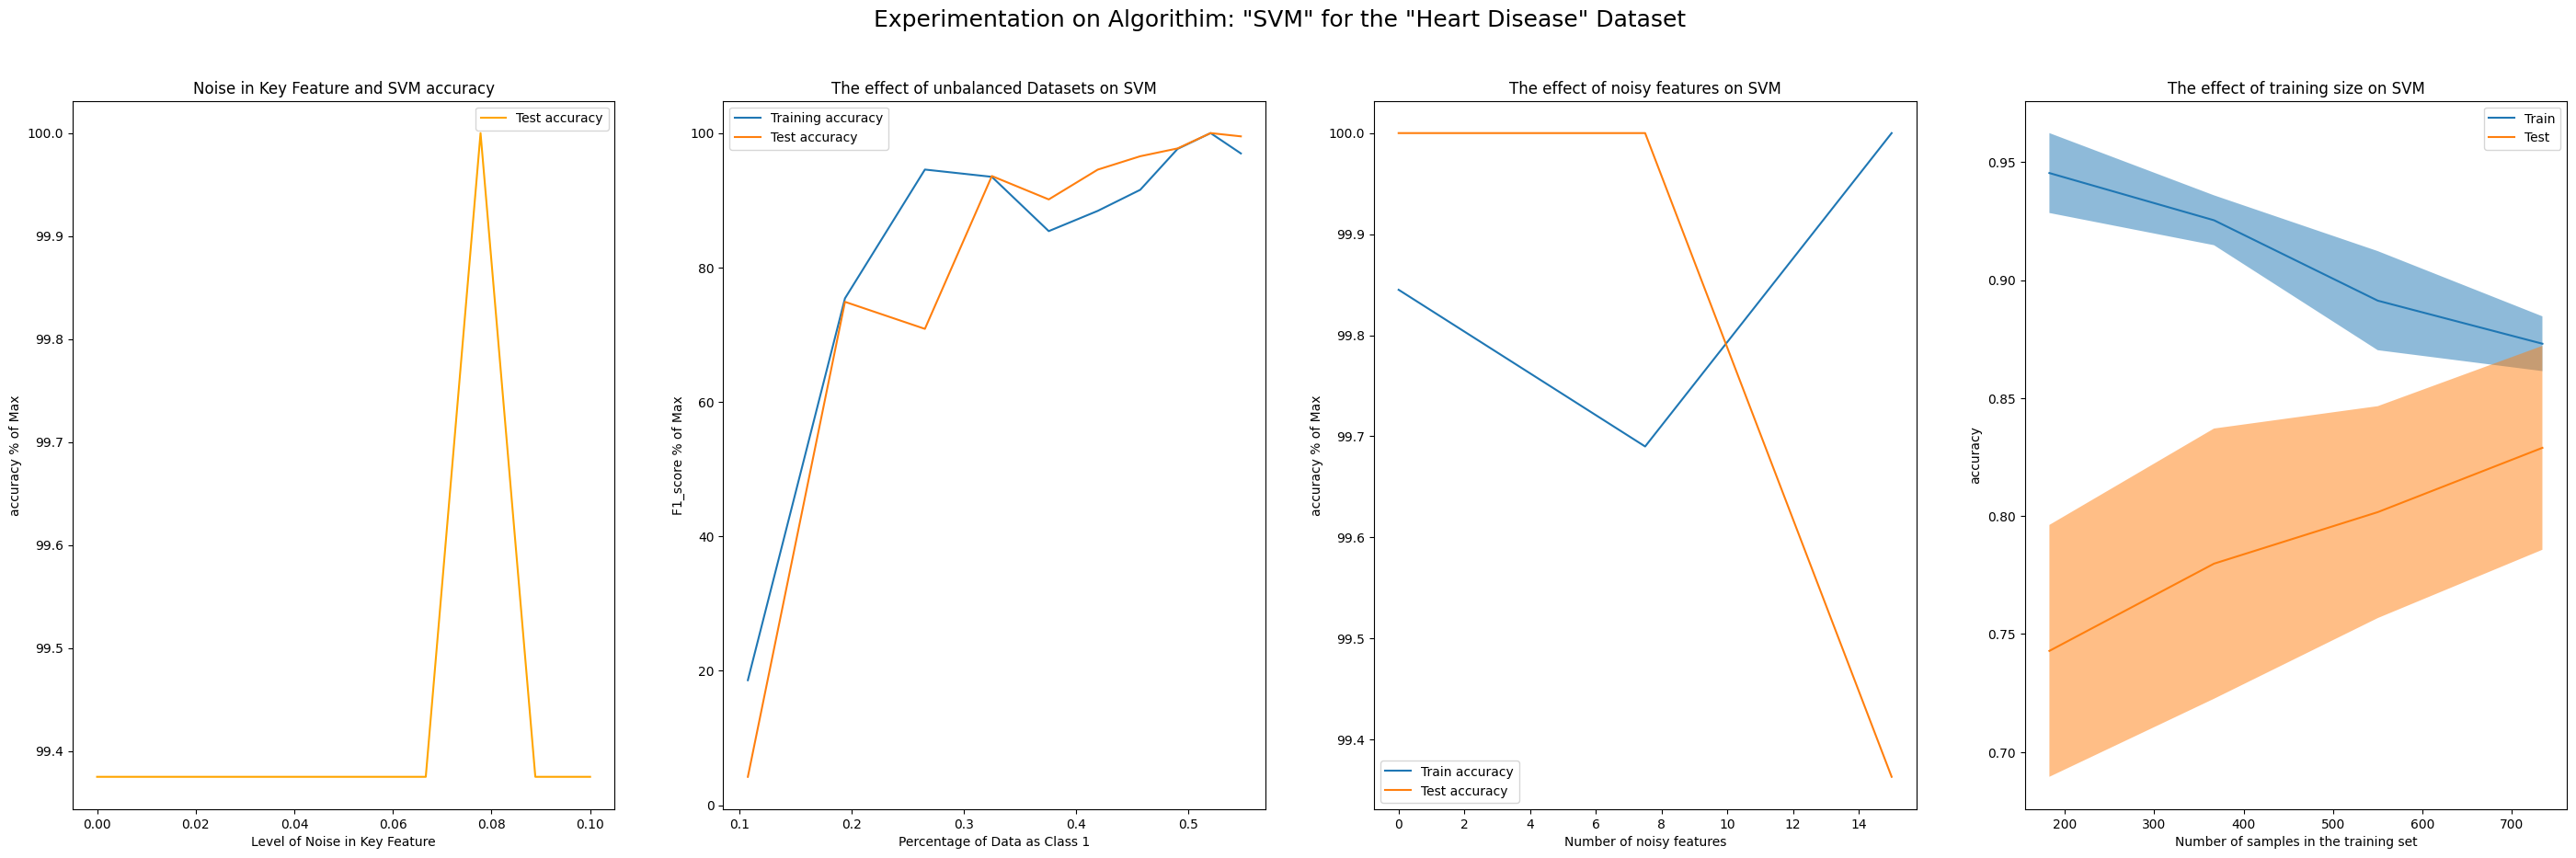

In [115]:
#Experiment Heart Data Accuracy
param_dicts={'C':[0.1,1,10],'gamma':['scale','auto'],'kernel':['rbf','poly'],'degree':[1,2,3,4,5]}
experiment_algorithim(train=train_heart_standardized,test=test_heart_standardized,X=X_heart,Y=Y_heart,params=param_dicts,dataset='Heart Disease',col_index=col_index_heart,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,algorithim_name='SVM',algorithim=SVC(),predictor_metric_name='accuracy',search=True,LD_scoring=ld_accuracy_scorer())

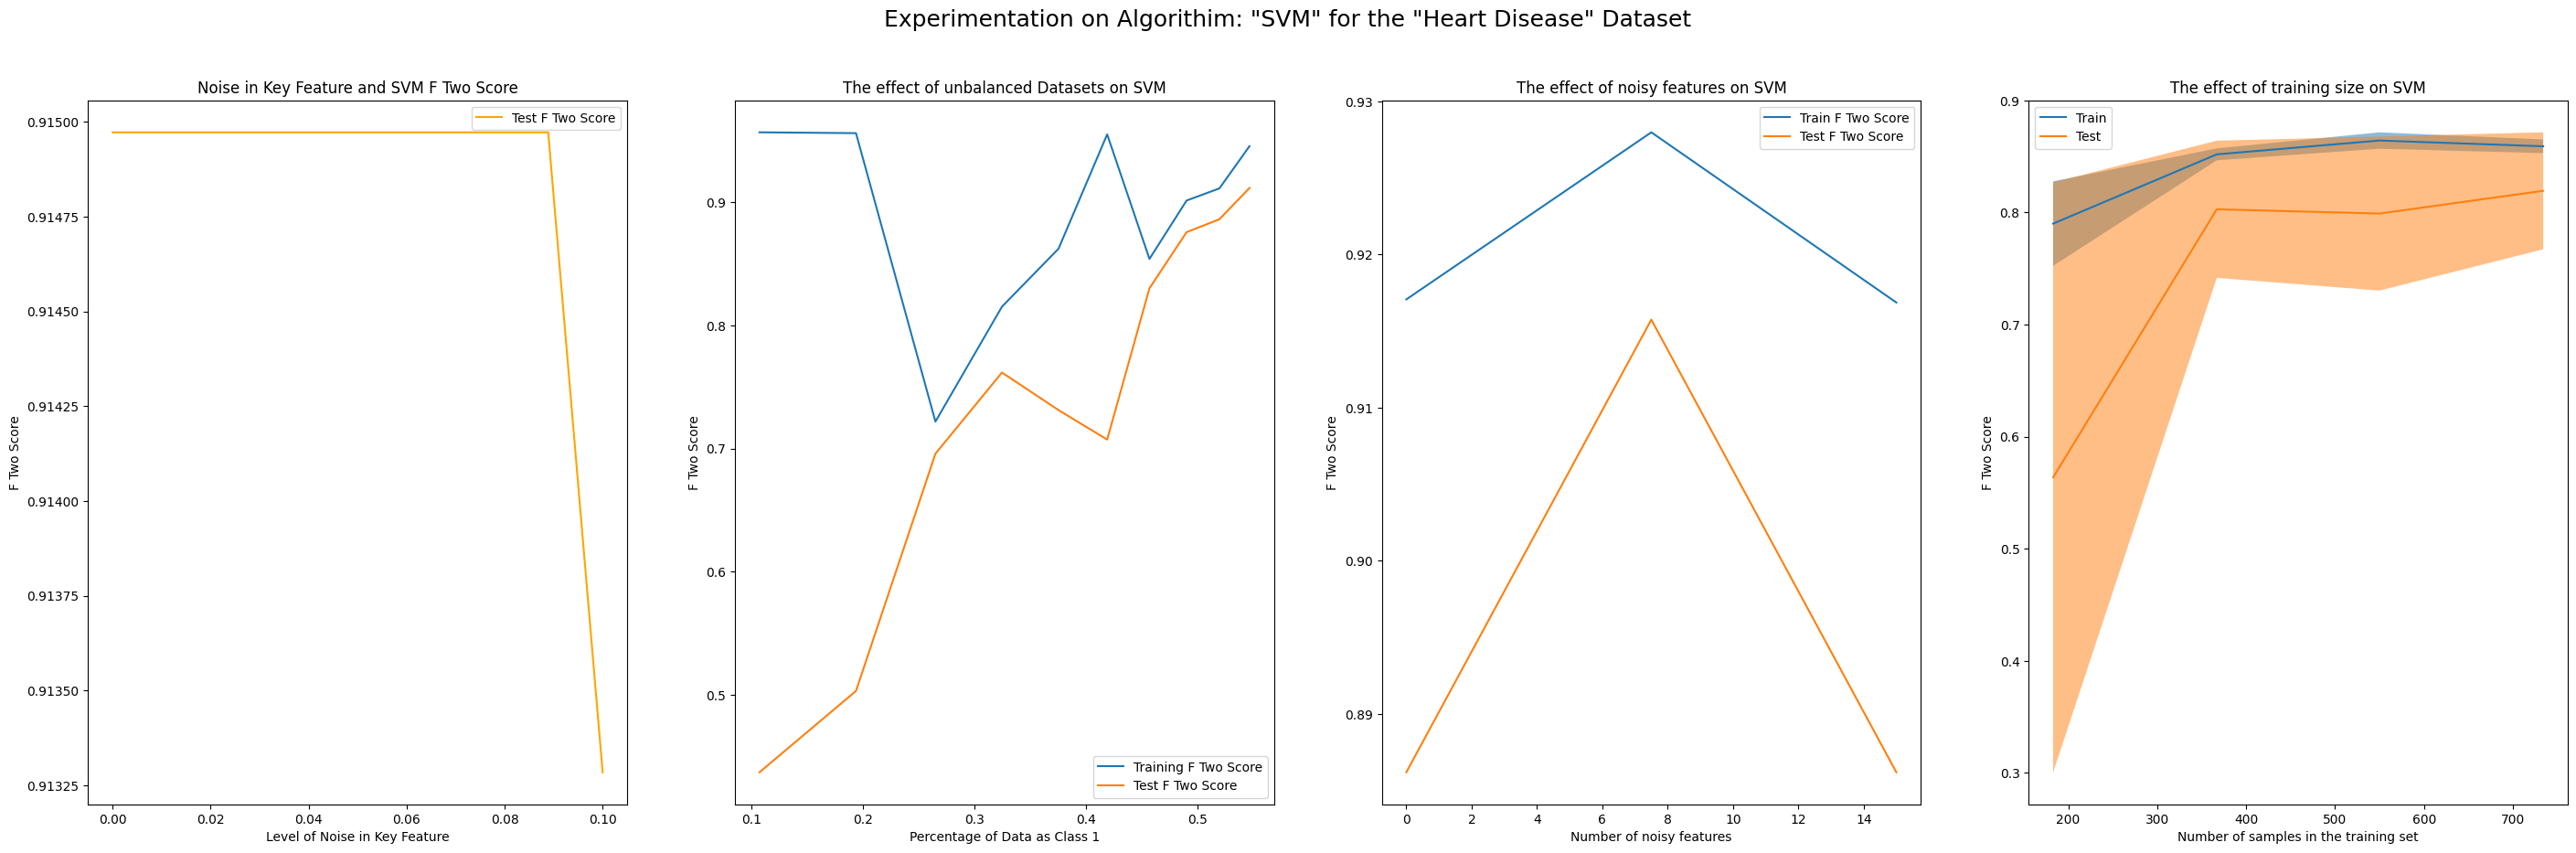

In [60]:
#Experiment Heart Data
param_dicts={'C':[0.1,1,10],'gamma':['scale','auto'],'kernel':['rbf','poly'],'degree':[1,2,3,4,5]}
experiment_algorithim(train=train_heart_standardized,test=test_heart_standardized,X=X_heart,Y=Y_heart,params=param_dicts,dataset='Heart Disease',col_index=col_index_heart,predictor_metric=fbeta_score,grid_search_metric=ftwo_scorer,algorithim_name='SVM',algorithim=SVC(),predictor_metric_name='F Two Score',search=True,LD_scoring=ld_ftwo_scorer())


In [17]:
#Final Hotel Dataset Results
param_dicts={'C':[0.1,1,10],'gamma':['scale','auto'],'kernel':['rbf']}
score_algorithim(X=X_hotel,Y=Y_hotel,dataset_name='Hotel Dataset',algorithim_name='SVM',algorithim=SVC(),params=param_dicts,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy')

Hotel Dataset Final Results


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Average time to train the ideal SVM was 19.271 seconds
Average time to infer the ideal SVM was 4.594 seconds


The result on the training data for the ideal SVM algorithim is a 0.8572019297036526 accuracy score
The result on the test data for the ideal SVM algorithim is a 0.8387319090282563 accuracy score


In [116]:
#Final Heart Dise Dataset Results Accuracy
param_dicts={'C':[0.1,1,10],'gamma':['scale','auto'],'kernel':['rbf']}
score_algorithim(X=X_heart,Y=Y_heart,dataset_name='Heart Disease Dataset',algorithim_name='SVM',algorithim=SVC(),params=param_dicts,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,predictor_metric_name='accuracy')

Heart Disease Dataset Final Results


{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}


Average time to train the ideal SVM was 0.014 seconds
Average time to infer the ideal SVM was 0.004 seconds


The result on the training data for the ideal SVM algorithim is a 0.8705722070844687 accuracy score
The result on the test data for the ideal SVM algorithim is a 0.8641304347826086 accuracy score


In [18]:
#Final Heart Dise Dataset Results
param_dicts={'C':[0.1,1,10],'gamma':['scale','auto'],'kernel':['rbf']}
score_algorithim(X=X_heart,Y=Y_heart,dataset_name='Heart Disease Dataset',algorithim_name='SVM',algorithim=SVC(),params=param_dicts,predictor_metric=fbeta_score,grid_search_metric=accuracy_scorer,predictor_metric_name='F Two Score')

Heart Disease Dataset Final Results


{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}


Average time to train the ideal SVM was 0.013 seconds
Average time to infer the ideal SVM was 0.004 seconds


The result on the training data for the ideal SVM algorithim is a 0.9170731707317072 F Two Score score
The result on the test data for the ideal SVM algorithim is a 0.8861940298507461 F Two Score score


### Neural Network

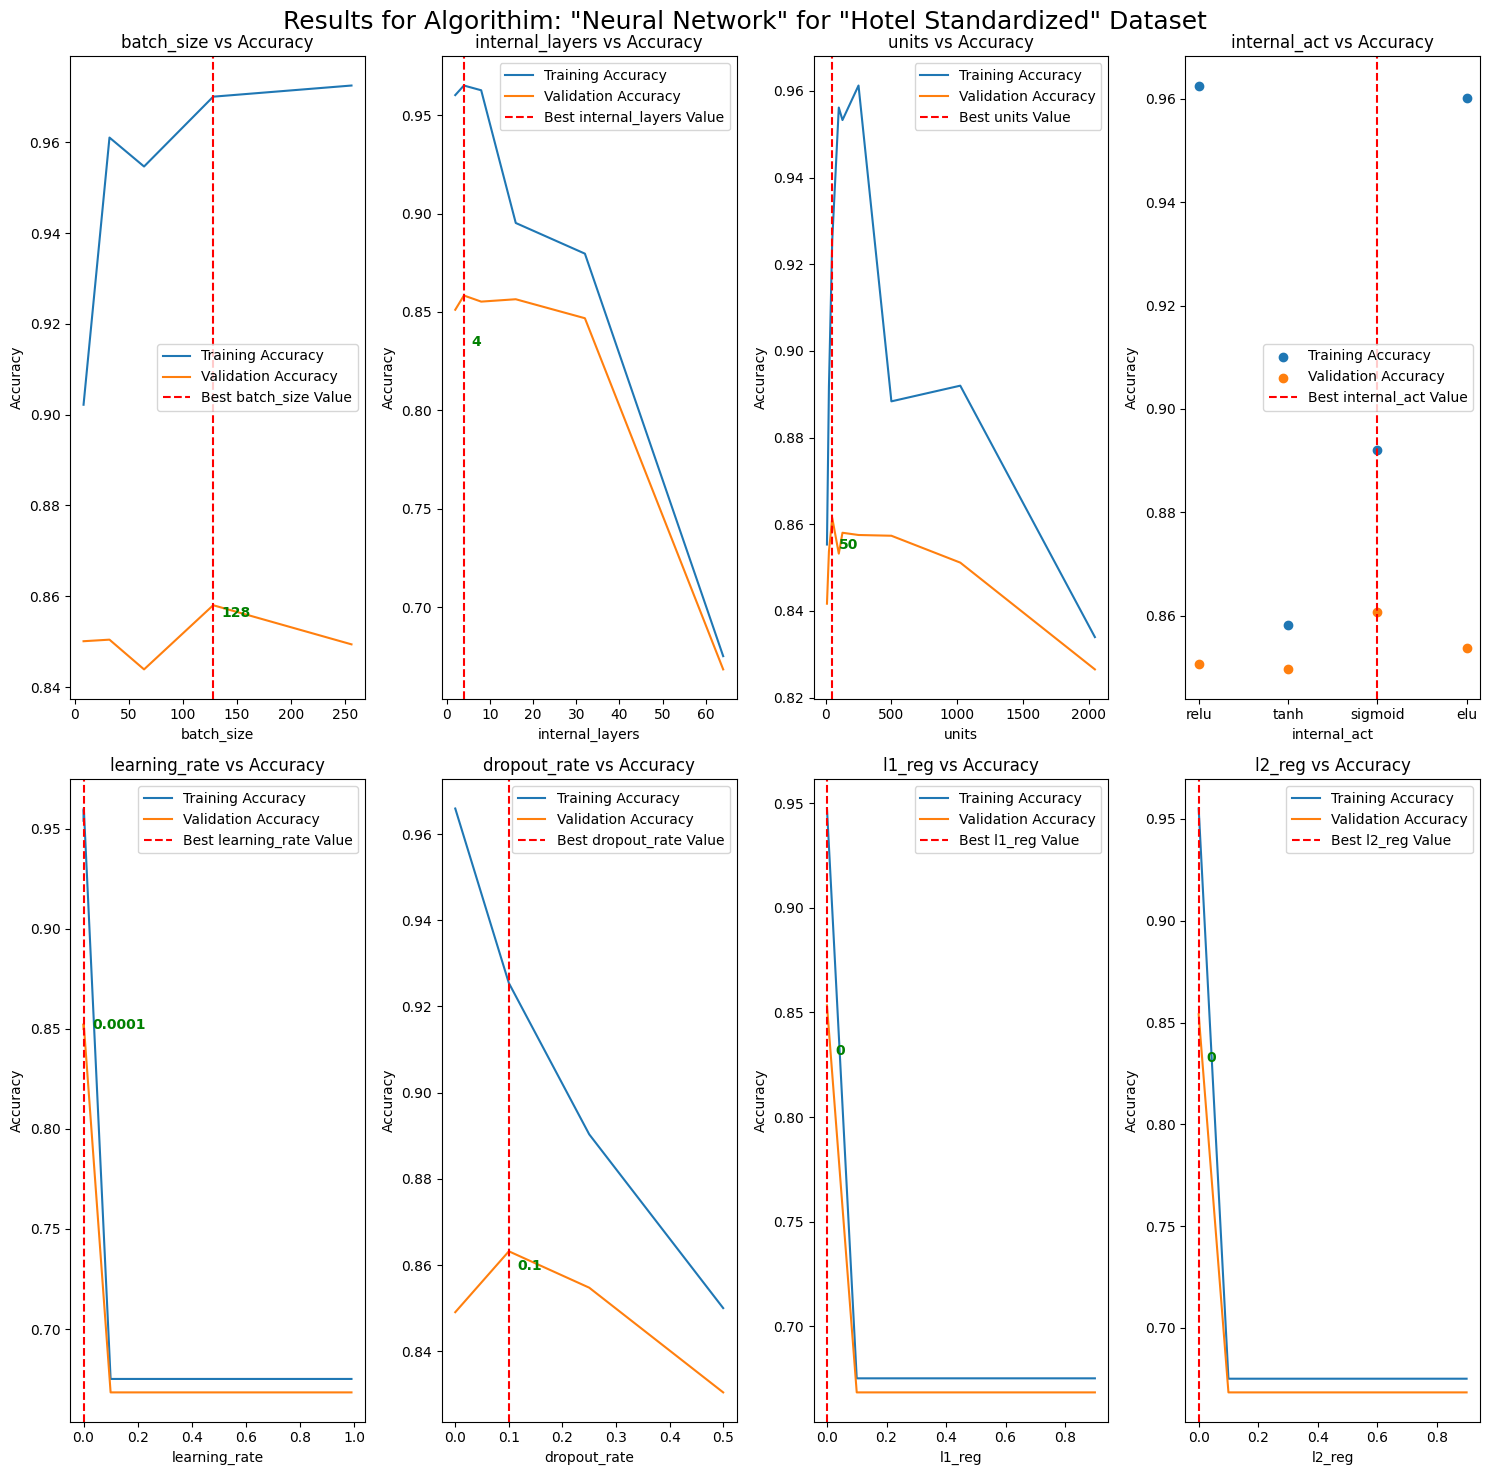

In [125]:
#Hotel Data Standardized

param_dicts={'batch_size':[8,32,64,128,256],'internal_layers':[2,4,8,16,32,64],'units':[10,25,50,100,128,250,500,1024,2048],'internal_act':['relu','tanh','sigmoid','elu'],'learning_rate':[0.00001,0.0001,0.001,0.1,0.99],'dropout_rate':[0,0.1,0.25,0.5],'l1_reg':[0,0.1,0.25,0.5,0.75,0.9],'l2_reg':[0,0.1,0.25,0.5,0.75,0.9]}

X_hotel,Y_hotel,col_index_hotel=load_hotel()
train_hotel_standardized,valid_hotel_standardized,test_hotel_standardized=split_data(X_hotel,Y_hotel,standardize=True)
train_hotel_unstandardized,valid_hotel_unstandardized,test_hotel_unstandardized=split_data(X_hotel,Y_hotel,standardize=False)

deal_algorithim(train_hotel_standardized,valid_hotel_standardized,param_dicts,'Hotel Standardized','Neural Network',NNnet)

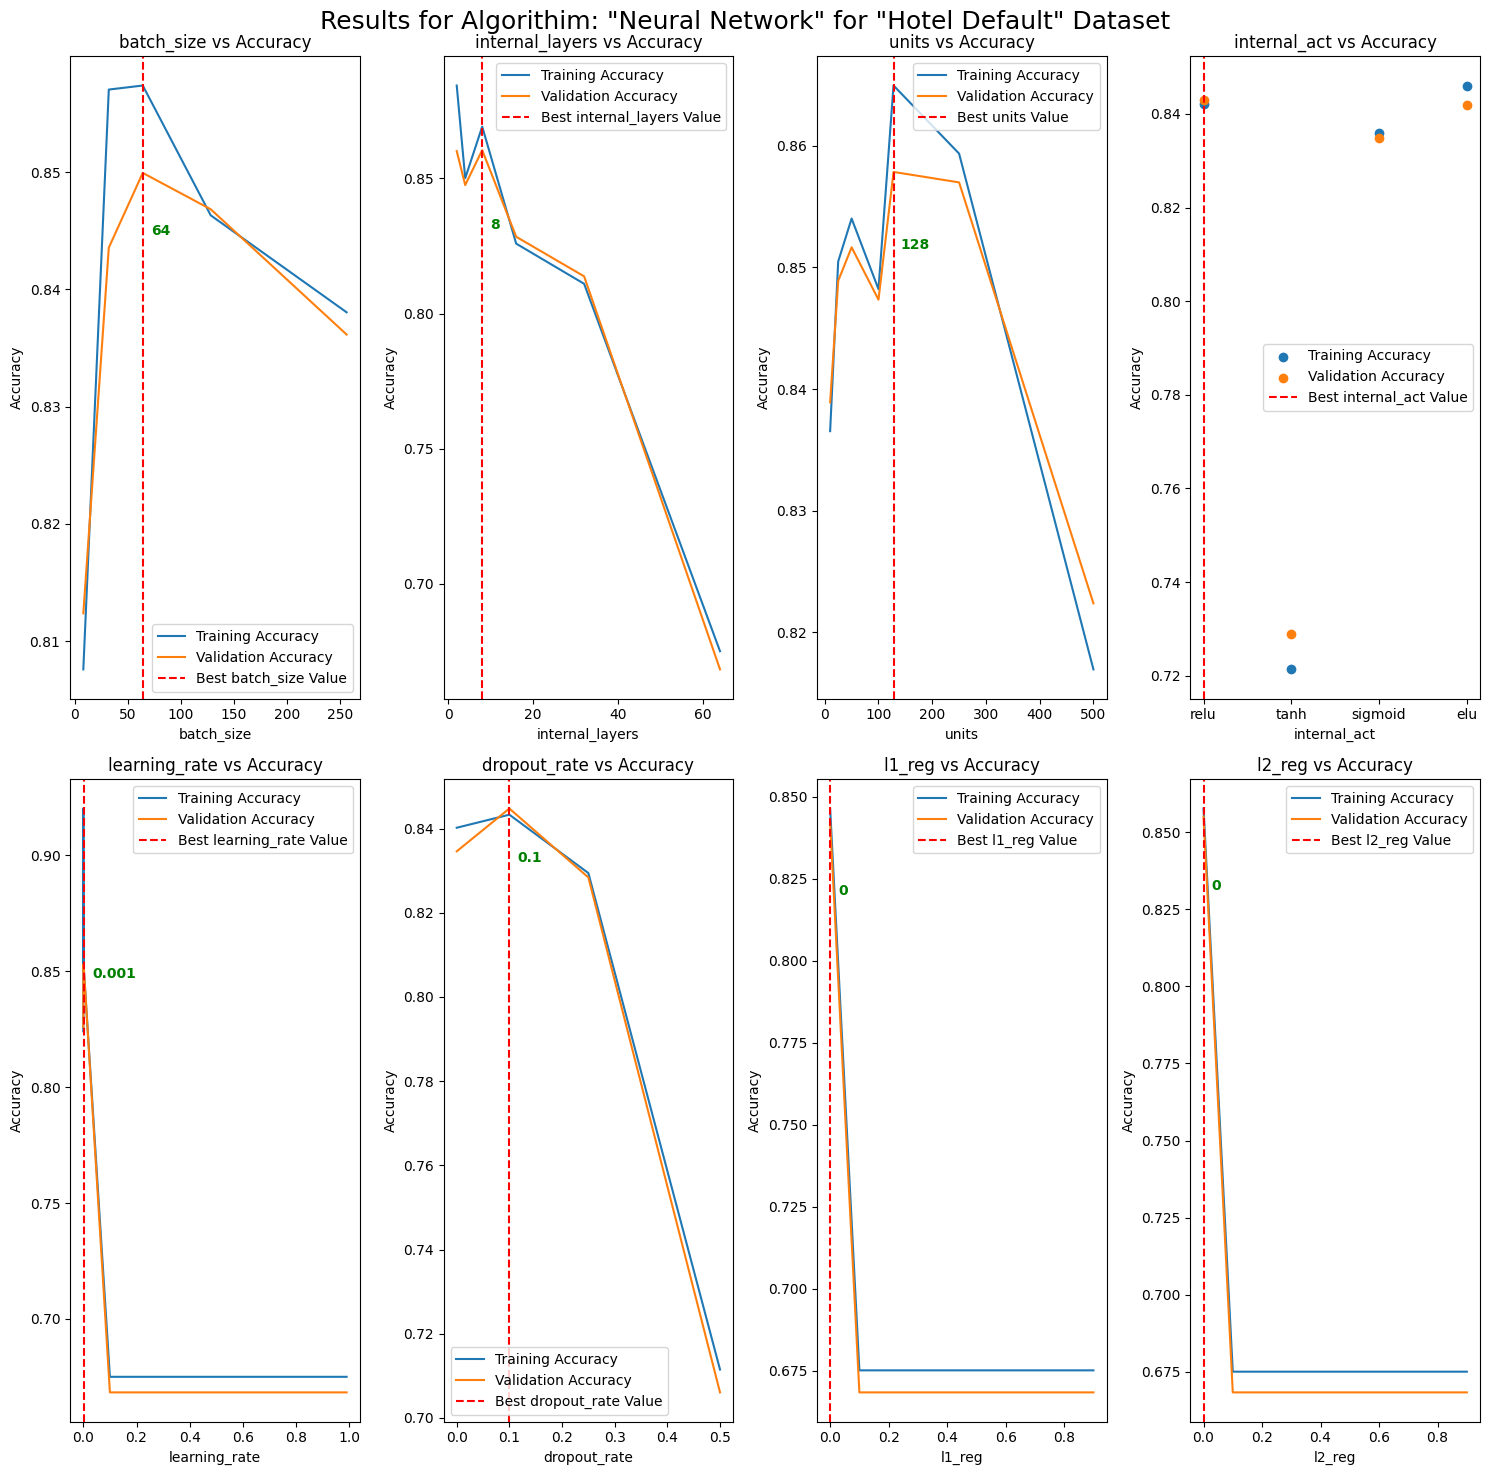

In [20]:
# Hotel Data Unstandardized 

param_dicts={'batch_size':[8,32,64,128,256],'internal_layers':[2,4,8,16,32,64],'units':[10,25,50,100,128,250,500],'internal_act':['relu','tanh','sigmoid','elu'],'learning_rate':[0.00001,0.0001,0.001,0.1,0.99],'dropout_rate':[0,0.1,0.25,0.5],'l1_reg':[0,0.1,0.25,0.5,0.75,0.9],'l2_reg':[0,0.1,0.25,0.5,0.75,0.9]}
deal_algorithim(train_hotel_unstandardized,valid_hotel_unstandardized,param_dicts,'Hotel Default','Neural Network',NNnet)

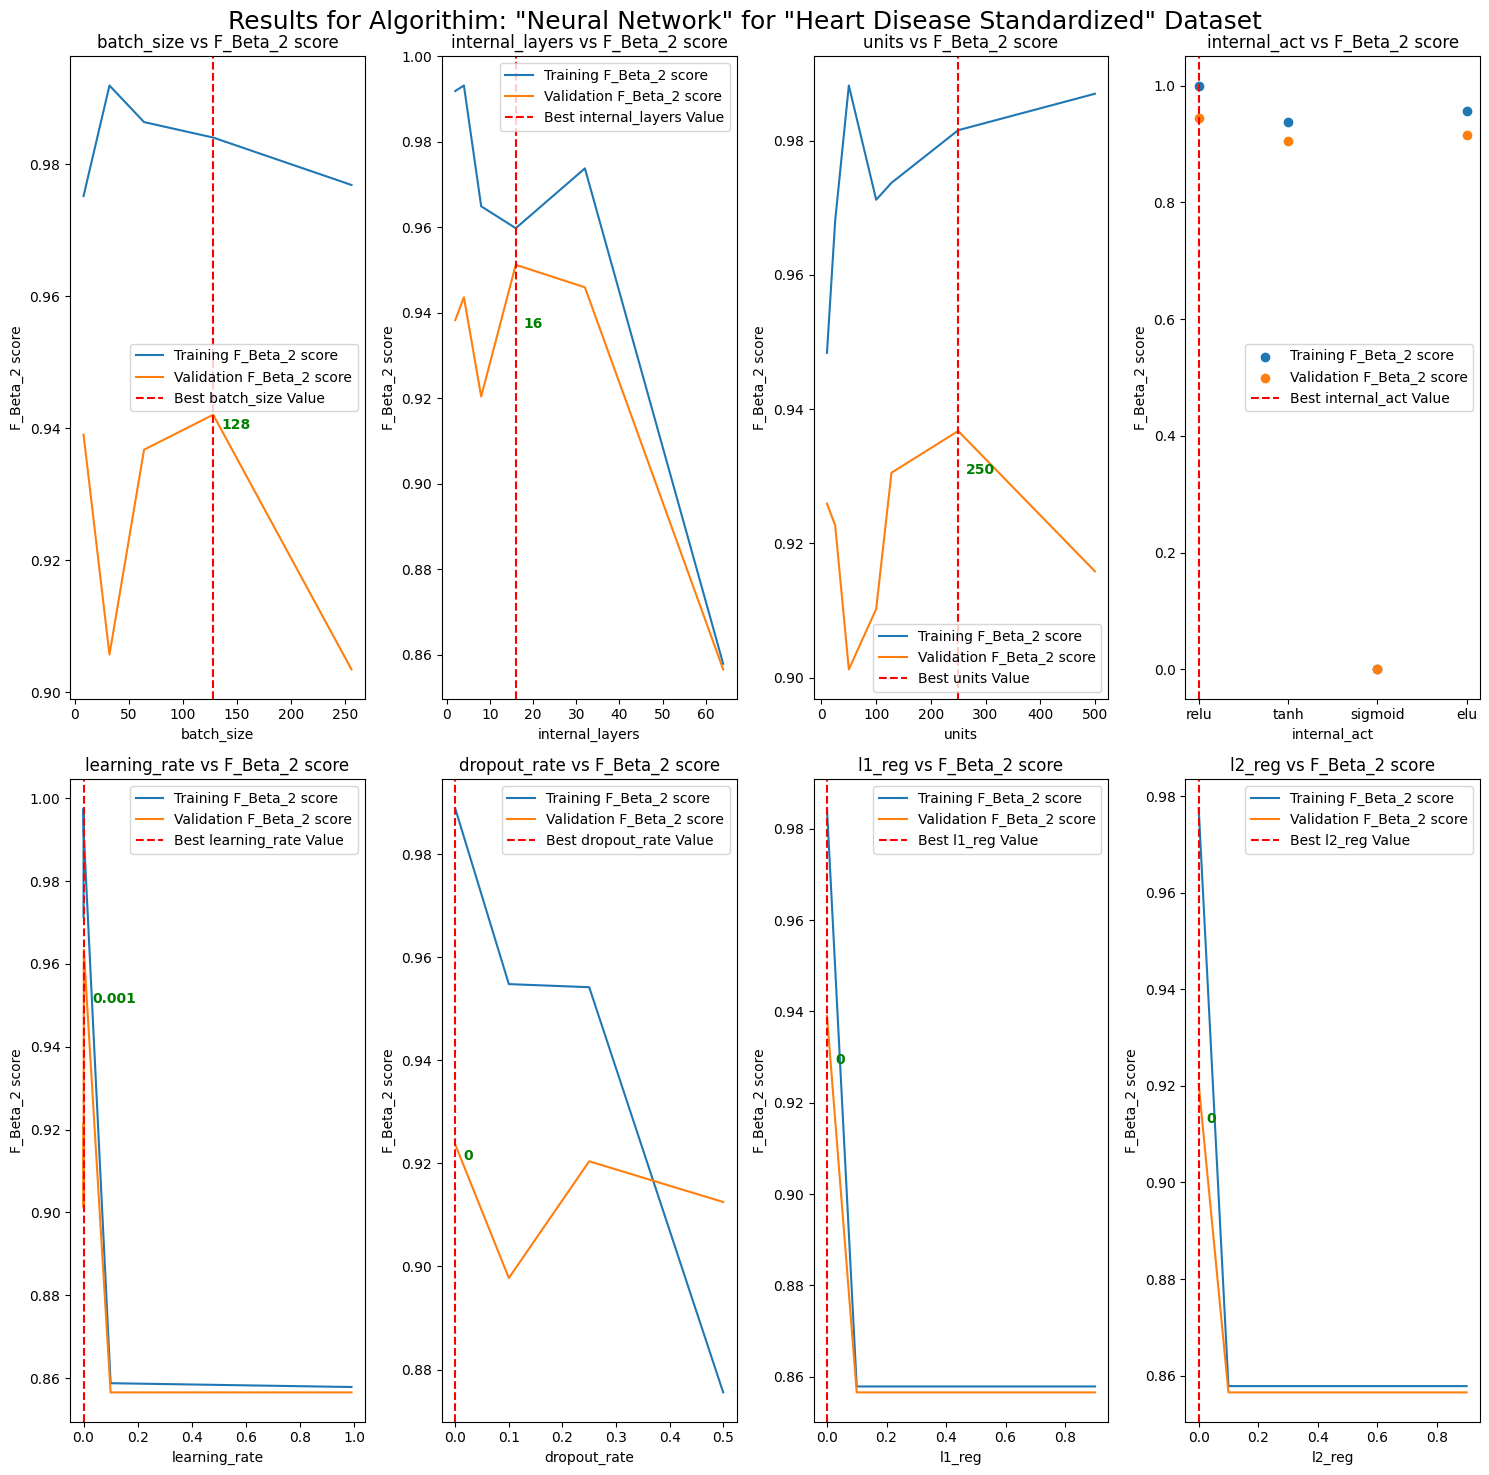

In [21]:
#Heart Data Standardized 
X_heart,Y_heart,col_index_heart=load_heart_data()
train_heart_standardized,valid_heart_standardized,test_heart_standardized=split_data(X_heart,Y_heart,standardize=True)
train_heart_unstandardized,valid_heart_unstandardized,test_heart_unstandardized=split_data(X_heart,Y_heart,standardize=True)

param_dicts={'batch_size':[8,32,64,128,256],'internal_layers':[2,4,8,16,32,64],'units':[10,25,50,100,128,250,500,1024,2048],'internal_act':['relu','tanh','sigmoid','elu'],'learning_rate':[0.00001,0.0001,0.001,0.1,0.99],'dropout_rate':[0,0.1,0.25,0.5],'l1_reg':[0,0.1,0.25,0.5,0.75,0.9],'l2_reg':[0,0.1,0.25,0.5,0.75,0.9]}
deal_algorithim(train_heart_standardized,valid_heart_standardized,param_dicts,'Heart Disease Standardized','Neural Network',NNnet,fbeta_score,'F_Beta_2 score')

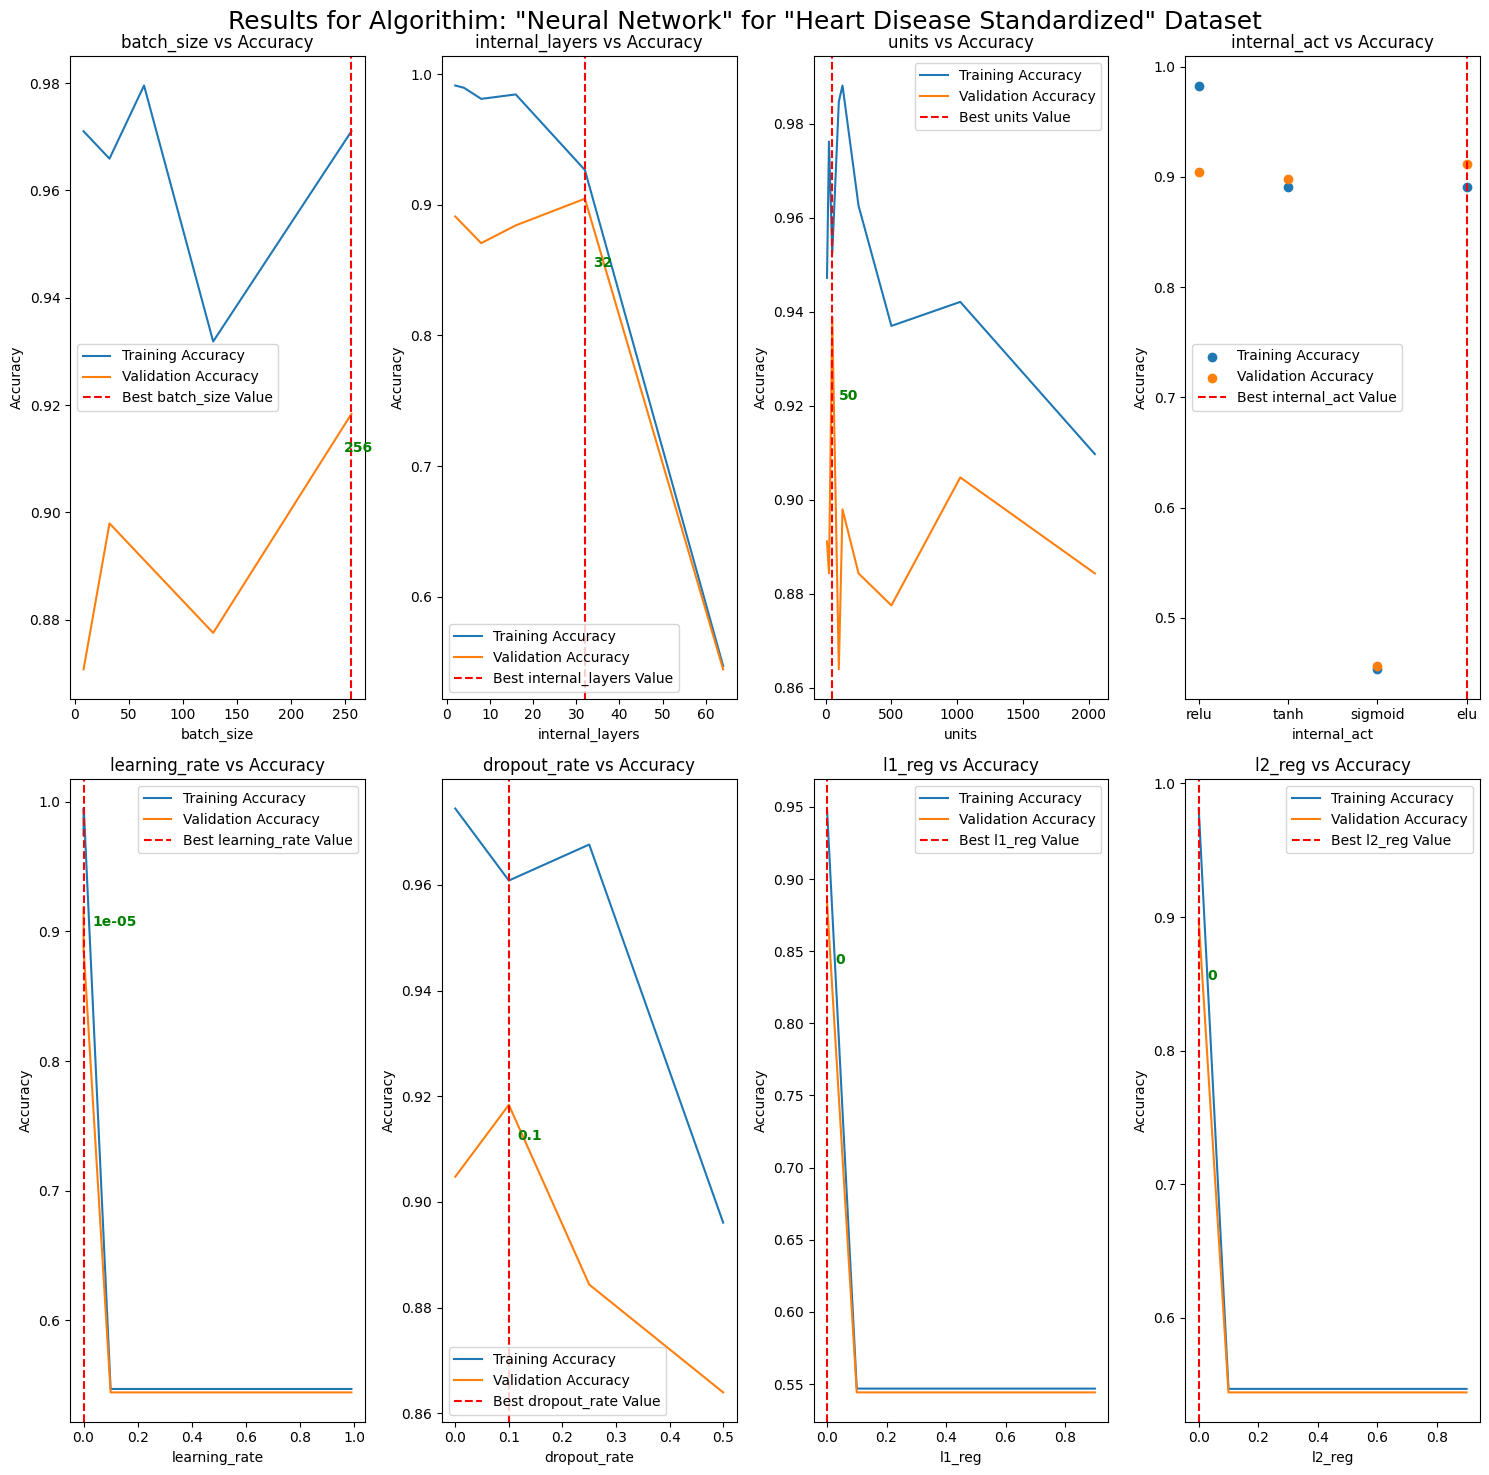

In [129]:
#Heart Data Standardized Accuracy
X_heart,Y_heart,col_index_heart=load_heart_data()
train_heart_standardized,valid_heart_standardized,test_heart_standardized=split_data(X_heart,Y_heart,standardize=True)
train_heart_unstandardized,valid_heart_unstandardized,test_heart_unstandardized=split_data(X_heart,Y_heart,standardize=True)

param_dicts={'batch_size':[8,32,64,128,256],'internal_layers':[2,4,8,16,32,64],'units':[10,25,50,100,128,250,500,1024,2048],'internal_act':['relu','tanh','sigmoid','elu'],'learning_rate':[0.00001,0.0001,0.001,0.1,0.99],'dropout_rate':[0,0.1,0.25,0.5],'l1_reg':[0,0.1,0.25,0.5,0.75,0.9],'l2_reg':[0,0.1,0.25,0.5,0.75,0.9]}
deal_algorithim(train_heart_standardized,valid_heart_standardized,param_dicts,'Heart Disease Standardized','Neural Network',NNnet)

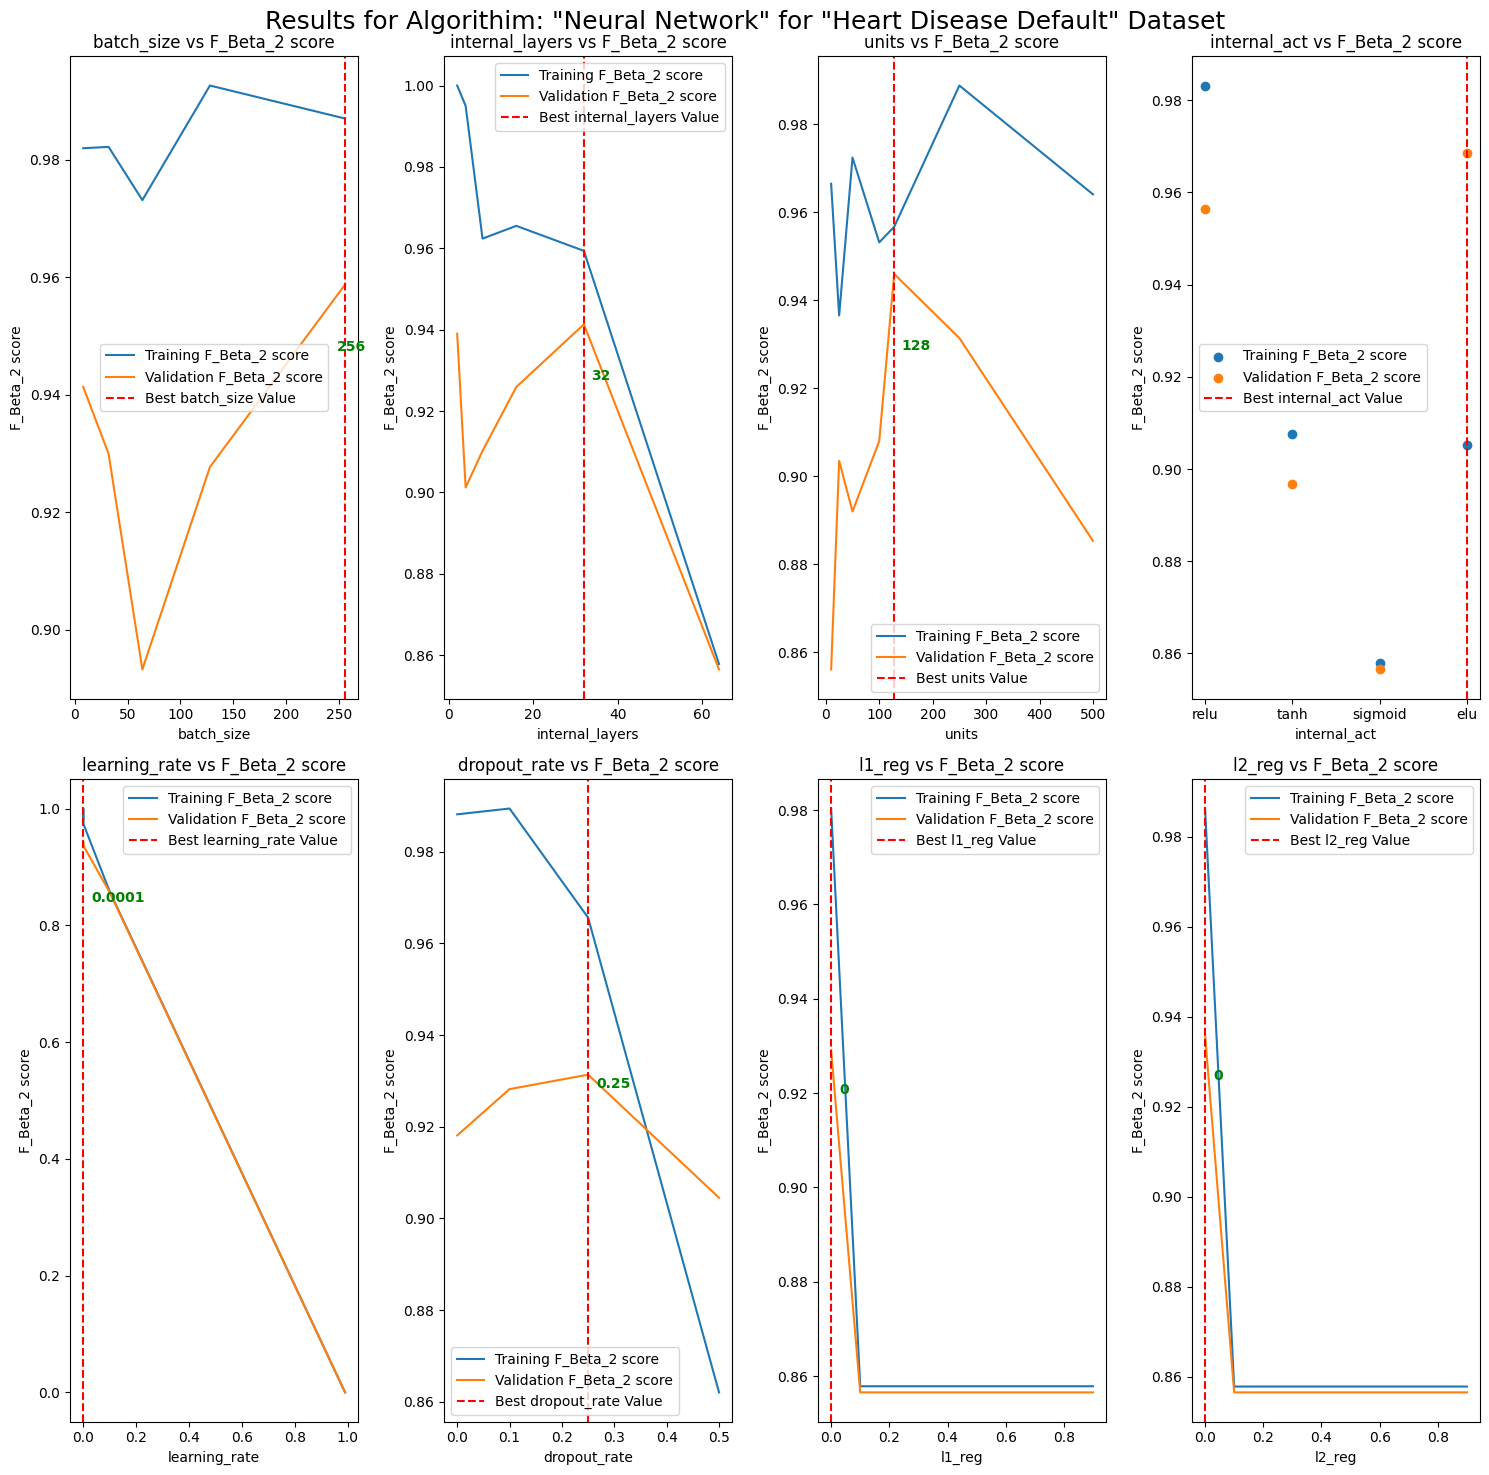

In [23]:
#Heart Data Unstandardized

param_dicts={'batch_size':[8,32,64,128,256],'internal_layers':[2,4,8,16,32,64],'units':[10,25,50,100,128,250,500],'internal_act':['relu','tanh','sigmoid','elu'],'learning_rate':[0.00001,0.0001,0.001,0.1,0.99],'dropout_rate':[0,0.1,0.25,0.5],'l1_reg':[0,0.1,0.25,0.5,0.75,0.9],'l2_reg':[0,0.1,0.25,0.5,0.75,0.9]}
#deal_algorithim(train=train_heart_unstandardized,test=valid_heart_unstandardized,param_dicts=param_dicts,dataset='Heart Disease Unstandardized',algorithim_name='Neural Network',algorithim=NNnet,metric=f1_score,metric_name='f1')
deal_algorithim(train_heart_unstandardized,valid_heart_unstandardized,param_dicts,'Heart Disease Default','Neural Network',NNnet,fbeta_score,'F_Beta_2 score')

In [24]:
# #Heart Data Standardized 
# X_heart,Y_heart,col_index_heart=load_heart_data()

# sklr=StandardScaler()
# X_heart_std=sklr.fit_transform(X_heart)

# p={'internal_layers':4,'units':128,'learning_rate':0.0001,'dropout_rate':0.25,'batch_size':8,'input_dims':20}
# algorithim=NNnet(**p)
# LearningCurveDisplay.from_estimator(algorithim,X_heart_std,Y_heart,train_sizes=[0.5,1],scoring=f1_scorer())

In [25]:
# X_hotel,Y_hotel,col_index_hotel=load_hotel()

# sklr=StandardScaler()
# X_hotel_std=sklr.fit_transform(X_hotel)

# p={'internal_layers':4,'units':128,'learning_rate':0.0001,'dropout_rate':0.25,'batch_size':8,'input_dims':30}
# algorithim=NNnet(**p)
# LearningCurveDisplay.from_estimator(algorithim,X_hotel_std,Y_hotel,train_sizes=[0.5,1],scoring=acc_scorer())

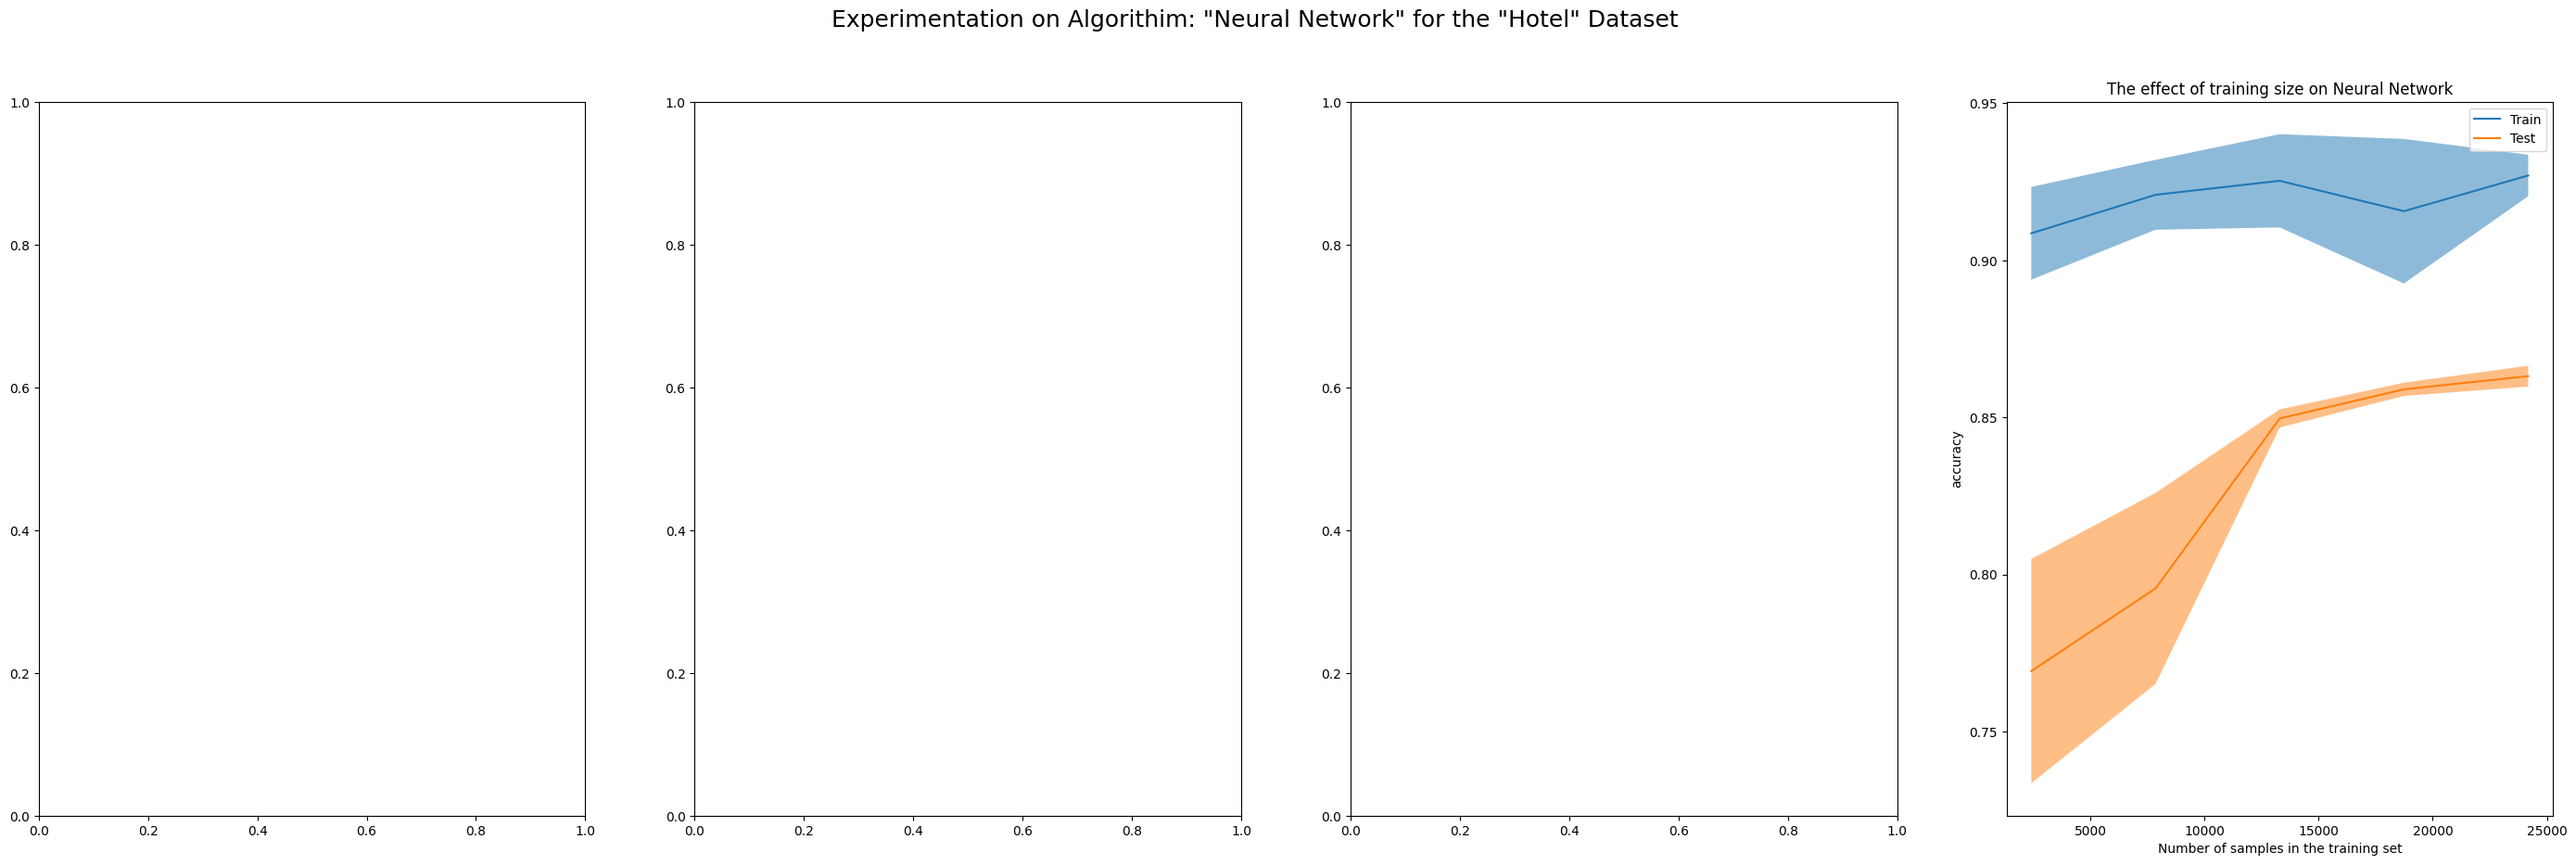

In [144]:
#Experiment Hotel Data

param_dicts={'dropout_rate': 0.1, 'internal_layers': 4, 'learning_rate': 0.0001, 'units': 128}

experiment_algorithim(train=train_hotel_standardized,test=valid_hotel_standardized,X=X_hotel,Y=Y_hotel,params=param_dicts,dataset='Hotel',col_index=col_index_hotel,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,algorithim_name='Neural Network',algorithim=NNnet(input_dims=30),predictor_metric_name='accuracy',search=False,LD_scoring=ld_accuracy_scorer())

Text(0, 0.5, 'Accuracy')

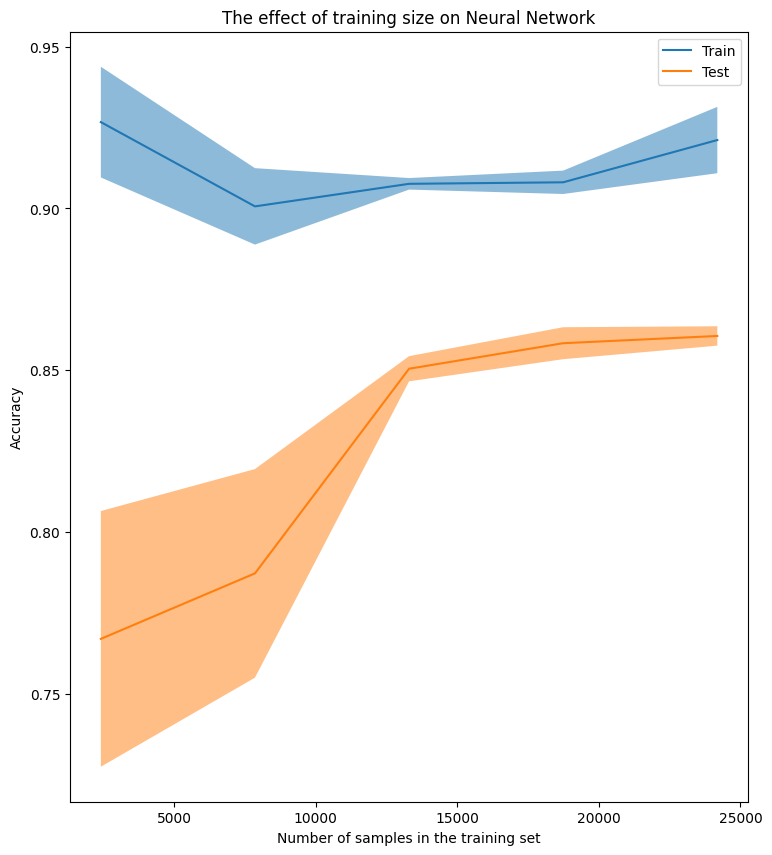

In [122]:
#Training Curve for Hotel
fig=plt.figure(figsize=(8.75,10))
algo=NNnet(input_dims=30)
sklr=StandardScaler()
param_dicts={'internal_layers':8,'units':256,'learning_rate':0.0001,'dropout_rate':0.25,'batch_size':64}
plt.title('The effect of training size on Neural Network')
LearningCurveDisplay.from_estimator(algo.set_params(**param_dicts),sklr.fit_transform(X_hotel),Y_hotel,cv=3,scoring=ld_accuracy_scorer(),ax=plt.gca())
plt.ylabel('Accuracy')

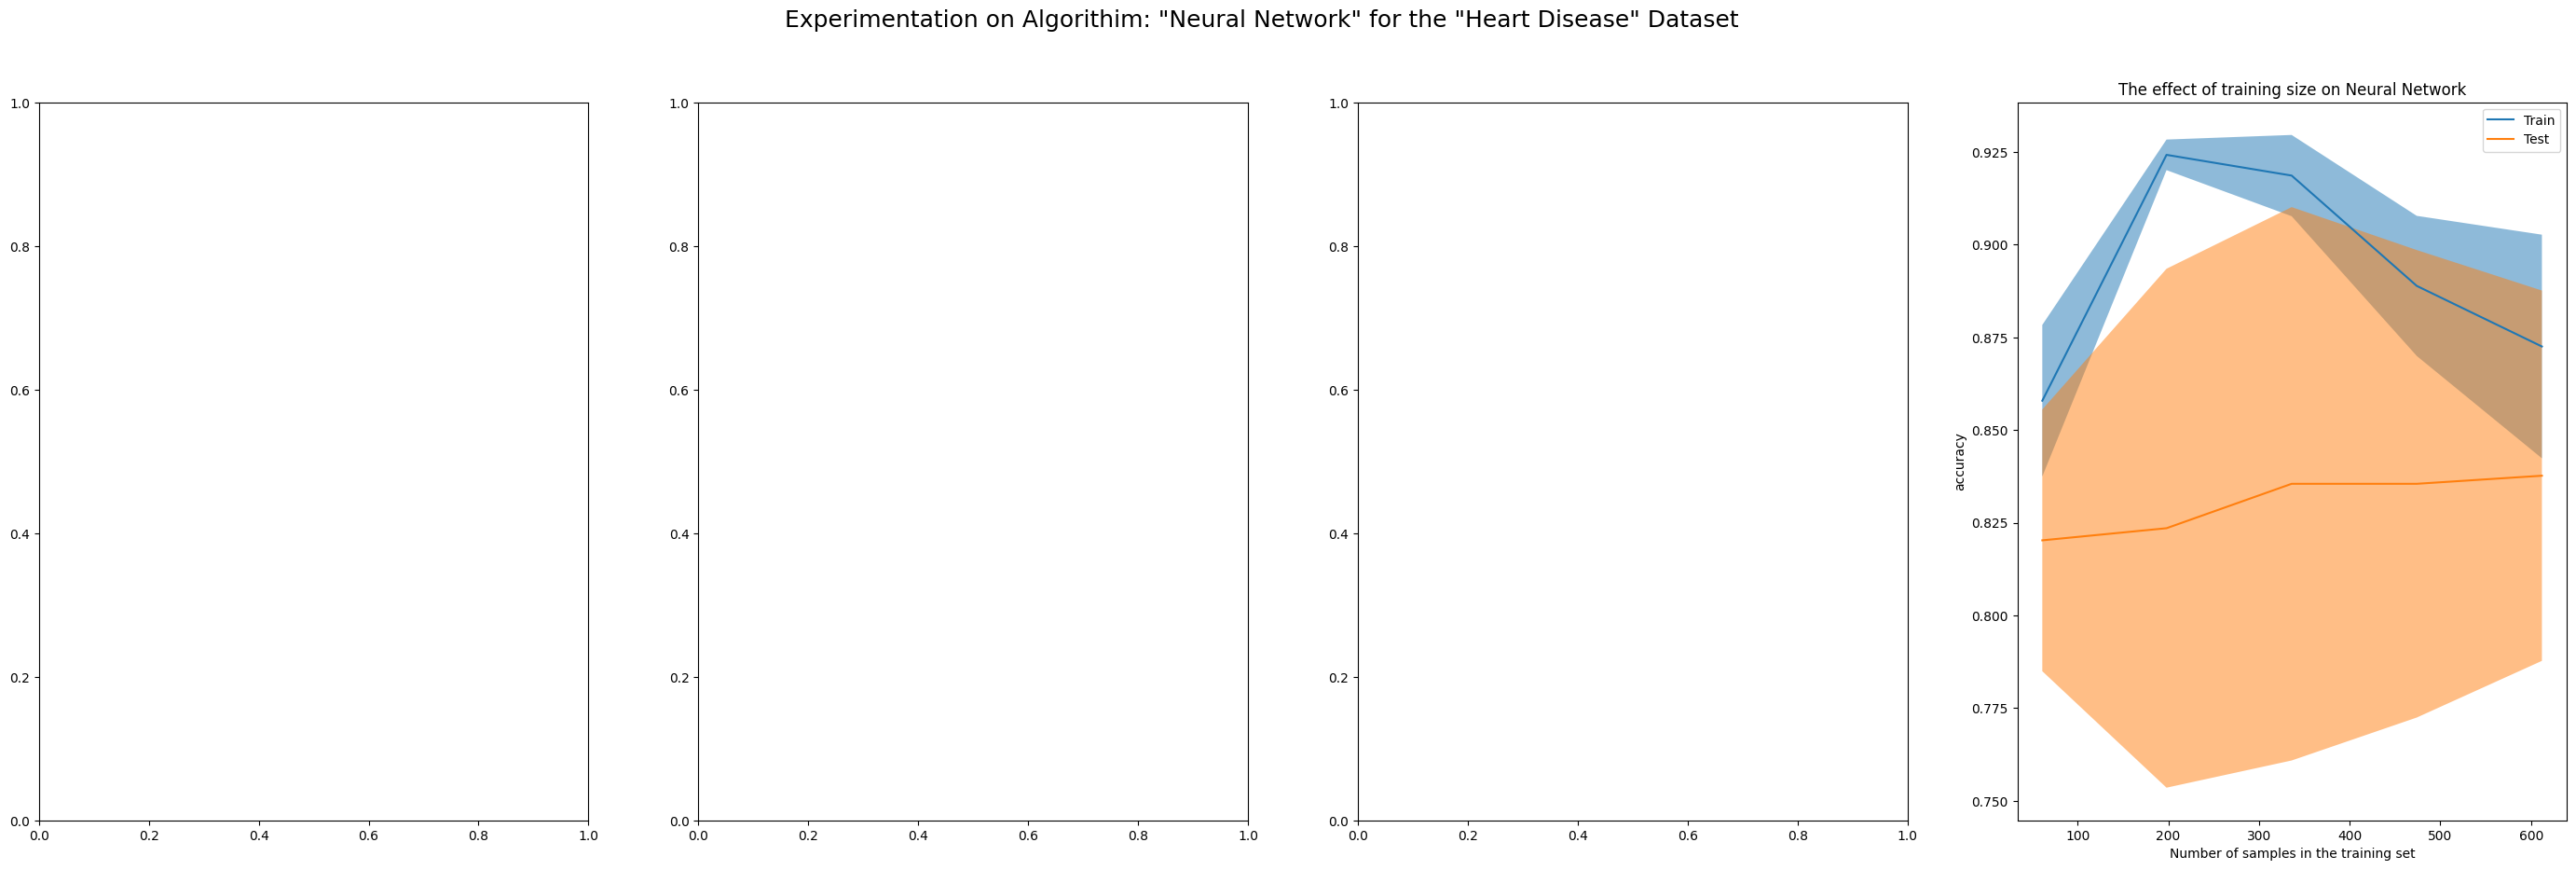

In [148]:
#Experiment Heart Data Accuracy

param_dicts={'dropout_rate': 0.2, 'internal_act': 'elu', 'internal_layers': 4, 'learning_rate': 0.0001, 'units': 100}

experiment_algorithim(train=train_heart_standardized,test=valid_heart_standardized,X=X_heart,Y=Y_heart,params=param_dicts,dataset='Heart Disease',col_index=col_index_heart,predictor_metric=accuracy_score,grid_search_metric=accuracy_scorer,algorithim_name='Neural Network',algorithim=NNnet(input_dims=20),predictor_metric_name='accuracy',search=False,LD_scoring=ld_accuracy_scorer())

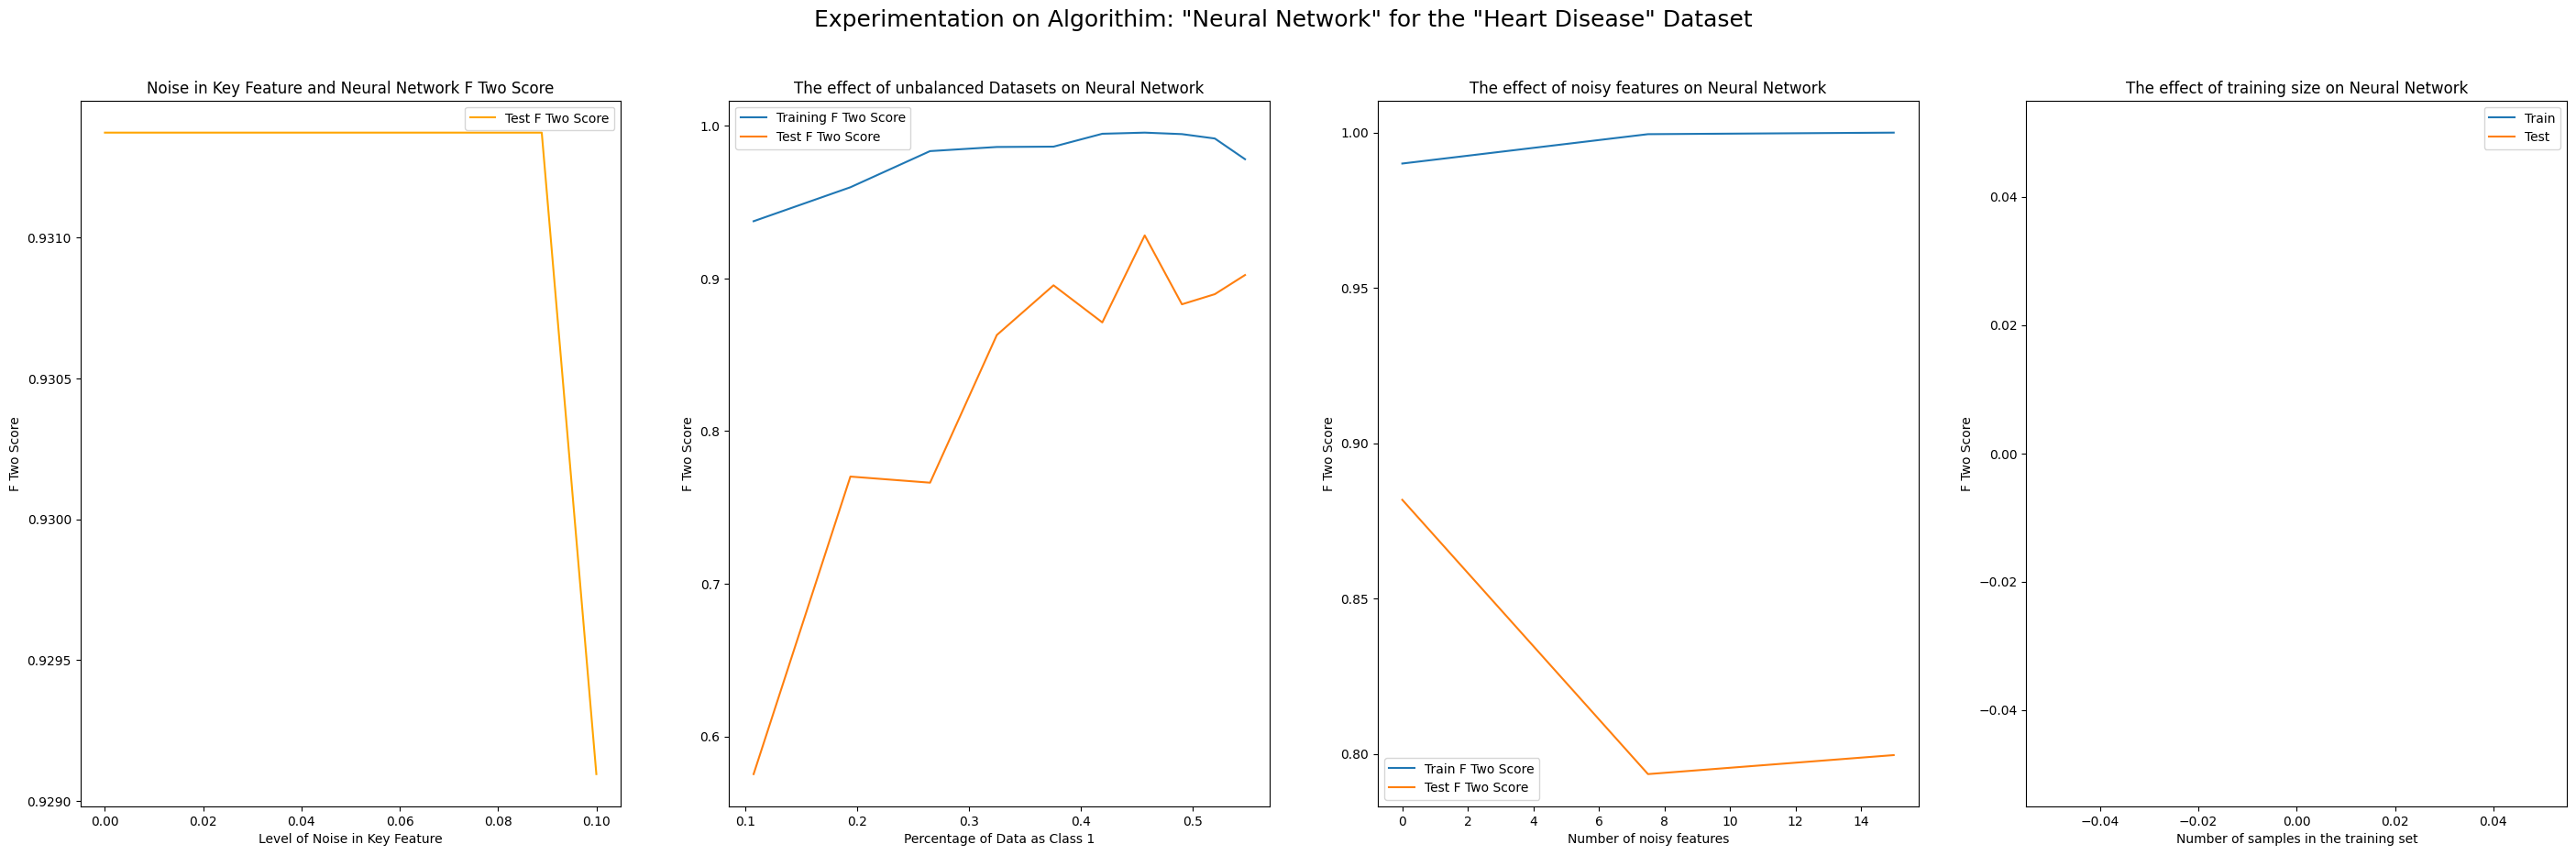

In [70]:
#Experiment Heart Data

param_dicts={'internal_layers':8,'units':128,'learning_rate':0.00001,'dropout_rate':0,'batch_size':32,'internal_act':'elu'}

experiment_algorithim(train=train_heart_standardized,test=valid_heart_standardized,X=X_heart,Y=Y_heart,params=param_dicts,dataset='Heart Disease',col_index=col_index_heart,predictor_metric=fbeta_score,grid_search_metric=ftwo_scorer,algorithim_name='Neural Network',algorithim=NNnet(input_dims=20),predictor_metric_name='F Two Score',search=False,LD_scoring=ld_ftwo_scorer())

Text(0, 0.5, 'F Two Score')

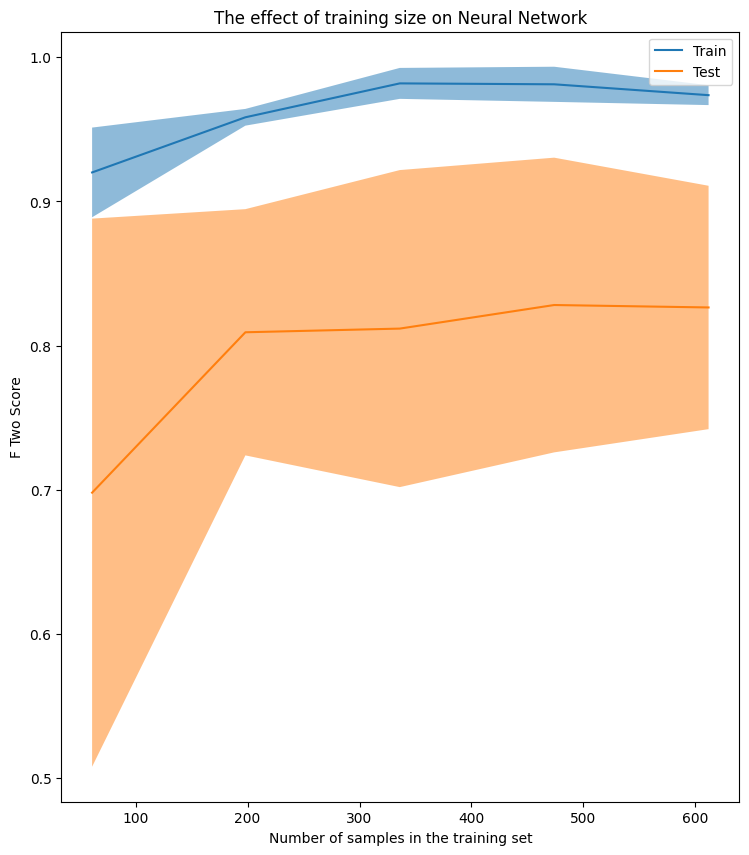

In [90]:
#Training Curve for NNET for Heart
fig=plt.figure(figsize=(8.75,10))
algo=NNnet(input_dims=20)
sklr=StandardScaler()
param_dicts={'internal_layers':8,'units':100,'learning_rate':0.00001,'dropout_rate':0.5,'batch_size':32}
plt.title('The effect of training size on Neural Network')
LearningCurveDisplay.from_estimator(algo.set_params(**param_dicts),sklr.fit_transform(X_heart),Y_heart,cv=3,scoring=ld_ftwo_scorer(),ax=plt.gca())
plt.ylabel('F Two Score')

In [136]:
#Final Hotel Dataset Results

param_dicts={'internal_layers':[4,8],'units':[50,128],'learning_rate':[0.0001,0.001],'dropout_rate':[0,0.1]}

score_algorithim(X_hotel,Y_hotel,'Hotel Dataset','Neural Network',NNnet(input_dims=30),param_dicts)

Hotel Dataset Final Results


{'dropout_rate': 0.1, 'internal_layers': 4, 'learning_rate': 0.0001, 'units': 128}


Average time to train the ideal Neural Network was 1255.088 seconds
Average time to infer the ideal Neural Network was 0.390 seconds


The result on the training data for the ideal Neural Network algorithim is a 0.9561681598897313 accuracy score
The result on the test data for the ideal Neural Network algorithim is a 0.8744314266023432 accuracy score


In [140]:
#Final Heart Disease Dataset Results

param_dicts={'internal_layers':[4,8,16,32],'units':[50,128],'learning_rate':[0.00001,0.001],'dropout_rate':[0,0.1,0.2],'internal_act':['elu']}

score_algorithim(X=X_heart,Y=Y_heart,dataset_name='Heart Disease Dataset',algorithim_name='Neural Network',algorithim=NNnet(input_dims=20),params=param_dicts)

Heart Disease Dataset Final Results


{'dropout_rate': 0.1, 'internal_act': 'elu', 'internal_layers': 32, 'learning_rate': 1e-05, 'units': 128}


Average time to train the ideal Neural Network was 105.389 seconds
Average time to infer the ideal Neural Network was 0.127 seconds


The result on the training data for the ideal Neural Network algorithim is a 0.8869209809264306 accuracy score
The result on the test data for the ideal Neural Network algorithim is a 0.8532608695652174 accuracy score


In [131]:
#Neural net time taken to train for hotel
param_dicts={'internal_layers':8,'units':128,'learning_rate':0.001,'dropout_rate':0.25,'input_dims':30}
time_taken_nnet=NNnet(**param_dicts)
model=time_taken_nnet.internal_model

history=model.fit(x=train_hotel_standardized[0],y=train_hotel_standardized[1],epochs=100,batch_size=32,verbose=1,validation_data=valid_hotel_standardized)

Epoch 1/100
726/726 [==============================] - 6s 7ms/step - loss: 0.4608 - accuracy: 0.7830 - val_loss: 0.3942 - val_accuracy: 0.8174
Epoch 2/100
726/726 [==============================] - 6s 8ms/step - loss: 0.4069 - accuracy: 0.8174 - val_loss: 0.3767 - val_accuracy: 0.8260
Epoch 3/100
726/726 [==============================] - 6s 8ms/step - loss: 0.3864 - accuracy: 0.8263 - val_loss: 0.3795 - val_accuracy: 0.8206
Epoch 4/100
726/726 [==============================] - 6s 8ms/step - loss: 0.3748 - accuracy: 0.8331 - val_loss: 0.3639 - val_accuracy: 0.8361
Epoch 5/100
726/726 [==============================] - 6s 8ms/step - loss: 0.3668 - accuracy: 0.8385 - val_loss: 0.3587 - val_accuracy: 0.8363
Epoch 6/100
726/726 [==============================] - 6s 8ms/step - loss: 0.3592 - accuracy: 0.8410 - val_loss: 0.3527 - val_accuracy: 0.8394
Epoch 7/100
726/726 [==============================] - 6s 8ms/step - loss: 0.3542 - accuracy: 0.8424 - val_loss: 0.3498 - val_accuracy: 0.8453

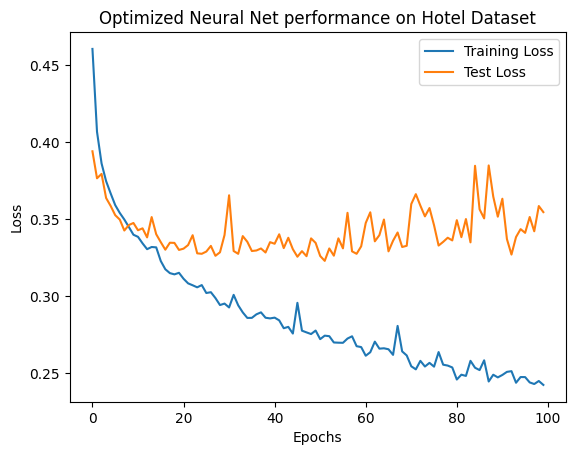

In [132]:
plt.figure()
plt.title('Optimized Neural Net performance on Hotel Dataset')
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

In [133]:
from tensorflow_addons.metrics import FBetaScore 

param_dicts={'internal_layers':8,'units':128,'learning_rate':0.0001,'dropout_rate':0.25,'input_dims':20,'metrics':['accuracy']}
time_taken_nnet=NNnet(**param_dicts)
model=time_taken_nnet.internal_model

history=model.fit(x=train_heart_standardized[0],y=train_heart_standardized[1],epochs=100,batch_size=32,verbose=1,validation_data=valid_heart_standardized)

Epoch 1/100
19/19 [==============================] - 1s 15ms/step - loss: 0.6909 - accuracy: 0.5128 - val_loss: 0.6906 - val_accuracy: 0.5850
Epoch 2/100
19/19 [==============================] - 0s 10ms/step - loss: 0.6943 - accuracy: 0.5026 - val_loss: 0.6887 - val_accuracy: 0.5442
Epoch 3/100
19/19 [==============================] - 0s 11ms/step - loss: 0.6899 - accuracy: 0.5503 - val_loss: 0.6869 - val_accuracy: 0.5442
Epoch 4/100
19/19 [==============================] - 0s 10ms/step - loss: 0.6891 - accuracy: 0.5486 - val_loss: 0.6846 - val_accuracy: 0.5442
Epoch 5/100
19/19 [==============================] - 0s 9ms/step - loss: 0.6860 - accuracy: 0.5503 - val_loss: 0.6805 - val_accuracy: 0.5442
Epoch 6/100
19/19 [==============================] - 0s 9ms/step - loss: 0.6816 - accuracy: 0.5622 - val_loss: 0.6745 - val_accuracy: 0.5442
Epoch 7/100
19/19 [==============================] - 0s 9ms/step - loss: 0.6773 - accuracy: 0.5622 - val_loss: 0.6657 - val_accuracy: 0.5442
Epoch 8/1

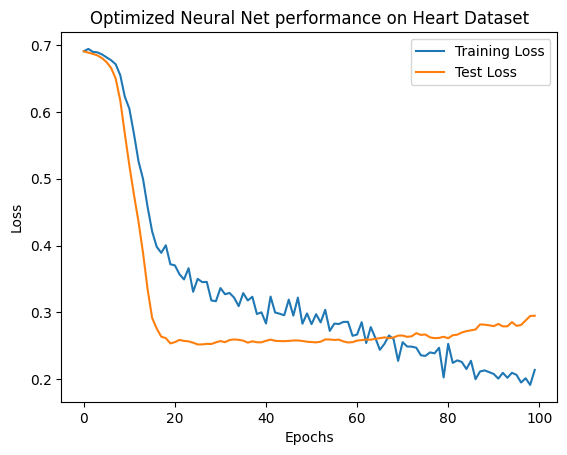

In [134]:
plt.figure()
plt.title('Optimized Neural Net performance on Heart Dataset')
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

In [97]:
#Comparison of inference and test times
algorithim_name = ['Decision Tree','Gradient Boosted Tree','KNN','SVM','Neural Net']

#Hotel

hotel_training_time =[1.199,10.010,0.230,19.271,655.749]
hotel_test_time=[0.001,0.032,0.235,4.594,0.367]

hotel_train_accuracy=[0.877394900068918,0.8823914541695382,0.9940041350792557,0.8572019297036526,0.9016884906960717]
hotel_test_accuracy=[0.8667126119917299,0.8690558235699517,0.8702963473466575,0.8387319090282563,0.8640937284631289]

#Heart

heart_training_time=[0.109,0.528,0.006,0.013,13.418]
heart_test_time=[0.000,0.001,0.004,0.004,0.03]

heart_train_f2=[0.905940594059406,0.9305760709010341,1.0,0.9170731707317072,0.9771825396825395]
heart_test_f2=[0.8061420345489443,0.8945386064030131,0.8834586466165413,0.8861940298507461,0.9133709981167608]

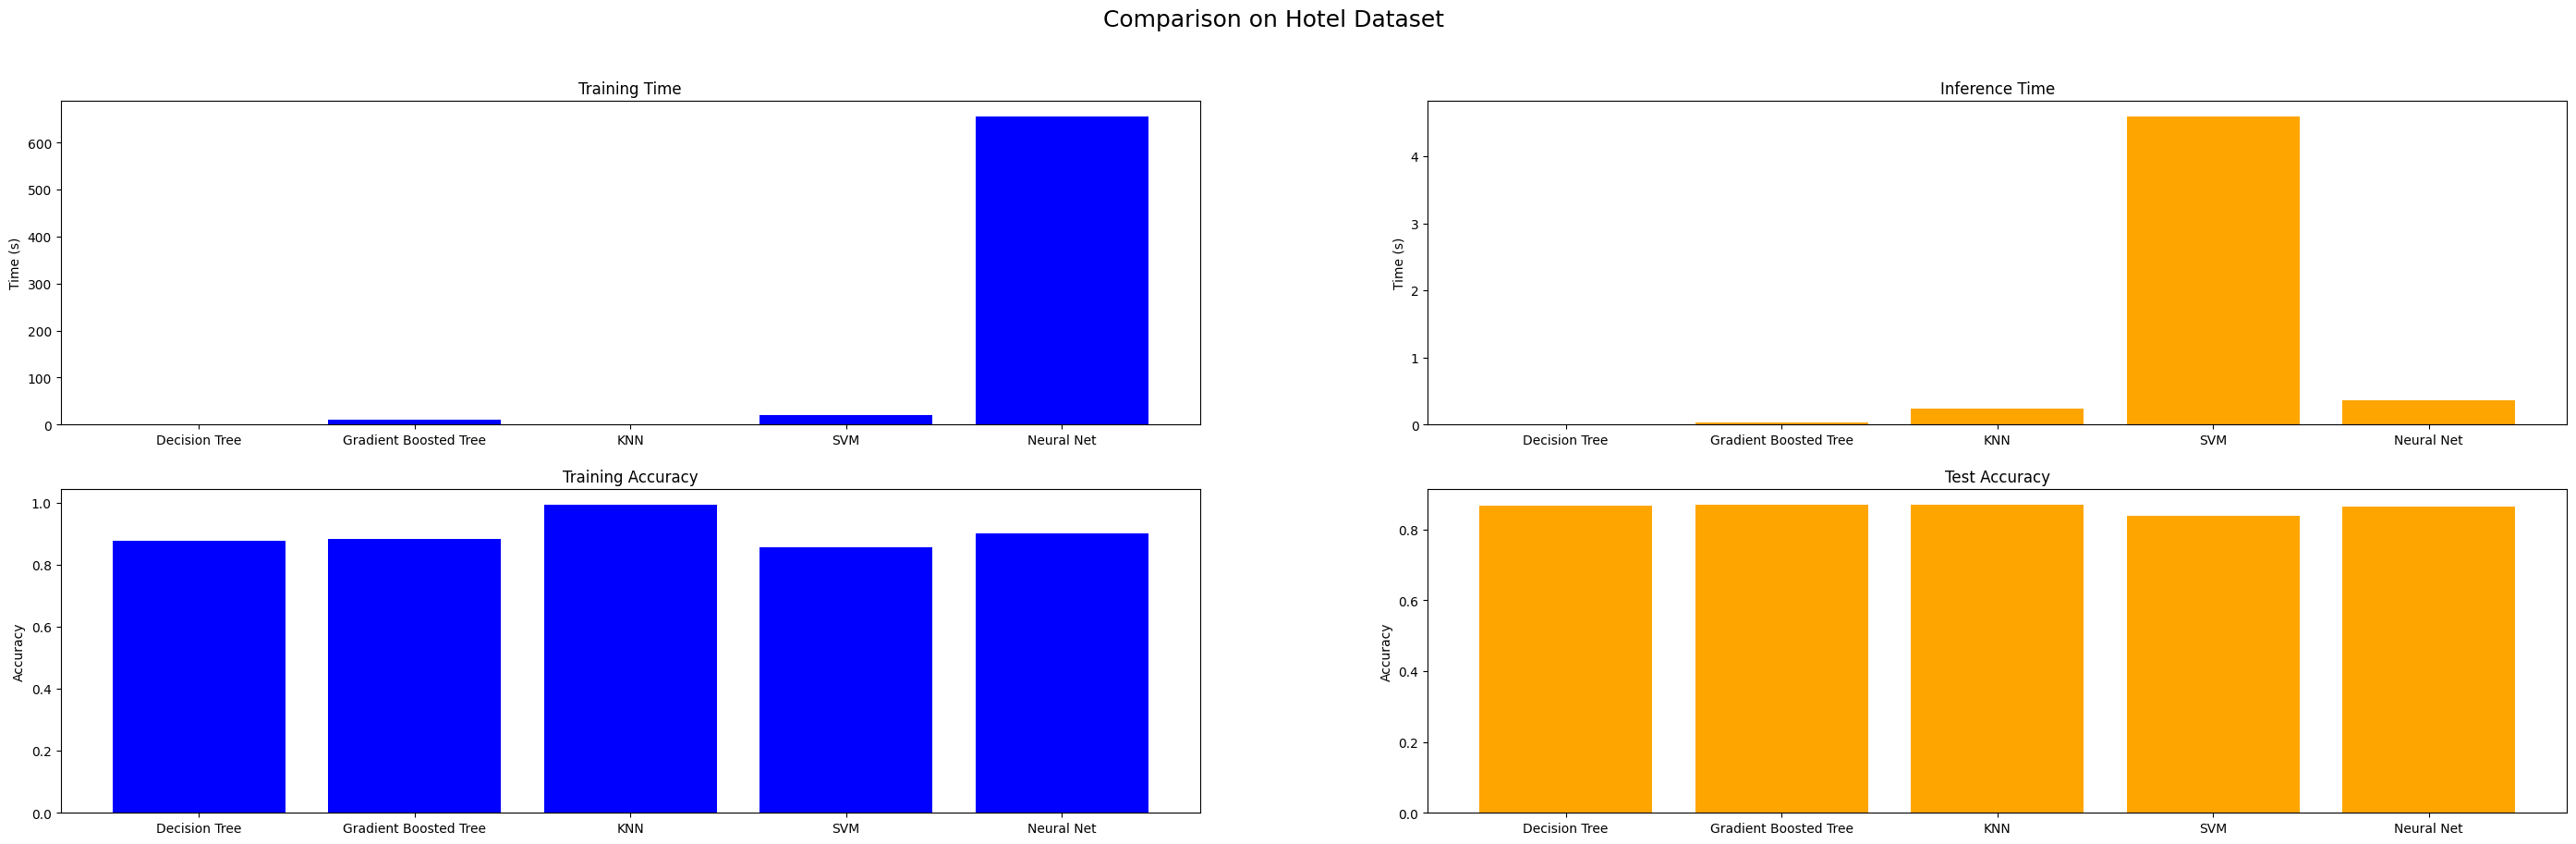

In [122]:
fig,axes=plt.subplots(2,2)
fig.set_size_inches(35,10)
plt.suptitle('Comparison on Hotel Dataset',fontsize=18)

#Training Time
axes[0,0].set_title('Training Time')
axes[0,0].bar(algorithim_name,hotel_training_time,color='blue')
axes[0,0].set_ylabel('Time (s)')

#Test Time
axes[0,1].set_title('Inference Time')
axes[0,1].bar(algorithim_name,hotel_test_time,color='orange')
axes[0,1].set_ylabel('Time (s)')

#Training Acccuracy
axes[1,0].set_title('Training Accuracy')
axes[1,0].bar(algorithim_name,hotel_train_accuracy,color='blue')
axes[1,0].set_ylabel('Accuracy');

#Test Acccuracy
axes[1,1].set_title('Test Accuracy')
axes[1,1].bar(algorithim_name,hotel_test_accuracy,color='orange')
axes[1,1].set_ylabel('Accuracy');

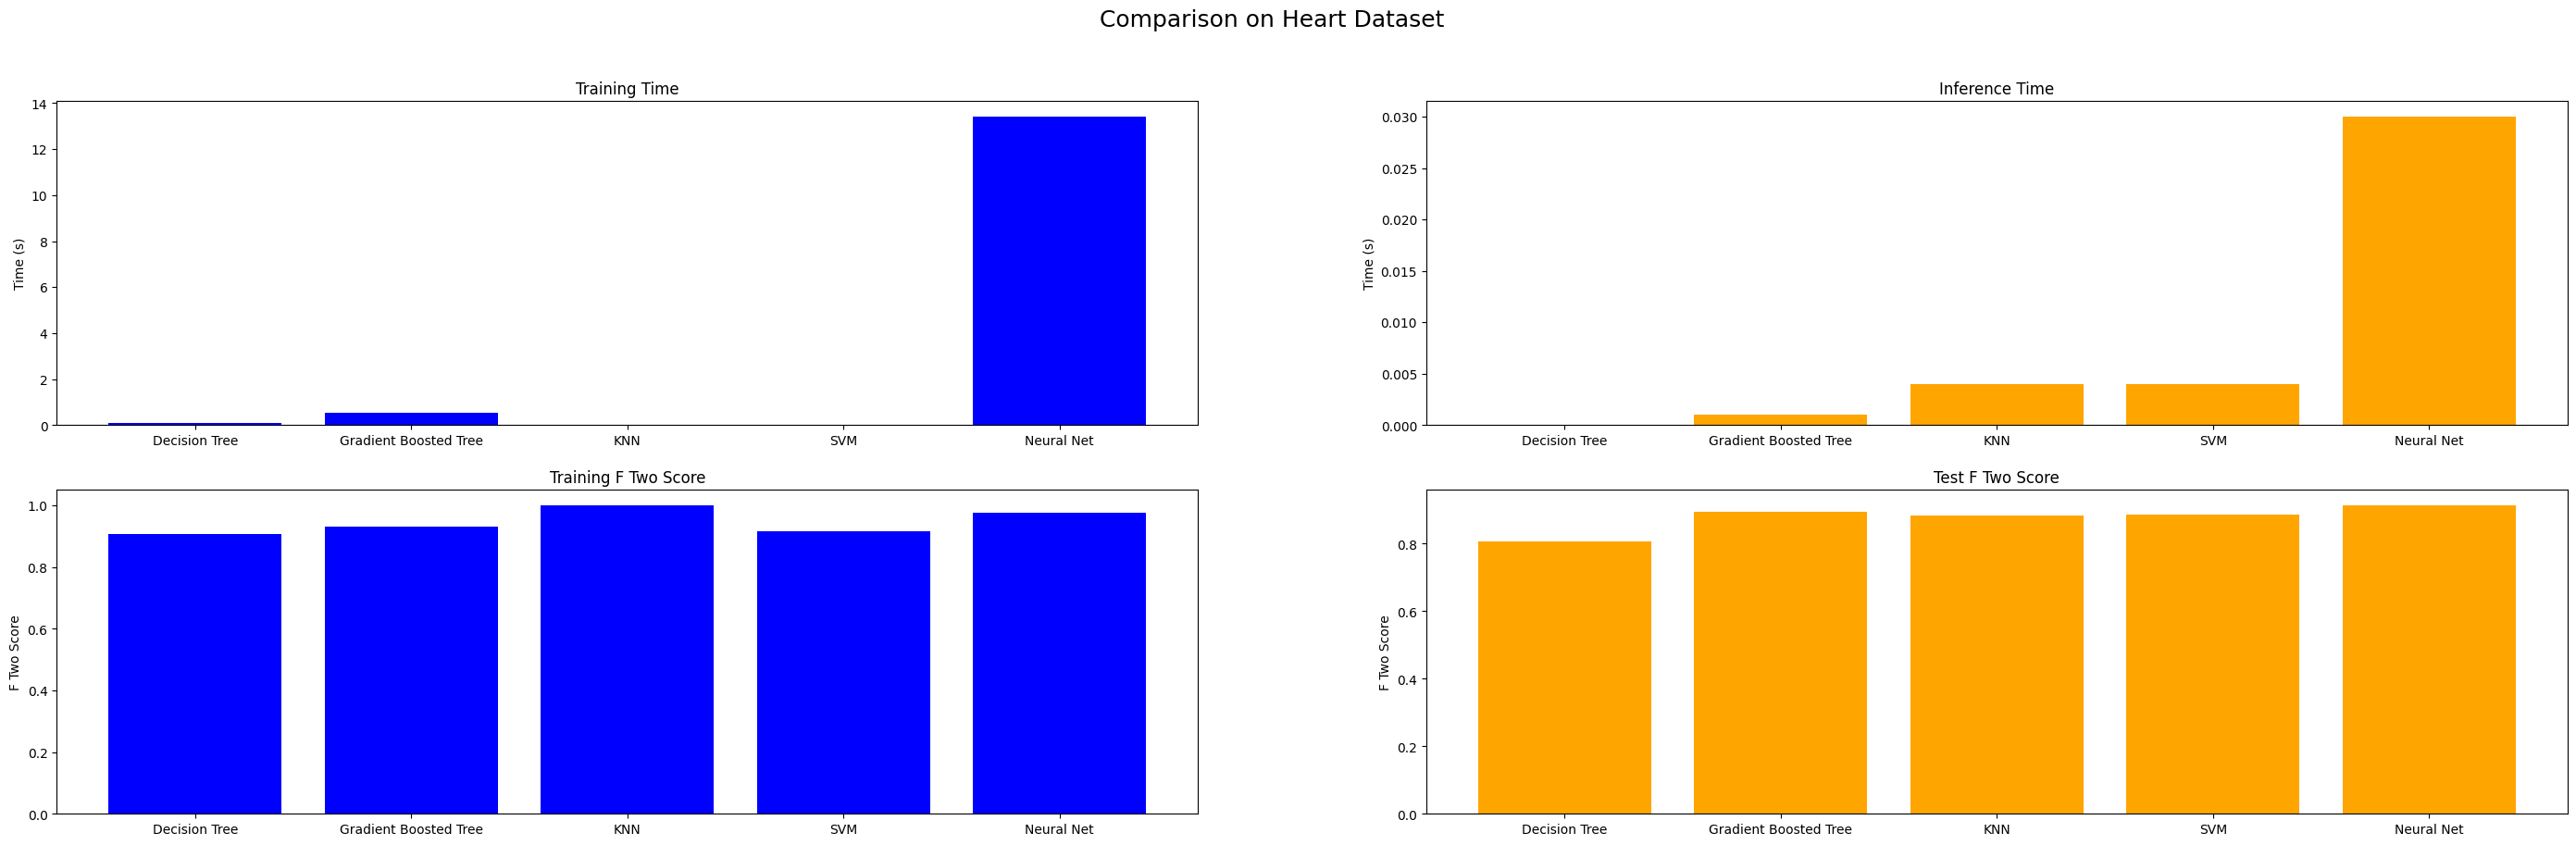

In [123]:
fig,axes=plt.subplots(2,2)
fig.set_size_inches(35,10)
plt.suptitle('Comparison on Heart Dataset',fontsize=18)

#Training Time
axes[0,0].set_title('Training Time')
axes[0,0].bar(algorithim_name,heart_training_time,color='blue')
axes[0,0].set_ylabel('Time (s)')

#Test Time
axes[0,1].set_title('Inference Time')
axes[0,1].bar(algorithim_name,heart_test_time,color='orange')
axes[0,1].set_ylabel('Time (s)')

#Training Acccuracy
axes[1,0].set_title('Training F Two Score')
axes[1,0].bar(algorithim_name,heart_train_f2,color='blue')
axes[1,0].set_ylabel('F Two Score');

#Test Acccuracy
axes[1,1].set_title('Test F Two Score')
axes[1,1].bar(algorithim_name,heart_test_f2,color='orange')
axes[1,1].set_ylabel('F Two Score');